<a href="https://colab.research.google.com/github/joyinning/Motor-Crashes-Safety-Analysis/blob/main/Road_Safety_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Motor Vehicle Crash Analysis in Syracuse**
IST718 Project <br>
Group 1: Eunbi Kim, Jiazheng Zhang, Mohit Vellanki, Shan Jiang

# PART 1 Project Overview & Environment Setting

## **Project Overview**

**Background** <br>
Over the last five years, fatalities resulting from vehicle accidents on Syracuse streets have risen by over 70%. Also, incidents involving severe injuries from crashes have seen a 12% increase on the street in Syracuse during the same timeframe.

**Business Obejctive** <br>
Considering the background mentioned above, the business objective in this project is to minimize the occurrence of vehicle-related accidents on the streets in Syracuse, thereby reducing both severe injuries and fatalities.

**Project Goal** <br>
The goal of this project is to decipher the intricate relationship between various factors by utilizing advanced machine learning techniques in order to provide the solutions of the business objective.

**Predictions** <br>
Through the project, we will answer the following questions (predictions).
1. *Can we predict the time of that day of accidents, given the road information, weather, etc?*
2. *Can we predict the event type based on time, road conditions, or weather conditions?*
3. *Are there any specific patterns in accidents during certain weather, lighting, or road surface conditions?*
4. *Are there distinct groups or clusters of accidents based on similar conditions?*
5. *Can we identify anomalies or outliers in accident occurrences based on the collected attributes?*

## **Environment Setting**
Before the research, this step is for setting up the environment for analysis and modeling.

**1) Install pyspark and openpyxl modules**

In [ ]:
# Install openpyxl
!pip install pandas xlrd openpyxl

In [ ]:
# Install pyspark
!pip install pyspark

**2) Import required modules**

Data Manimupation, Numerical Operation, and Visualization

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

PySpark SQL and SQL Functions

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, Row

In [ ]:
from pyspark.sql.functions import hour, date_format, to_date, quarter, month, dayofmonth
from pyspark.sql.functions import col, when, collect_list, desc, split
from pyspark.sql.functions import count, sqrt, sum as sql_sum, log1p, dense_rank

In [ ]:
from pyspark.sql.types import DoubleType

In [ ]:
from pyspark.sql.window import Window

PySpark Machine Learning

In [ ]:
from pyspark.ml import Pipeline, feature, regression, evaluation
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer, IndexToString, PCA
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import Vectors, VectorUDT

ETC

In [ ]:
from scipy.stats import chi2_contingency

**3) Create a new Spark session**

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("IST718Project").getOrCreate()

**4) Mount the Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**5) Load the input files**<br>


Load the input files

In [ ]:
# Full path to the Excel File
# file_path = '/content/drive/MyDrive/IST 718 Project/Motor_Vehicle_Crashes.xlsx'
file_path = 'Motor_Vehicle_Crashes.xlsx'

In [ ]:
# Load the Excel file into a pandas DataFrame
pdf = pd.read_excel(file_path, engine='openpyxl')

Convert the excel file to CSV file for convenience.

In [ ]:
# # Full path to the CSV file
# csv_path = '/content/drive/MyDrive/IST 718 Project/Motor_Vehicle_Crashes.csv'
file_path = 'Motor_Vehicle_Crashes.csv'

In [ ]:
# Load and read the CSV File using PySpark
pdf.to_csv(csv_path, index=False)
df = spark.read.csv(csv_path, header=True, inferSchema=True)

**6) Check if the input files are successfully uploaded or not**

In [ ]:
# Show the first few rows of the DataFrame
df.show()

+----+--------------------+-------------------+----------+-----------+-------------+-------------------+-------------------------+--------------------+------------------+----------------------+-----------------------+-----------------------------+---------------------------+--------------------+---------------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+
|Year|    Crash Descriptor|               Time|      Date|Day of Week|Police Report|Lighting Conditions|Collision Type Descriptor|     Road Descriptor|Weather Conditions|Traffic Control Device|Road Surface Conditions|DOT Reference Marker Location|Pedestrian Bicyclist Action|    Event Descriptor|Number of Vehicles Involved| AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_Weather

# PART 2 Data Exploration

## **Exploratory Data Analysis**

Explore and analyze the given dataset through the following methods to select the best features for better performance of machine learning models. We will conduct the following strategies.
1. **Data Structure/Univariate Analysis**: to understand the data distribution
2. **Correlation/Association Analysis**: to quantify relationships.

### **1) Data Structure**
The dataset is collected from the case information of motor crash from New York State Open Data Portal and NOAA (National Oceanic and Atmospheric Administration) Climate Data Online Tool. This dataset contains **23,638 observations with 31 variables**.

In [ ]:
print('rows: ', df.count(), ', cols:', len(df.columns))

rows:  23638 , cols: 31


In [ ]:
df.toPandas().head(2)

Year          Crash Descriptor                Time        Date Day of Week  \
0  2017  Property Damage Accident 2023-12-13 08:30:00  2017-01-01      Sunday   
1  2017  Property Damage Accident 2023-12-13 09:30:00  2017-01-01      Sunday   

  Police Report Lighting Conditions Collision Type Descriptor  \
0             Y             Unknown               RIGHT ANGLE   
1             Y            Daylight                  REAR END   

      Road Descriptor Weather Conditions  ... TMAX TMIN Fog_WeatherType  \
0  Straight and Grade             Cloudy  ...   39   22               0   
1  Straight and Level              Clear  ...   39   22               0   

  HeavyFog__WeatherType Thunder_WeatherType  IcePellets_WeatherType  \
0                     0                   0                       0   
1                     0                   0                       0   

   Hail_WeatherType  Glaze_WeatherType  Smoke_WeatherType  \
0                 0                  0                  0   
1                 0                  0                  0   

   BlowingORDriftingSnow_WeatherType  
0                                  0  
1                                  0  

[2 rows x 31 columns]

Check the schema of the uploaded dataset to understand the types of variables and decide which one we should use for analysis and building. We will drop unnecessary columns later based on the exploration.

In [ ]:
df.describe().printSchema()

root
 |-- summary: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Crash Descriptor: string (nullable = true)
 |-- Day of Week: string (nullable = true)
 |-- Police Report: string (nullable = true)
 |-- Lighting Conditions: string (nullable = true)
 |-- Collision Type Descriptor: string (nullable = true)
 |-- Road Descriptor: string (nullable = true)
 |-- Weather Conditions: string (nullable = true)
 |-- Traffic Control Device: string (nullable = true)
 |-- Road Surface Conditions: string (nullable = true)
 |-- DOT Reference Marker Location: string (nullable = true)
 |-- Pedestrian Bicyclist Action: string (nullable = true)
 |-- Event Descriptor: string (nullable = true)
 |-- Number of Vehicles Involved: string (nullable = true)
 |-- AWND: string (nullable = true)
 |-- PRCP: string (nullable = true)
 |-- SNOW: string (nullable = true)
 |-- SNWD: string (nullable = true)
 |-- TAVG: string (nullable = true)
 |-- TMAX: string (nullable = true)
 |-- TMIN: string (nullable

We divided the variables except `event_descriptor` (target) into 5 categories as follows.
1. **Date and Time Information**: Year, Quarter, Month, Day of Month, Day of Week
2. **Accident Information**: Number of Vehicles Involved, Collision Type Descriptor, Police Report, Crash Descriptor, Event Descriptor
3. **Environmental Factors**: Lighting Conditions, Road Descriptor, Road Surface Conditions
4. **Weather Conditions**: Weather Conditions, AWND, PRCP, SNOW, SNWD, TAVG, TMAX, TMIN, Fog_WeatherType, HeavyFog__Weather, Type, Thunder_WeatherType, IcePellets_WeatherType, Hail_WeatherType, Glaze_WeatherType, Smoke_WeatherType, BlowingORDriftingSnow_WeatherType
5. **Traffic Control and Pedestrian Information**: Traffic Control Device, Pedestrian Bicyclist Action


### **2) Data Analysis**
To understand the data distribution, conduct univariate analysis with data visualization.

In [ ]:
# copy the dataset for analysis
df_a = df

**Summary**
1. ***Date and Time Information***
- Mostly there are accidents at 16:00 on Friday or in the spring season (Jan ~ Mar).
- It doesn’t have a significant relationship with other factors.


2. ***Accident Information***
- Most accidents result from colliding with other motor vehicles (1 ~ 2 cars) in a situation when a car runs into another vehicle in front of it or property damage accident.

3. ***Environmental Factors***
- Most accidents are caused in the daylight.
Road surface conditions and the weather conditions (cold, foggy, etc) are highly related.

4. ***Weather Conditions***
- The weathers conditions do not seem to significantly affect accidents. (Mostly occurred in the clear weather conditions.) Accidents frequently occur in cold or foggy conditions.

5. ***Traffic Control and Pedestrian Information***
- Traffic control and pedestrian information is slightly related to the accident information.

### Univariate Analysis

**PART1: Date and Time information**

**1) Hour**

Separate the '`hour`' value from the `timestamp` in the DataFrame for further analysis.

In [ ]:
df_a = df.withColumn("Hour", hour("Time"))

*Which time has the highest accident rates for each day?* <br>
- Usually it occurs **on time to leave from work (between 12 and 17)**.

In [ ]:
# count the number of accidents by time of day (clock_time)
time_counts = df_a.groupBy("Hour").agg(count("*").alias("Count")).sort("Count", ascending=False).collect()
hours = [row["Hour"] for row in time_counts]
counts = [row["Count"] for row in time_counts]

# Get the top 5 categories which has the higher number of accidents
top_5_hours = [row["Hour"] for row in time_counts[:5]]
top_5_counts = [row["Count"] for row in time_counts[:5]]

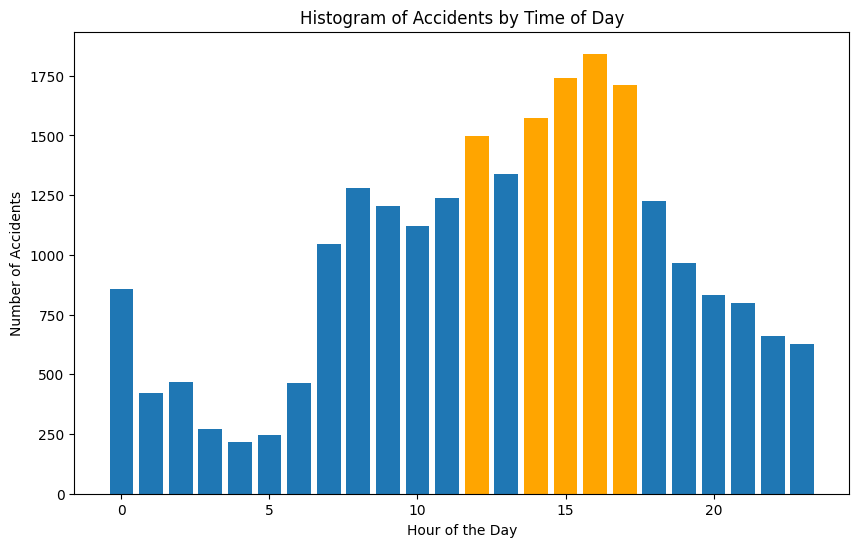

In [ ]:
# Create a histogram of accidents by time of day
plt.figure(figsize=(10, 6))
plt.bar(hours, counts)
for i, hour in enumerate(top_5_hours): # Highlight top 5 hours
    plt.bar(hour, top_5_counts[i], color='orange', label='Top 5 Hours' if i == 0 else '')
plt.title('Histogram of Accidents by Time of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.show()

**2) Day of Week**

*Which week day has a high accidents rate?* <br>
- It shows mostly there are accidents on **Friday**.

In [ ]:
# count the number of accidents by day of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_a.groupBy("Day of Week").agg(count("*").alias("Count")).collect()
day_counts_dict = {row["Day of Week"]: row["Count"] for row in day_counts}
sorted_day_counts = [(day, day_counts_dict[day]) for day in days_order]
days = [day[0] for day in sorted_day_counts]
counts = [count[1] for count in sorted_day_counts]

In [ ]:
# Find the index of the maximum count
max_count_index = counts.index(max(counts))

# Create a list of colors for each bar
colors = ['orange' if i == max_count_index else 'steelblue' for i in range(len(counts))]

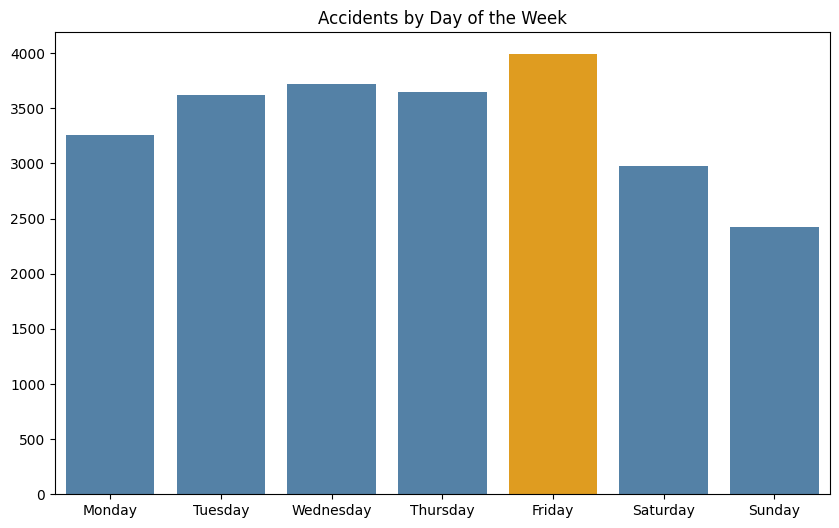

In [ ]:
# create a bar chart of accidents by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=days, y=counts, order=days_order, palette=colors)
plt.title('Accidents by Day of the Week')
plt.show()

**3) Day and Hour**

*Considering both the day and hour, when do the accident mostly occur?* <br>
- It shows the highest accidents rate is at **16:00 on Friday**.

In [ ]:
# aggregate the data
heatmap_data = df_a.groupBy("Day of Week", "Hour").agg(count("*").alias("Count")).collect()

# Transform data into matrix form
heatmap_matrix = [[0 for _ in range(24)] for _ in days_order]
for row in heatmap_data:
    heatmap_matrix[days_order.index(row["Day of Week"])][row["Hour"]] = row["Count"]

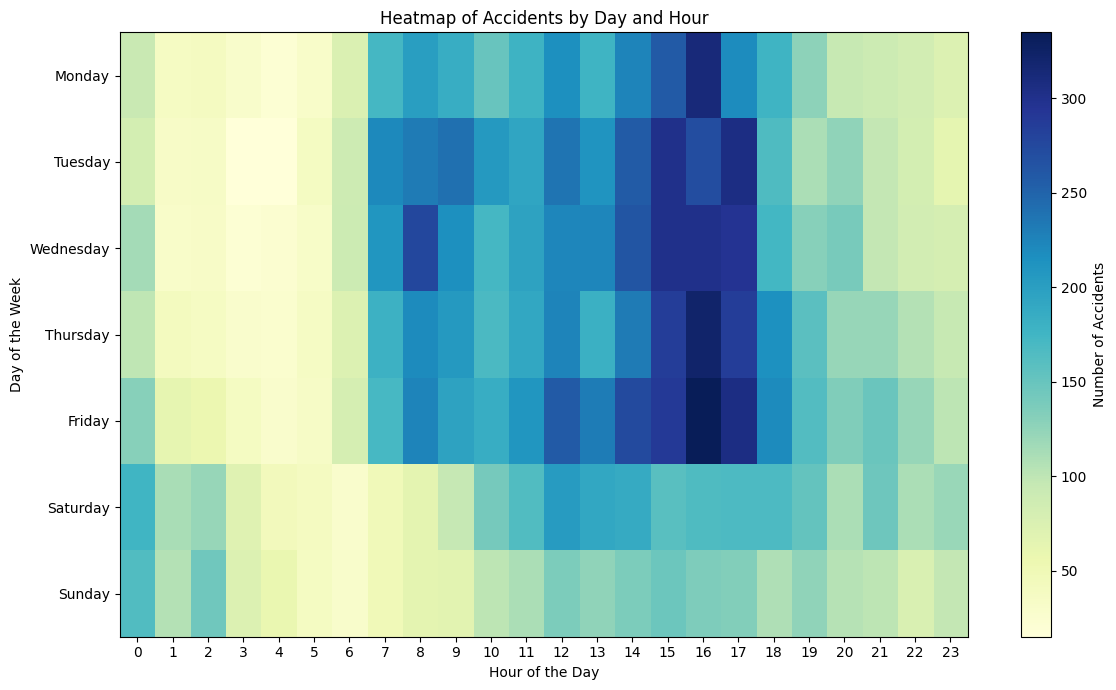

In [ ]:
# create a heatmap of accidents by day and hour
plt.figure(figsize=(12, 7))
plt.imshow(heatmap_matrix, cmap="YlGnBu", aspect="auto")
plt.colorbar(label="Number of Accidents")
plt.xticks(range(24))
plt.yticks(range(7), days_order)
plt.title("Heatmap of Accidents by Day and Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.tight_layout()
plt.show()

**4) Date**

*Which date has a high accidents rate?* <br>
- The **spring season** (Jan, Feb, and Mar) has a high accidents number.

In [ ]:
# Group by 'Date' and count the number of accidents for each date
daily_accidents_df = df_a.groupBy("Date").count().withColumnRenamed("count", "Accident_Count")

# Collect the data
daily_accidents_data = daily_accidents_df.orderBy("Date").collect()

# Extract data for plotting
dates = [row["Date"] for row in daily_accidents_data]
accident_counts = [row["Accident_Count"] for row in daily_accidents_data]

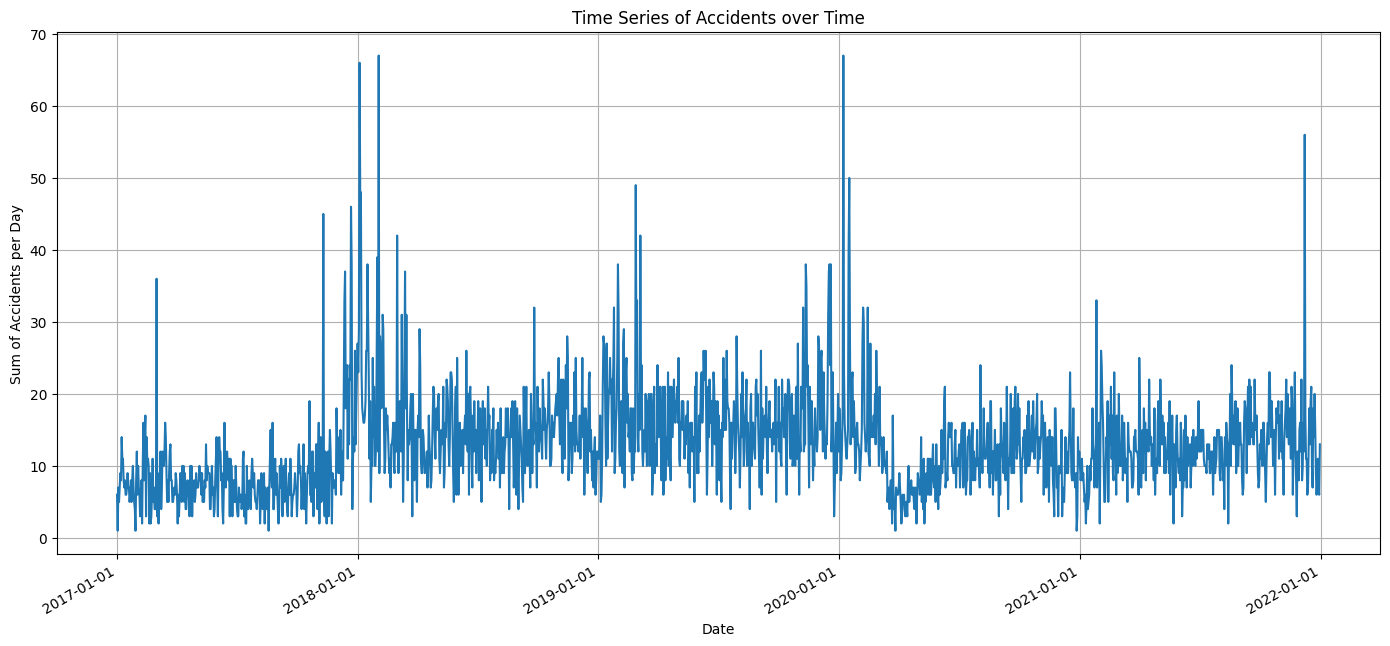

In [ ]:
# create a time series plot of accidents by date
plt.figure(figsize=(14,7))

# convert dates to matplotlib format
dates = mdates.date2num(dates)
plt.plot_date(dates, accident_counts, '-')

# format the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.title("Time Series of Accidents over Time")
plt.xlabel("Date")
plt.ylabel("Sum of Accidents per Day")
plt.grid(True)
plt.tight_layout()

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

plt.show()

**PART2: Accident Information**

**1) Event Descriptor**

Most accidents in the dataset are caused by '**collision with other motor vehicle**'. It accounts for approximately **81%** of the whole population.

In [ ]:
# Count the frequency of each event descriptor
event_frequencies = df.groupBy("Event Descriptor").count().orderBy(col("count").desc())

# Calculate the total number of events
total_events = df.count()

# Calculate the percentage of each event descriptor
event_percentages = event_frequencies.withColumn("Percentage", (col("count") / total_events) * 100)
event_percentages.toPandas().head()

Event Descriptor  count  Percentage
0                Other Motor Vehicle, Collision With  19319   81.728573
1  Light Support/Utility Pole, Collision With Fix...    664    2.809036
2                         Pedestrian, Collision With    644    2.724427
3  Guide Rail - Not At End, Collision With Fixed ...    515    2.178695
4                          Bicyclist, Collision With    267    1.129537

To examine the event descriptors, divide the contents of the `Event Descriptor` column into two distinct categories

In [ ]:
df = df.withColumn('Event_Descriptor_Array', split(df['Event Descriptor'], ','))
df = df.withColumn('Event_descriptor', df['Event_Descriptor_Array'].getItem(0))
df = df.withColumn('Event_descriptor_Type', df['Event_Descriptor_Array'].getItem(1))

`Event_descriptor_Type`: Main Category<br>
- Most accidents are **a collision with** cars or something else that are not a fixed object.

In [ ]:
# Count the frequency of each event descriptor
event_t_frequencies = df.groupBy("Event_descriptor_Type").agg(count('*').alias('count_t')).orderBy('count_t', ascending = False)
event_t_frequencies.toPandas()

Event_descriptor_Type  count_t
0                Collision With    20476
1   Collision With Fixed Object     2861
2                 Non-Collision      153
3                          None      148

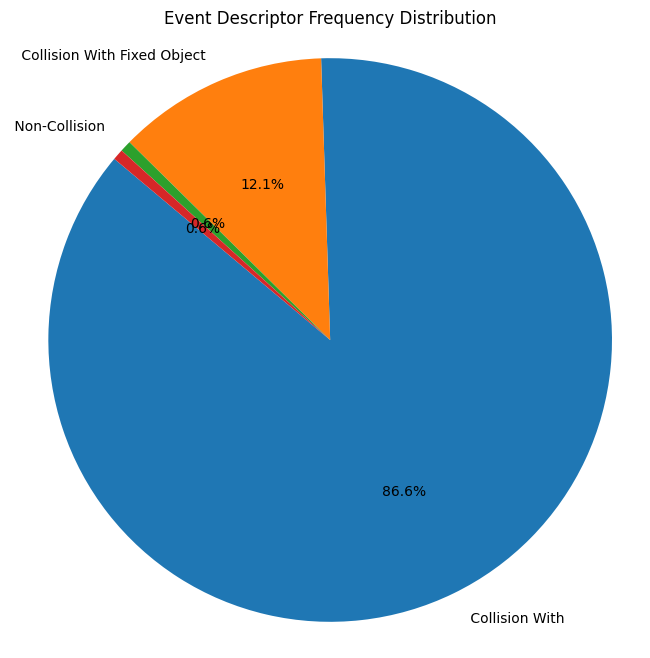

In [ ]:

# Assuming event_t_frequencies_pandas has columns 'Event_descriptor_Type' and 'count_t'
labels = event_t_frequencies.toPandas()['Event_descriptor_Type']
sizes = event_t_frequencies.toPandas()['count_t']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Event Descriptor Frequency Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()


`Event_descriptor`: Sub Category
- Most accidents are **a collision with other Motor Vehicle**.

In [ ]:
# Count the frequency of each event descriptor
event_d_frequencies = df.groupBy('Event_descriptor_Type','Event_descriptor') \
                        .agg(count('*').alias('count_d')) \
                        .orderBy('count_d', ascending=False)
event_d_frequencies.toPandas()

Event_descriptor_Type                 Event_descriptor  count_d
0                 Collision With              Other Motor Vehicle    19319
1    Collision With Fixed Object       Light Support/Utility Pole      664
2                 Collision With                       Pedestrian      644
3    Collision With Fixed Object          Guide Rail - Not At End      515
4                 Collision With                        Bicyclist      267
5    Collision With Fixed Object                        Sign Post      238
6    Collision With Fixed Object                          Curbing      237
7    Collision With Fixed Object                    Building/Wall      224
8    Collision With Fixed Object                             Tree      213
9    Collision With Fixed Object              Other Fixed Object*      183
10                Collision With        Other Object (Not Fixed)*      172
11                          None                             Deer      124
12   Collision With Fixed Object                            Fence      110
13   Collision With Fixed Object                     Fire Hydrant       88
14   Collision With Fixed Object              Median - Not At End       85
15                 Non-Collision                           Other*       80
16   Collision With Fixed Object                          Barrier       77
17                Collision With                           Animal       74
18   Collision With Fixed Object                 Bridge Structure       56
19   Collision With Fixed Object  Earth Embankment/Rock Cut/Ditch       43
20   Collision With Fixed Object                 Guide Rail - End       39
21                 Non-Collision                       Overturned       39
22   Collision With Fixed Object                  Snow Embankment       37
23   Collision With Fixed Object                    Crash Cushion       31
24                 Non-Collision             Ran Off Roadway Only       26
25                          None                 Other Pedestrian       24
26   Collision With Fixed Object                     Median - End       19
27                 Non-Collision                       Submersion        5
28                 Non-Collision                   Fire/Explosion        3
29   Collision With Fixed Object                 Culver/Head Wall        2

**2) Number of Vehicles Involved** <br>
In most accidents, only one car or two cars are involved. We will make a model of anomaly detection in the number of vehicles involved in further research.


In [ ]:
# Group by 'Number of vehicles involved'
number_of_vehicles_involved = df.groupBy('Number of Vehicles Involved').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for visualization
number_of_vehicles_involved_pd = number_of_vehicles_involved.toPandas()

# Sort the DataFrame in descending order of count
number_of_vehicles_involved_pd_sorted = number_of_vehicles_involved_pd.sort_values(by='count', ascending=False)

<Figure size 1000x600 with 0 Axes>

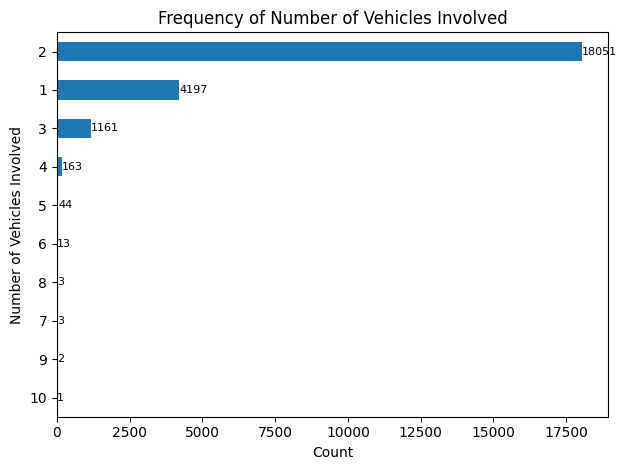

In [ ]:
# Plotting - Horizontal Bar Chart
plt.figure(figsize=(10, 6))
ax = number_of_vehicles_involved_pd_sorted.plot(kind='barh', x='Number of Vehicles Involved', y='count', legend=False)

# Adding labels to the bars
for index, value in enumerate(number_of_vehicles_involved_pd_sorted['count']):
    ax.text(value, index, str(value), va='center', ha='left', fontsize=8, color='black')

# Setting plot title and labels
plt.title('Frequency of Number of Vehicles Involved')
plt.xlabel('Count')
plt.ylabel('Number of Vehicles Involved')
plt.gca().invert_yaxis()  # Inverts the y-axis so the highest bar is at the top
plt.tight_layout()

# Show plot
plt.show()

**3) Collision Type Descriptor**

Based on the dataset available, we cannot determine the most frequently occurring collision types in accidents. The second most frequently occuring collision type is **rear end**, which a car runs into another vehicle in front of it.

In [ ]:
# Group by 'Collision Type Descriptor'
collision_type_descriptor = df.groupBy('Collision Type Descriptor').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for visualization
collision_type_descriptor_pd = collision_type_descriptor.toPandas()

# Sort the DataFrame in descending order of count
collision_type_descriptor_pd_sorted = collision_type_descriptor_pd.sort_values(by='count', ascending=False)

<Figure size 1000x600 with 0 Axes>

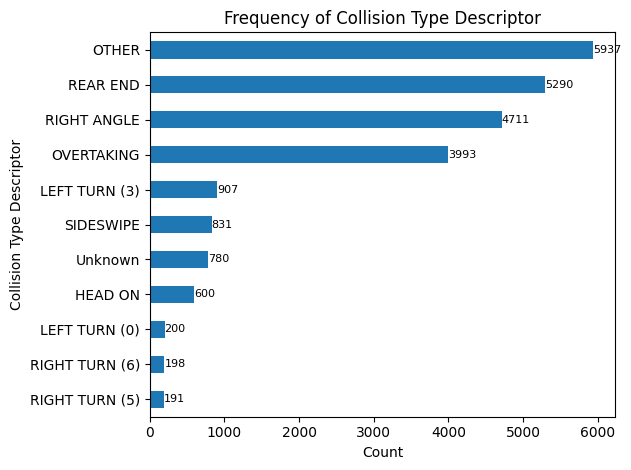

In [ ]:
# Plotting - Horizontal Bar Chart
plt.figure(figsize=(10, 6))
ax = collision_type_descriptor_pd_sorted.plot(kind='barh', x='Collision Type Descriptor', y='count', legend=False)

# Adding labels to the bars
for index, value in enumerate(collision_type_descriptor_pd_sorted['count']):
    ax.text(value, index, str(value), va='center', ha='left', fontsize=8, color='black')

# Setting plot title and labels
plt.title('Frequency of Collision Type Descriptor')
plt.xlabel('Count')
plt.ylabel('Collision Type Descriptor')
plt.gca().invert_yaxis()  # Inverts the y-axis so the highest bar is at the top
plt.tight_layout()

# Show plot
plt.show()

**4) Crash Descriptor**

Most accidents are related to **property damage accident**.

In [ ]:
# Group by 'Collision Type Descriptor'
crash_descriptor = df.groupBy('Crash Descriptor').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for visualization
crash_descriptor_pd = crash_descriptor.toPandas()

# Sort the DataFrame in descending order of count
crash_descriptor_pd_sorted = crash_descriptor_pd.sort_values(by='count', ascending=False)

<Figure size 1000x600 with 0 Axes>

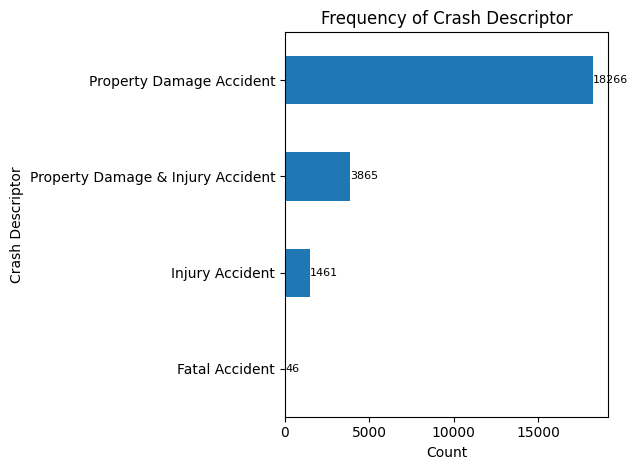

In [ ]:
# Plotting - Horizontal Bar Chart
plt.figure(figsize=(10, 6))
ax = crash_descriptor_pd_sorted.plot(kind='barh', x='Crash Descriptor', y='count', legend=False)

# Adding labels to the bars
for index, value in enumerate(crash_descriptor_pd_sorted['count']):
    ax.text(value, index, str(value), va='center', ha='left', fontsize=8, color='black')

# Setting plot title and labels
plt.title('Frequency of Crash Descriptor')
plt.xlabel('Count')
plt.ylabel('Crash Descriptor')
plt.gca().invert_yaxis()  # Inverts the y-axis so the highest bar is at the top
plt.tight_layout()

# Show plot
plt.show()

**5) Police Report**

Most accidents are reported to the police.

In [ ]:
# Group by 'Collision Type Descriptor'
police_descriptor = df.groupBy('Police Report').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for visualization
police_descriptor_pd = police_descriptor.toPandas()

# Sort the DataFrame in descending order of count
police_descriptor_pd_sorted = police_descriptor_pd.sort_values(by='count', ascending=False)

<Figure size 1000x600 with 0 Axes>

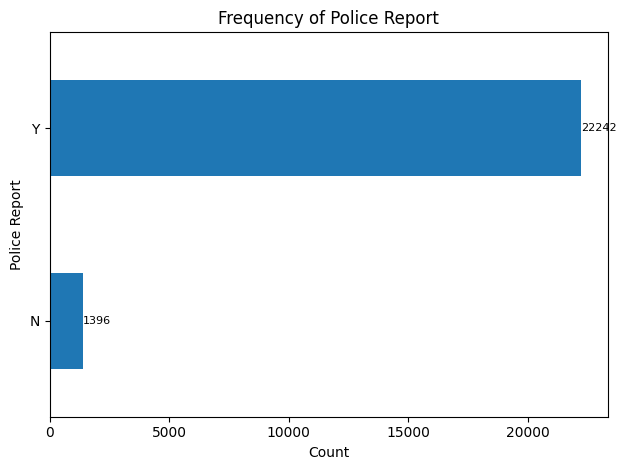

In [ ]:
# Plotting - Horizontal Bar Chart
plt.figure(figsize=(10, 6))
ax = police_descriptor_pd_sorted.plot(kind='barh', x='Police Report', y='count', legend=False)

# Adding labels to the bars
for index, value in enumerate(police_descriptor_pd_sorted['count']):
    ax.text(value, index, str(value), va='center', ha='left', fontsize=8, color='black')

# Setting plot title and labels
plt.title('Frequency of Police Report')
plt.xlabel('Count')
plt.ylabel('Police Report')
plt.gca().invert_yaxis()  # Inverts the y-axis so the highest bar is at the top
plt.tight_layout()

# Show plot
plt.show()

**PART3: Environmental Factors**

**1) Lighting Conditions**

We would conclude that the accidents are caused in the **daylight**.

In [ ]:
# Frequency Analysis for Lighting Conditions
Lighting_condition_freq = df.groupBy('Lighting Conditions').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for visualization
Lighting_condition_pd = Lighting_condition_freq.toPandas()

# Sort the DataFrame in descending order of count to ensure the bars are in the correct order
Lighting_condition_pd_sorted = Lighting_condition_pd.sort_values(by='count', ascending=False)

<Figure size 1000x600 with 0 Axes>

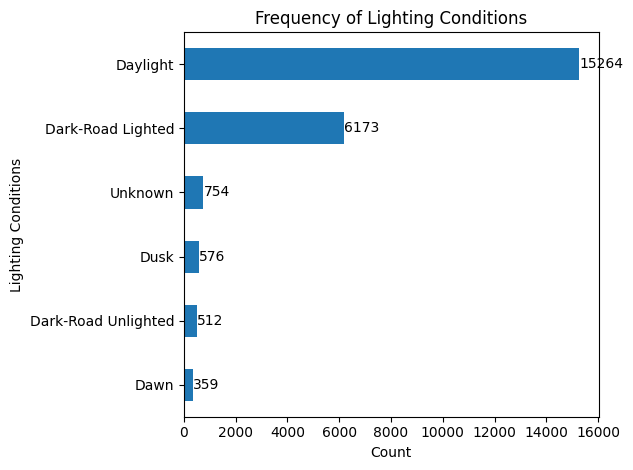

In [ ]:
# Plotting - Horizontal Bar Chart
plt.figure(figsize=(10, 6))
Lighting_condition_pd_sorted.plot(kind='barh', x='Lighting Conditions', y='count', legend=False)
plt.title('Frequency of Lighting Conditions')
plt.xlabel('Count')
plt.ylabel('Lighting Conditions')
plt.gca().invert_yaxis()  # This inverts the y-axis so the highest bar is at the top
for index, value in enumerate(Lighting_condition_pd_sorted['count']):
    plt.text(value, index, str(value), ha='left', va='center')
plt.tight_layout()
plt.show()

**2) Road Descriptor**



The dataset showcases the count of different road descriptors observed in the recorded accidents, with "Straight and Level" being the most frequent descriptor.

In [ ]:
# Frequency Analysis for Road Descriptor
Road_Descriptor_freq = df.groupBy('Road Descriptor').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for visualization
Road_Descriptor_pd = Road_Descriptor_freq.toPandas()

# Sort the DataFrame in descending order of count to ensure the bars are in the correct order
Road_Descriptor_pd_sorted = Road_Descriptor_pd.sort_values(by='count', ascending=False)

In [ ]:
Road_Descriptor_pd_sorted

Road Descriptor  count
0      Straight and Level  17861
1      Straight and Grade   3360
2         Curve and Level    775
3                 Unknown    662
4         Curve and Grade    542
5  Straight at Hill Crest    381
6     Curve at Hill Crest     57

<Figure size 1000x600 with 0 Axes>

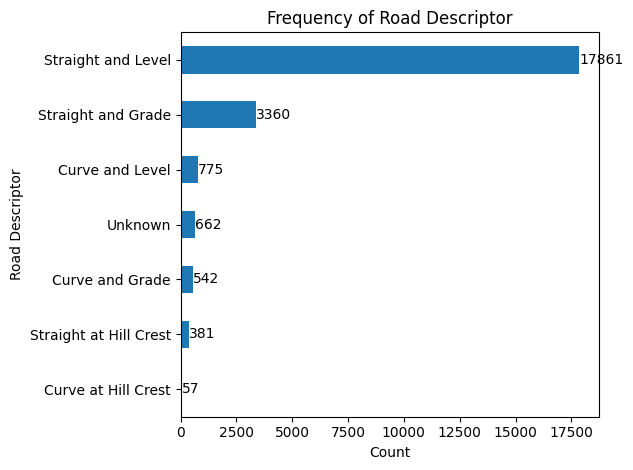

In [ ]:
# Plotting - Horizontal Bar Chart
plt.figure(figsize=(10, 6))
Road_Descriptor_pd_sorted.plot(kind='barh', x='Road Descriptor', y='count', legend=False)
plt.title('Frequency of Road Descriptor')
plt.xlabel('Count')
plt.ylabel('Road Descriptor')
plt.gca().invert_yaxis()  # This inverts the y-axis so the highest bar is at the top
for index, value in enumerate(Road_Descriptor_pd_sorted['count']):
    plt.text(value, index, str(value), ha='left', va='center')
plt.tight_layout()
plt.show()

**PART4: Weather Condition**


**1) Atmospheric Phenomenon** <br>
We would say that atmospheric phenomenon doesn't affect the accidents.

In [ ]:
# Frequency Analysis for Weather Conditions
weather_condition_freq = df.groupBy('Weather Conditions').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for visualization
weather_condition_pd = weather_condition_freq.toPandas()

# Sort the DataFrame in descending order of count to ensure the bars are in the correct order
weather_condition_pd_sorted = weather_condition_pd.sort_values(by='count', ascending=False)

<Figure size 1000x600 with 0 Axes>

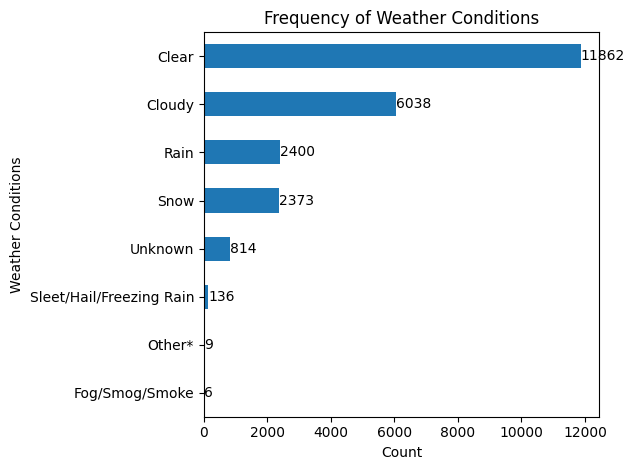

In [ ]:
# Plotting - Horizontal Bar Chart
plt.figure(figsize=(10, 6))
weather_condition_pd_sorted.plot(kind='barh', x='Weather Conditions', y='count', legend=False)
plt.title('Frequency of Weather Conditions')
plt.xlabel('Count')
plt.ylabel('Weather Conditions')
plt.gca().invert_yaxis()  # This inverts the y-axis so the highest bar is at the top
for index, value in enumerate(weather_condition_pd_sorted['count']):
    plt.text(value, index, str(value), ha='left', va='center')
plt.tight_layout()
plt.show()

**2) Temperature** <br>
Usually, the accidents are occured in the cold weather.

In [ ]:
summary_stats = df.select("TAVG", "TMAX", "TMIN").describe().show()
pdf = df.select("TAVG", "TMAX", "TMIN").toPandas()

+-------+------------------+-----------------+------------------+
|summary|              TAVG|             TMAX|              TMIN|
+-------+------------------+-----------------+------------------+
|  count|             23638|            23638|             23638|
|   mean| 47.87981216684999|56.66947288264659|38.794610373128016|
| stddev|19.934235857102355|21.92159951809691|19.009984877416954|
|    min|                -1|                0|               -15|
|    max|                86|               98|                78|
+-------+------------------+-----------------+------------------+



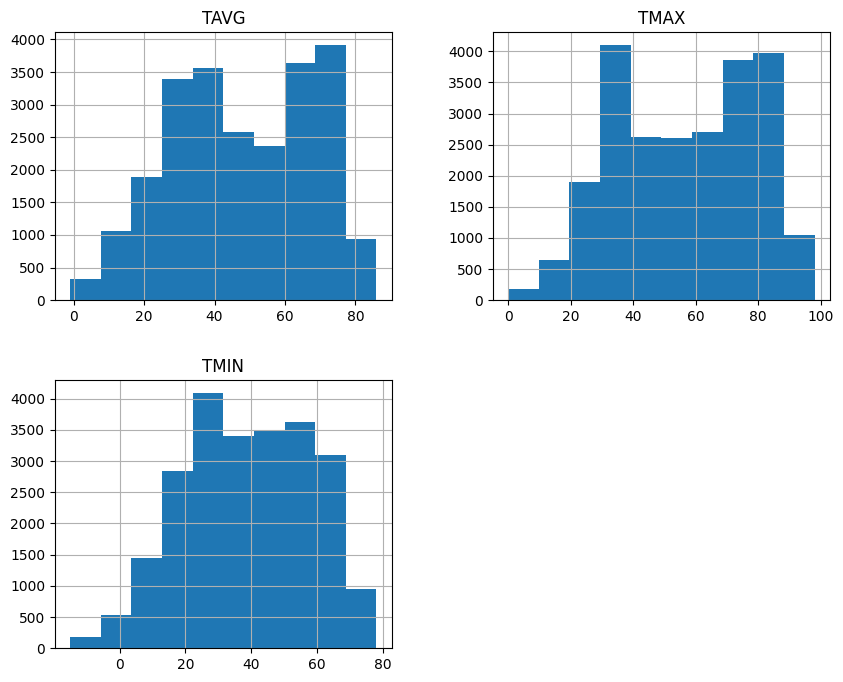

In [ ]:
# Histograms
pdf.hist(figsize=(10, 8))
plt.show()

**3) Wind and Snow** <br>
Based on the analysis, we would say **the average daily wind speed**(tenths of meters per second) can affect the frequency of accidents.

In [ ]:
# Descriptive Statistics
df.select("AWND", "PRCP", "SNOW", "SNWD").describe().show()

# Convert to Pandas DataFrame for visualization (if the data is not too big)
pdf = df.select("AWND", "PRCP", "SNOW", "SNWD").toPandas()

+-------+-----------------+------------------+------------------+------------------+
|summary|             AWND|              PRCP|              SNOW|              SNWD|
+-------+-----------------+------------------+------------------+------------------+
|  count|            23638|             23638|             23638|             23638|
|   mean|8.313117438023227|0.1376613926728174|0.5188002369066844|1.6569041374058497|
| stddev|3.868584754691357|0.2858749368053486|1.5962189476738708|3.5184992604109437|
|    min|             0.89|               0.0|               0.0|               0.0|
|    max|            27.74|              2.72|              18.9|              22.8|
+-------+-----------------+------------------+------------------+------------------+



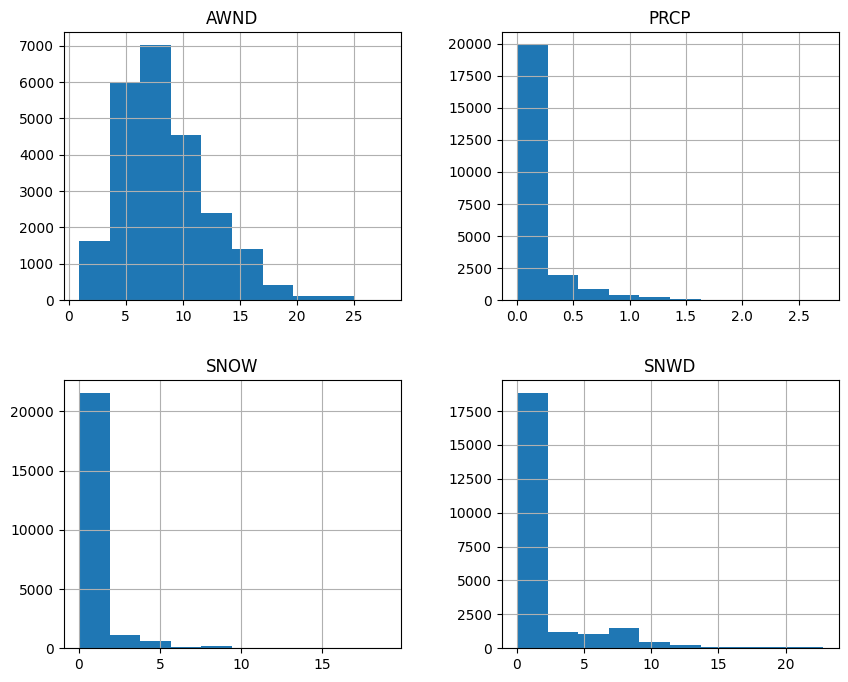

In [ ]:
# Histograms
pdf.hist(figsize=(10, 8))
plt.show()

**4) Weather Type** <br>
**Fog** will affect the most of accidents in the dataset.

In [ ]:
from pyspark.sql.functions import sum as _sum
# Confirm column names
actual_column_names = df.columns
print("Actual column names in the DataFrame:")
print(actual_column_names)

weather_conditions_corrected = [col for col in actual_column_names if 'WeatherType' in col]
print("Corrected weather condition column names:")
print(weather_conditions_corrected)

Actual column names in the DataFrame:
['Year', 'Crash Descriptor', 'Time', 'Date', 'Day of Week', 'Police Report', 'Lighting Conditions', 'Collision Type Descriptor', 'Road Descriptor', 'Weather Conditions', 'Traffic Control Device', 'Road Surface Conditions', 'DOT Reference Marker Location', 'Pedestrian Bicyclist Action', 'Event Descriptor', 'Number of Vehicles Involved', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'Fog_WeatherType', 'HeavyFog__WeatherType', 'Thunder_WeatherType', 'IcePellets_WeatherType', 'Hail_WeatherType', 'Glaze_WeatherType', 'Smoke_WeatherType', 'BlowingORDriftingSnow_WeatherType', 'Event_Descriptor_Array', 'Event_descriptor', 'Event_descriptor_Type']
Corrected weather condition column names:
['Fog_WeatherType', 'HeavyFog__WeatherType', 'Thunder_WeatherType', 'IcePellets_WeatherType', 'Hail_WeatherType', 'Glaze_WeatherType', 'Smoke_WeatherType', 'BlowingORDriftingSnow_WeatherType']


In [ ]:
# calculate the sum for each weather condition column
weather_condition_counts = df.select([_sum(col(c)).alias(c) for c in weather_conditions_corrected])
weather_condition_counts.show()

+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+
|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSnow_WeatherType|
+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+
|          12905|                  983|               1928|                   610|             608|              698|             1677|                             2209|
+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+



In [ ]:
# Convert the Spark DataFrame with counts to a Pandas DataFrame
weather_condition_counts_pd = weather_condition_counts.toPandas()

# Transpose the DataFrame so that weather conditions become the index
weather_condition_counts_pd = weather_condition_counts_pd.transpose()
weather_condition_counts_pd.columns = ['count']

# Sort the DataFrame by count for better visualization
weather_condition_counts_pd = weather_condition_counts_pd.sort_values(by='count', ascending=False)

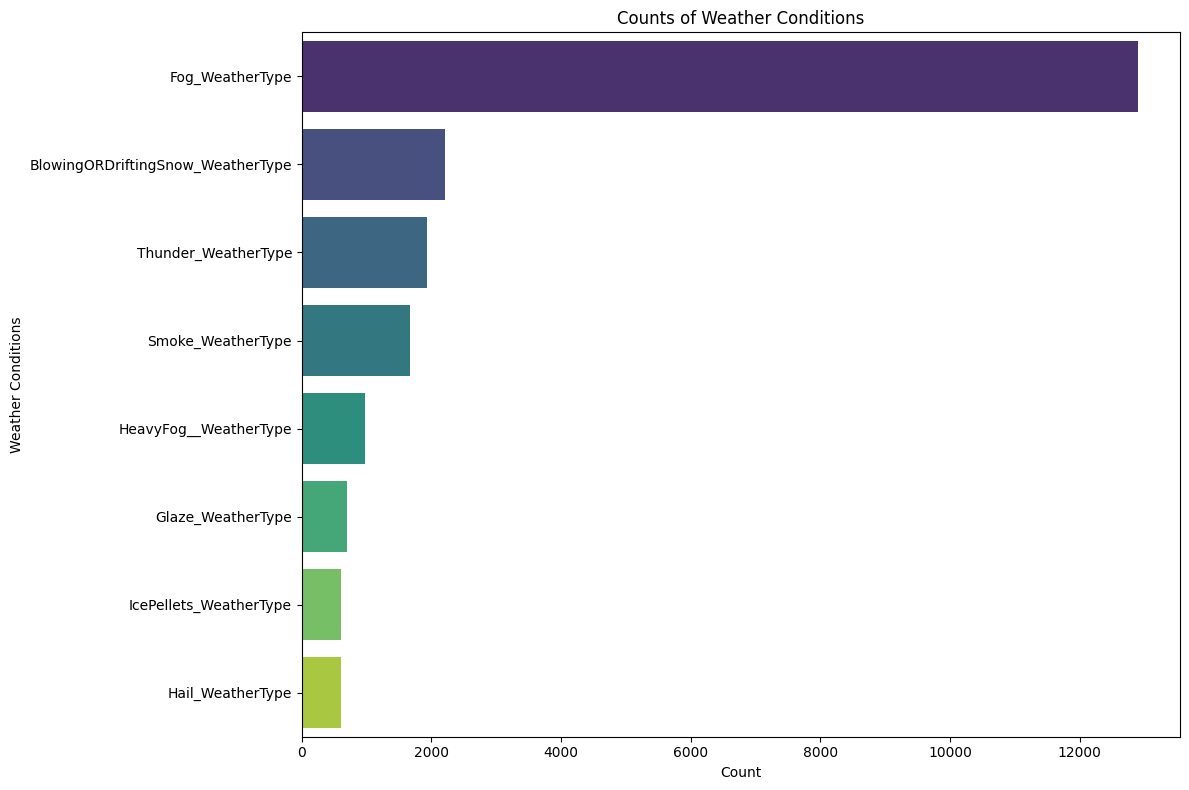

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(
    x=weather_condition_counts_pd['count'],
    y=weather_condition_counts_pd.index,
    palette='viridis'
)

# Add labels and title to the plot
plt.xlabel('Count')
plt.ylabel('Weather Conditions')
plt.title('Counts of Weather Conditions')
plt.tight_layout()  # Ensure the labels and title fit into the plot area
plt.show()

**PART 5: Traffic Control and Pedestrian Information**

**1) Pedestrian Bicyclist Action**


The dataset enumerates pedestrian and bicyclist actions in recorded incidents, with a significant count marked as "Not Applicable". **Baesd on the analysis, we would conclude that pedestrian bicyclist action doesn't affect the vehicle accidents.**

In [ ]:
# Group by 'Road Surface Conditions'
pedestrian_bicyclist_action_freq = df.groupBy('Pedestrian Bicyclist Action').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for visualization
pedestrian_bicyclist_action_pd = pedestrian_bicyclist_action_freq.toPandas()

# Sort the DataFrame in descending order of count
pedestrian_bicyclist_action_pd_sorted = pedestrian_bicyclist_action_pd.sort_values(by='count', ascending=False)

In [ ]:
pedestrian_bicyclist_action_pd_sorted

Pedestrian Bicyclist Action  count
0                                      Not Applicable  22674
1                    Crossing, No Signal or Crosswalk    261
2   Riding/Walking/Skating Along Highway With Traffic    125
3                            Other Actions in Roadway    110
4                               Crossing, With Signal    107
5                            Crossing, Against Signal    101
6                           Not in Roadway (Indicate)     61
7               Crossing, No Signal, Marked Crosswalk     61
8   Riding/Walking/Skating Along Highway Against T...     48
9     Emerging from in Front of/Behind Parked Vehicle     24
10                                            Unknown     21
11                                 Playing in Roadway     20
12                                 Working in Roadway     15
13       Getting On/Off Vehicle Other than School Bus     10

<Figure size 1000x600 with 0 Axes>

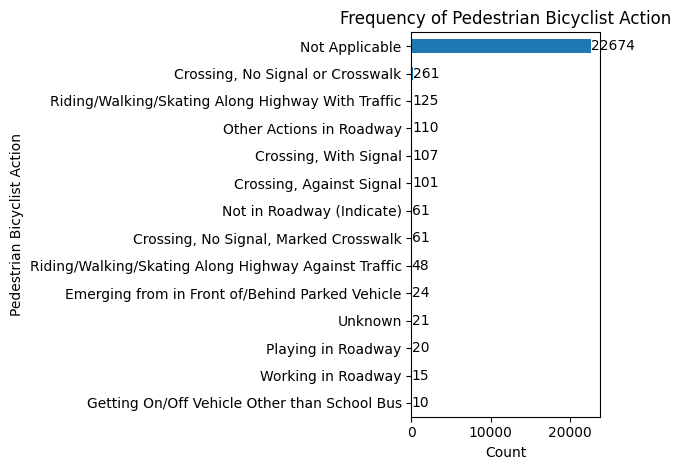

In [ ]:
# Plotting - Horizontal Bar Chart
plt.figure(figsize=(10, 6))
pedestrian_bicyclist_action_pd_sorted.plot(kind='barh', x='Pedestrian Bicyclist Action', y='count', legend=False)
plt.title('Frequency of Pedestrian Bicyclist Action')
plt.xlabel('Count')
plt.ylabel('Pedestrian Bicyclist Action')
plt.gca().invert_yaxis()  # Inverts the y-axis so the highest bar is at the top
for index, value in enumerate(pedestrian_bicyclist_action_pd_sorted['count']):
    plt.text(value, index, str(value), ha='left', va='center')
plt.tight_layout()
plt.show()

**2) Traffic Control Device**


This factor doesn't affect to the accidents.

In [ ]:
# Group by 'Road Surface Conditions'
traffic_control_freq = df.groupBy('Traffic Control Device').count().orderBy('count', ascending=False)

# Convert to Pandas DataFrame for visualization
traffic_control_freq_pd = traffic_control_freq.toPandas()

# Sort the DataFrame in descending order of count
traffic_control_freq_pd_sorted = traffic_control_freq_pd.sort_values(by='count', ascending=False)

<Figure size 1000x600 with 0 Axes>

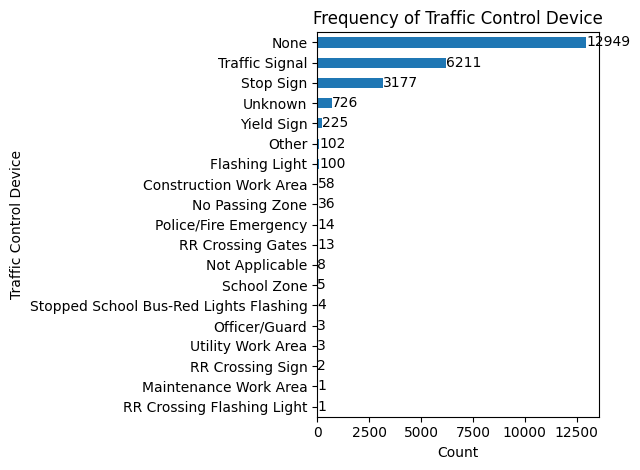

In [ ]:
# Plotting - Horizontal Bar Chart
plt.figure(figsize=(10, 6))
traffic_control_freq_pd_sorted.plot(kind='barh', x='Traffic Control Device', y='count', legend=False)
plt.title('Frequency of Traffic Control Device')
plt.xlabel('Count')
plt.ylabel('Traffic Control Device')
plt.gca().invert_yaxis()  # Inverts the y-axis so the highest bar is at the top
for index, value in enumerate(traffic_control_freq_pd_sorted['count']):
    plt.text(value, index, str(value), ha='left', va='center')
plt.tight_layout()
plt.show()

### Correlations
In this part, we would explore the relationships among the given variables to find the best predictors for our machine learning algorithms.

In [ ]:
# Split the date column into quarter, month, and day of month
df_a_cor = df_a
df_a_cor = df_a_cor.withColumn("Quarter", quarter("Date"))
df_a_cor = df_a_cor.withColumn("Month", month("Date"))
df_a_cor = df_a_cor.withColumn("DayOfMonth", dayofmonth("Date"))

In [ ]:
df_a_cor.select('Time','Quarter','Month','DayOfMonth','Hour').show(2)

+-------------------+-------+-----+----------+----+
|               Time|Quarter|Month|DayOfMonth|Hour|
+-------------------+-------+-----+----------+----+
|2023-12-13 08:30:00|      1|    1|         1|   8|
|2023-12-13 09:30:00|      1|    1|         1|   9|
+-------------------+-------+-----+----------+----+
only showing top 2 rows



In [ ]:
# Drop time, date, and location for further calculation of correlations
df_a_cor = df_a_cor.drop('Time', 'Date', 'DOT Reference Marker Location')

In [ ]:
df_a_cor.show(2)

+----+--------------------+-----------+-------------+-------------------+-------------------------+------------------+------------------+----------------------+-----------------------+---------------------------+--------------------+---------------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+----+-------+-----+----------+
|Year|    Crash Descriptor|Day of Week|Police Report|Lighting Conditions|Collision Type Descriptor|   Road Descriptor|Weather Conditions|Traffic Control Device|Road Surface Conditions|Pedestrian Bicyclist Action|    Event Descriptor|Number of Vehicles Involved| AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSnow_WeatherType|Hour|Quarter|Month|DayOfMonth|
+----+--

In [ ]:
df_a_cor.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Crash Descriptor: string (nullable = true)
 |-- Day of Week: string (nullable = true)
 |-- Police Report: string (nullable = true)
 |-- Lighting Conditions: string (nullable = true)
 |-- Collision Type Descriptor: string (nullable = true)
 |-- Road Descriptor: string (nullable = true)
 |-- Weather Conditions: string (nullable = true)
 |-- Traffic Control Device: string (nullable = true)
 |-- Road Surface Conditions: string (nullable = true)
 |-- Pedestrian Bicyclist Action: string (nullable = true)
 |-- Event Descriptor: string (nullable = true)
 |-- Number of Vehicles Involved: integer (nullable = true)
 |-- AWND: double (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- SNOW: double (nullable = true)
 |-- SNWD: double (nullable = true)
 |-- TAVG: integer (nullable = true)
 |-- TMAX: integer (nullable = true)
 |-- TMIN: integer (nullable = true)
 |-- Fog_WeatherType: integer (nullable = true)
 |-- HeavyFog__WeatherType: integer (n

Calculate the correlation of all variables in the dataset.


**PART 1: Identifying Numerical and Categorical Columns** <br>
The code extracts numerical and categorical column names based on their data types (string for categorical, non-string for numerical).

In [ ]:
# Numerical columns for correlation analysis
numeric_cols = [col for col, dtype in df_a_cor.dtypes if dtype != "string"]

# Categorical columns for association analysis
categorical_cols = [col for col, dtype in df_a_cor.dtypes if dtype == "string"]

It drops rows with missing values from numerical columns and converts categorical columns into indexed form using StringIndexer.

In [ ]:
# Dropping rows with missing values for numerical columns
data_numeric = df_a_cor.select(numeric_cols).dropna()

# Converting categorical columns into indexed form and dropping rows with missing values
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    df_a_cor = indexer.fit(df_a_cor).transform(df_a_cor)
    df_a_cor = df_a_cor.drop(col)

Combining Numerical and Indexed Categorical Columns and Assembling Features into a Vector for the correlation calculation

In [ ]:
# Combining numerical and indexed categorical columns
all_columns = numeric_cols + [col + "_index" for col in categorical_cols]

# Assembling all features into a vector
assembler = VectorAssembler(inputCols=all_columns, outputCol="all_features", handleInvalid="keep")
data_assembled = assembler.transform(df_a_cor).select("all_features")

**PART 2: Calculating Correlation Matrix** <br>
Computes the correlation matrix for the combined features using PySpark's Correlation function.

In [ ]:
# Compute correlation matrix for numerical variables
correlation_matrix = Correlation.corr(data_assembled, "all_features").head()

# Extract the correlation matrix from the result
corr_matrix = correlation_matrix[0].toArray()

# Convert the correlation matrix to a Pandas DataFrame
correlation_df = pd.DataFrame(corr_matrix, columns=all_columns, index=all_columns)

**PART 3: Visualization**

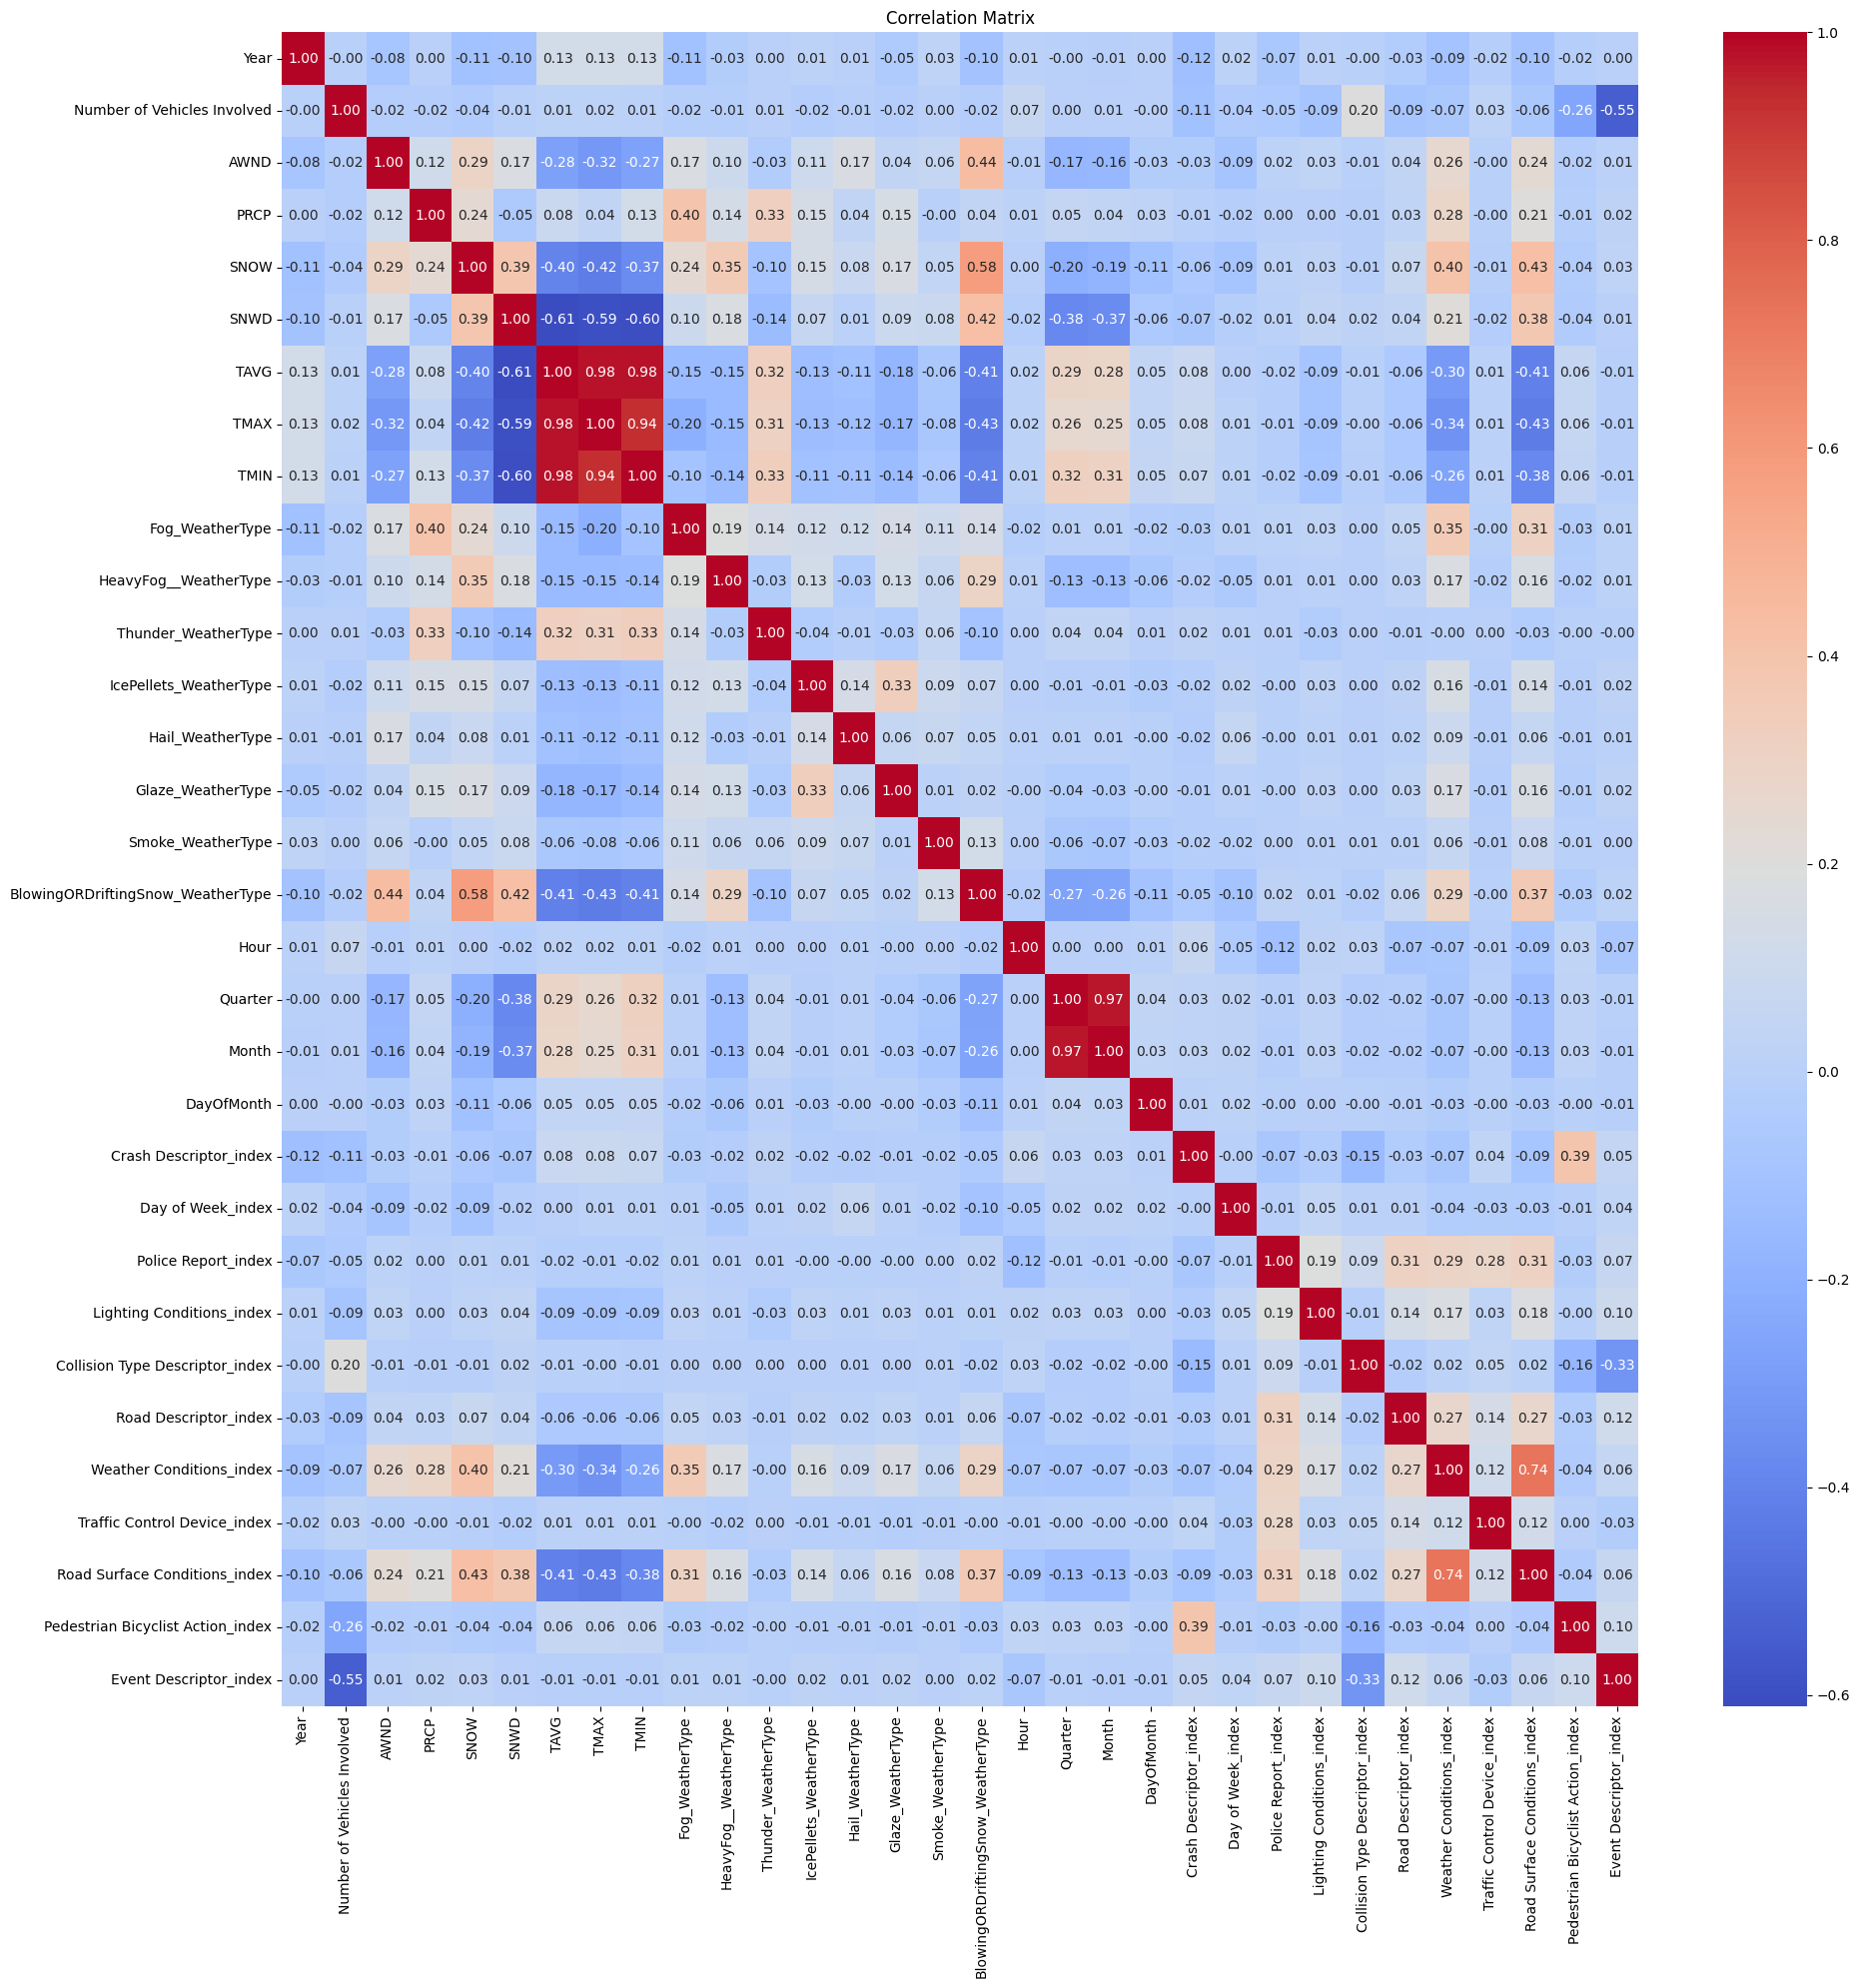

In [ ]:
# Set figure size for the heatmap
plt.figure(figsize=(20, 20))

# Plotting the heatmap
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

**Conclusion**<br>
1. Time and date are slightly related to the weather condition (Snow/Wind, Temperature)
2. Accident information is slightly related to the traffic/pedestrian information.
3. The relationship between Event Descriptor and the Number of vehicles involved has the highest (negative) correlation.
4. Environmental factors is slightly related to the weather conditions.
5. The relationship between road surface conditions and the weather conditions has the highest (positive) correlation.

# PART 3 Modeling

| Task                 | Model Type           | Objective                                                                                         |
|----------------------|----------------------|--------------------------------------------------------------------------------------------------|
| Supervised Learning     | Classification-Predictive Modeling  | 1. Can we predict the time of that day of accidents, given the road information, weather, etc? <br> 2. Can we predict the event descriptor based on time, road conditions, or weather conditions? |
| Unsupervised Learning| Clustering           | 1. Are there any specific patterns in accidents during certain weather, lighting, or road surface conditions? <br> 2. Are there distinct groups or clusters of accidents based on similar conditions? |
| Unsupervised Learning| Anomaly Detection    | 1. Can we identify anomalies or outliers in accident occurrences based on the collected attributes? |


## 1. Predictive Modeling
This step will answer the following questions using predictive modeling - classification algorithms.

1. Can we predict the time of that day of accidents, given the road information, weather, etc?
2. Can we predict the event descriptor based on time, road conditions, or weather conditions?

### **Preprocessing**
This step includes cleansing the uploaded dataset before data analysis and machine learning parts.

**1) Drop the unnecessary columns** <br>
Since the time is too detail in our dataset, we could divide them to 24 categories based on each hours.

In [ ]:
# List of columns to keep
columns_to_keep = [
    "Time",
    "Day of Week",
    "Date",
    "Lighting Conditions",
    "Weather Conditions",
    "Road Surface Conditions",
    "AWND",
    "PRCP",
    "SNOW",
    "SNWD",
    "TAVG",
    "TMAX",
    "TMIN",
    "Fog_WeatherType",
    "HeavyFog__WeatherType",
    "Thunder_WeatherType",
    "IcePellets_WeatherType",
    "Hail_WeatherType",
    "Glaze_WeatherType",
    "Smoke_WeatherType",
    "BlowingORDriftingSnow_WeatherType",
    "Event Descriptor"
]

# Select only the columns you want to keep
filtered_df = df.select(*columns_to_keep)


In [ ]:
filtered_df.show(2)

+-------------------+-----------+----------+-------------------+------------------+-----------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+--------------------+
|               Time|Day of Week|      Date|Lighting Conditions|Weather Conditions|Road Surface Conditions| AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSnow_WeatherType|    Event Descriptor|
+-------------------+-----------+----------+-------------------+------------------+-----------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+--------------------+
|

**2) Categorize variables** <br>
Since many machine learning algorithms expect numerical inputs, categorization allows us to transform categorical variables into a format that the algorithms can work with. It is also for the interpretability of analysis and the improvement of model performance.


**`Time`**<br>
Categorize the `Time` variable as follows.<br>

| Time Interval         | Encoded Value |
|-----------------------|---------------|
| 00:00:00 ~ 06:00:00 | 0             |
| 06:00:00 ~ 12:00:00 | 1             |
| 12:00:00 ~ 18:00:00 | 2             |
| 18:00:00 ~ 24:00:00 | 3             |


In [ ]:
filtered_df.printSchema()

root
 |-- Time: timestamp (nullable = true)
 |-- Day of Week: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Lighting Conditions: string (nullable = true)
 |-- Weather Conditions: string (nullable = true)
 |-- Road Surface Conditions: string (nullable = true)
 |-- AWND: double (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- SNOW: double (nullable = true)
 |-- SNWD: double (nullable = true)
 |-- TAVG: integer (nullable = true)
 |-- TMAX: integer (nullable = true)
 |-- TMIN: integer (nullable = true)
 |-- Fog_WeatherType: integer (nullable = true)
 |-- HeavyFog__WeatherType: integer (nullable = true)
 |-- Thunder_WeatherType: integer (nullable = true)
 |-- IcePellets_WeatherType: integer (nullable = true)
 |-- Hail_WeatherType: integer (nullable = true)
 |-- Glaze_WeatherType: integer (nullable = true)
 |-- Smoke_WeatherType: integer (nullable = true)
 |-- BlowingORDriftingSnow_WeatherType: integer (nullable = true)
 |-- Event Descriptor: string (nullable = tr

In [ ]:
from pyspark.sql.functions import col, hour
# Convert the 'Time' column to timestamp
filtered_df = filtered_df.withColumn("Time", col("Time").cast("timestamp"))

# Create 'Hour_Category' for 2-hour blocks
filtered_df = filtered_df.withColumn("Hour_Category", (hour(col("Time")) / 6).cast('integer'))

# Keep only the clock time without the date
filtered_df = filtered_df.withColumn("Clock_Time", date_format("Time", "HH:mm:ss"))
filtered_df = filtered_df.drop("Time")

# Show the DataFrame to verify the transformation
filtered_df.show()

+-----------+----------+-------------------+------------------+-----------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+--------------------+-------------+----------+
|Day of Week|      Date|Lighting Conditions|Weather Conditions|Road Surface Conditions| AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSnow_WeatherType|    Event Descriptor|Hour_Category|Clock_Time|
+-----------+----------+-------------------+------------------+-----------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+--------------------+------------

**3) Handling Missing Values:**

There is no missing value in our selected varaibles.

In [ ]:
# Count missing values for each column
missing_values = filtered_df.agg(*[sql_sum(col(c).isNull().cast('int')).alias(c) for c in filtered_df.columns])

# Display the result
missing_values.show()

+-----------+----+-------------------+------------------+-----------------------+----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+----------------+-------------+----------+
|Day of Week|Date|Lighting Conditions|Weather Conditions|Road Surface Conditions|AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSnow_WeatherType|Event Descriptor|Hour_Category|Clock_Time|
+-----------+----+-------------------+------------------+-----------------------+----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+----------------+-------------+----------+
|          0|   0| 

In [ ]:
# Get the number of rows
num_rows = filtered_df.count()

# Get the number of columns
num_columns = len(filtered_df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 23638
Number of columns: 23


In [ ]:
# Specify the path where you want to save the CSV file
output_path = "/content/drive/MyDrive/IST718/final project/time_df.csv"

# Save the DataFrame to a CSV file
filtered_df.write.csv(output_path, header=True, mode="overwrite")

**4) Encoding & Transfoming** <br>
Transform `Lighting Conditions`, `Weather Conditions`, and `Road Surface Condition`.

In [ ]:
# Define StringIndexer for categorical columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in ["Lighting Conditions", "Weather Conditions", "Road Surface Conditions"]
]

# Define OneHotEncoder for indexed columns
encoders = [
    OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol()))
    for indexer in indexers
]

In [ ]:
# Define the stages of the pipeline
stages = indexers + encoders

# Set up the pipeline
pipeline = Pipeline(stages=stages)

In [ ]:
# Fit the pipeline to the data
pipeline_model = pipeline.fit(filtered_df)

# Transform the data
filtered_df_encoded = pipeline_model.transform(filtered_df)

The result '`filtered_df_encoded`' will have the original columns plus the indexed and encoded columns

In [ ]:
filtered_df_encoded.show()

+-----------+----------+-------------------+------------------+-----------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+--------------------+-------------+----------+---------------------------+--------------------------+-------------------------------+-----------------------------------+----------------------------------+---------------------------------------+
|Day of Week|      Date|Lighting Conditions|Weather Conditions|Road Surface Conditions| AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSnow_WeatherType|    Event Descriptor|Hour_Category|Clock_Time|Lighting Conditions_indexed|Weather Conditions_indexed|Road Surface Conditions_indexed|Lighting Conditions_indexed_encoded|Weat

Tranform `day_of_week` using onecoding.

In [ ]:
# String Indexing
day_of_week_indexer = StringIndexer(inputCol="Day of Week", outputCol="Day_of_Week_Index")

# One-Hot Encoding
day_of_week_encoder = OneHotEncoder(inputCol="Day_of_Week_Index", outputCol="Day_of_Week_Vec")

In [ ]:
# Set up the pipeline
pipeline = Pipeline(stages=[day_of_week_indexer, day_of_week_encoder])

In [ ]:
# Fit the pipeline to the data
pipeline_model = pipeline.fit(filtered_df_encoded)

# Transform the data
filtered_df_transformed = pipeline_model.transform(filtered_df_encoded)

`filtered_df_transformed` contains a new column "Day_of_Week_Vec" that can be used for classification.




In [ ]:
filtered_df_transformed.show()

+-----------+----------+-------------------+------------------+-----------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+--------------------+-------------+----------+---------------------------+--------------------------+-------------------------------+-----------------------------------+----------------------------------+---------------------------------------+-----------------+---------------+
|Day of Week|      Date|Lighting Conditions|Weather Conditions|Road Surface Conditions| AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSnow_WeatherType|    Event Descriptor|Hour_Category|Clock_Time|Lighting Conditions_indexed|Weather Conditions_indexed|Road Surface Conditions_indexed|Lighti

Transform the `Event Desciptor` to integer.

In [ ]:
# Step 1: String Indexing
indexer = StringIndexer(inputCol="Event Descriptor", outputCol="Event_Index")

# Fit and transform to create the indexed column
df_indexed = indexer.fit(filtered_df_transformed).transform(filtered_df_transformed)

In [ ]:
df_indexed = df_indexed.withColumn("Event_Index", col("Event_Index").cast("integer"))

In [ ]:
df_indexed.show()

+-----------+----------+-------------------+------------------+-----------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+--------------------+-------------+----------+---------------------------+--------------------------+-------------------------------+-----------------------------------+----------------------------------+---------------------------------------+-----------------+---------------+-----------+
|Day of Week|      Date|Lighting Conditions|Weather Conditions|Road Surface Conditions| AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSnow_WeatherType|    Event Descriptor|Hour_Category|Clock_Time|Lighting Conditions_indexed|Weather Conditions_indexed|Road Surface Conditions_in

Transform '`PRCP`', '`SNOW`', and '`SNWD`'

In [ ]:
df_transformed = df_indexed.withColumn("Log_PRCP", log1p("PRCP"))
df_transformed = df_transformed.withColumn("Log_SNOW", log1p("SNOW"))
df_transformed = df_transformed.withColumn("Log_SNWD", log1p("SNWD"))

In [ ]:
df_transformed = df_transformed.withColumn("Zero_PRCP", when(col("PRCP") == 0, 1).otherwise(0))
df_transformed = df_transformed.withColumn("Zero_SNOW", when(col("SNOW") == 0, 1).otherwise(0))
df_transformed = df_transformed.withColumn("Zero_SNWD", when(col("SNWD") == 0, 1).otherwise(0))

Exclude the original 'PRCP', 'SNOW', and 'SNWD' columns and include the new log and zero indicator columns

### **Prediction**


**1. Time Prediction**

In here, our dependent variables is Hour_category; And the dataset for predict time names time_df, which is select from df_indexed dataset.

In [ ]:
# List of columns to keep
time_columns_to_keep = [
    "Hour_Category",
    "Day_of_Week_Vec",
    "Lighting Conditions_indexed_encoded",
    "Weather Conditions_indexed_encoded",
    "Road Surface Conditions_indexed_encoded",
    "Lighting Conditions_indexed",
    "Weather Conditions_indexed",
    "Road Surface Conditions_indexed",
    "AWND",
    "Log_PRCP",
    "Log_SNOW",
    "Log_SNWD",
    "Zero_PRCP",
    "Zero_SNOW",
    "Zero_SNWD",
    "TAVG",
    "TMAX",
    "TMIN",
    "Fog_WeatherType",
    "HeavyFog__WeatherType",
    "Thunder_WeatherType",
    "IcePellets_WeatherType",
    "Hail_WeatherType",
    "Glaze_WeatherType",
    "Smoke_WeatherType",
    "BlowingORDriftingSnow_WeatherType"
]

# Select only the columns you want to keep
time_df = df_transformed.select(*time_columns_to_keep)
time_df.show()

+-------------+---------------+-----------------------------------+----------------------------------+---------------------------------------+---------------------------+--------------------------+-------------------------------+-----+--------------------+-------------------+------------------+---------+---------+---------+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+
|Hour_Category|Day_of_Week_Vec|Lighting Conditions_indexed_encoded|Weather Conditions_indexed_encoded|Road Surface Conditions_indexed_encoded|Lighting Conditions_indexed|Weather Conditions_indexed|Road Surface Conditions_indexed| AWND|            Log_PRCP|           Log_SNOW|          Log_SNWD|Zero_PRCP|Zero_SNOW|Zero_SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDrifting

**2. Event Type Prediction**

After we get the predicted time, we could use the predicted time to predict the event type, such as because deer, motor, etc. And Relevant departments can take some measures. This is a progressive relationship with time
.


In here, our dependent variables is Event_Index; And the dataset for predict Event type names event_df, which is select from df_indexed dataset.

In [ ]:
# List of columns to keep
event_columns_to_keep = [
    "Event_Index",
    "Hour_Category",
    "Day_of_Week_Vec",
    "Lighting Conditions_indexed_encoded",
    "Weather Conditions_indexed_encoded",
    "Road Surface Conditions_indexed_encoded",
    "Lighting Conditions_indexed",
    "Weather Conditions_indexed",
    "Road Surface Conditions_indexed",
    "AWND",
    "Log_PRCP",
    "Log_SNOW",
    "Log_SNWD",
    "Zero_PRCP",
    "Zero_SNOW",
    "Zero_SNWD",
    "TAVG",
    "TMAX",
    "TMIN",
    "Fog_WeatherType",
    "HeavyFog__WeatherType",
    "Thunder_WeatherType",
    "IcePellets_WeatherType",
    "Hail_WeatherType",
    "Glaze_WeatherType",
    "Smoke_WeatherType",
    "BlowingORDriftingSnow_WeatherType"
]

# Select only the columns you want to keep
event_df = df_transformed.select(*event_columns_to_keep)
event_df.show()

+-----------+-------------+---------------+-----------------------------------+----------------------------------+---------------------------------------+---------------------------+--------------------------+-------------------------------+-----+--------------------+-------------------+------------------+---------+---------+---------+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+
|Event_Index|Hour_Category|Day_of_Week_Vec|Lighting Conditions_indexed_encoded|Weather Conditions_indexed_encoded|Road Surface Conditions_indexed_encoded|Lighting Conditions_indexed|Weather Conditions_indexed|Road Surface Conditions_indexed| AWND|            Log_PRCP|           Log_SNOW|          Log_SNWD|Zero_PRCP|Zero_SNOW|Zero_SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_Weath

### **Feature Engineering**

`Hour_category`

Split the dataset into train and test sets

In [ ]:
# Split the data into training and test sets
(training, testing) = time_df.randomSplit([0.8, 0.2], seed=99)
training.show()

+-------------+---------------+-----------------------------------+----------------------------------+---------------------------------------+---------------------------+--------------------------+-------------------------------+-----+-------------------+-------------------+------------------+---------+---------+---------+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+
|Hour_Category|Day_of_Week_Vec|Lighting Conditions_indexed_encoded|Weather Conditions_indexed_encoded|Road Surface Conditions_indexed_encoded|Lighting Conditions_indexed|Weather Conditions_indexed|Road Surface Conditions_indexed| AWND|           Log_PRCP|           Log_SNOW|          Log_SNWD|Zero_PRCP|Zero_SNOW|Zero_SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSn

Scale features

In [ ]:
#Build a pipeline
# Define the feature columns
feature_cols = [col for col in training.columns if col != 'Hour_Category']

# Assemble the features
va = VectorAssembler(inputCols=feature_cols, outputCol='features')

In [ ]:
sc = StandardScaler(withMean = True,
                           inputCol = 'features',
                            outputCol = 'zfeatures')

`Event`

In [ ]:
# Split the data into training and test sets
(training_event, testing_event) = event_df.randomSplit([0.8, 0.2], seed=99)
training_event.show()

+-----------+-------------+---------------+-----------------------------------+----------------------------------+---------------------------------------+---------------------------+--------------------------+-------------------------------+-----+--------------------+-------------------+------------------+---------+---------+---------+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+
|Event_Index|Hour_Category|Day_of_Week_Vec|Lighting Conditions_indexed_encoded|Weather Conditions_indexed_encoded|Road Surface Conditions_indexed_encoded|Lighting Conditions_indexed|Weather Conditions_indexed|Road Surface Conditions_indexed| AWND|            Log_PRCP|           Log_SNOW|          Log_SNWD|Zero_PRCP|Zero_SNOW|Zero_SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_Weath

### **Modeling**

`Time`

**PART 1: Logistic Regression**

In [ ]:
# Define the classifier
lr = LogisticRegression(featuresCol='features', labelCol='Hour_Category')
#lr = LogisticRegression(featuresCol="pcaFeatures", labelCol="Hour_Category")
# Set up the pipeline
lr_pipeline = Pipeline(stages=[va,sc,lr])

# Fit the pipeline
lr_model = lr_pipeline.fit(training)


Get the feature importance of the logistic regression model

In [ ]:
import pandas as pd
from pyspark.ml.classification import LogisticRegressionModel

# Extract the Logistic Regression model from the pipeline
lr_trained_model = lr_model.stages[-1]

# Verify that we have the correct model type
if not isinstance(lr_trained_model, LogisticRegressionModel):
    raise TypeError("The last stage is not a LogisticRegressionModel. It is: {}".format(type(lr_trained_model)))

try:
    # For multinomial logistic regression, use coefficientMatrix
    coefficient_matrix = lr_trained_model.coefficientMatrix

    # Convert the coefficientMatrix to array
    coefficient_array = coefficient_matrix.toArray()

    # Match the coefficients with feature names
    feature_names = va.getInputCols()

    # Initialize an empty list to store feature importance for all classes
    all_feature_importances = []

    # If you want to show the importance of features for each class
    for class_idx in range(coefficient_matrix.numRows):
        feature_importance = [(feature, coeff) for feature, coeff in zip(feature_names, coefficient_array[class_idx])]
        sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

        # Extend the list with feature importances for the current class
        all_feature_importances.extend(sorted_features)

    # Now create a pandas DataFrame
    feature_importance_df = pd.DataFrame(all_feature_importances, columns=['Feature', 'Importance']).drop_duplicates().reset_index(drop=True)
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)


    # Now create a pandas DataFrame
    feature_importance_df = pd.DataFrame(all_feature_importances, columns=['Feature', 'Importance'])

    # Group by 'Feature' to calculate the mean importance for duplicated features
    feature_importance_df = feature_importance_df.groupby('Feature', as_index=False).max()

    # Sort the DataFrame by 'Importance' in descending order
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

    # Display the DataFrame
    print(feature_importance_df)

except AttributeError as e:
    print("An error occurred:", e)



                                    Feature  Importance
0         BlowingORDriftingSnow_WeatherType    2.881844
1                                  Log_SNOW    2.159588
2                                      AWND    1.800346
3                                  Log_SNWD    1.781653
4                                      TMIN    1.464530
5                                      TMAX    1.453013
6           Road Surface Conditions_indexed    1.451595
7                         Smoke_WeatherType    1.394980
8                           Fog_WeatherType    1.341995
9                          Hail_WeatherType    0.960865
10                                     TAVG    0.834987
11                        Glaze_WeatherType    0.831405
12  Road Surface Conditions_indexed_encoded    0.741320
13      Lighting Conditions_indexed_encoded    0.644817
14                                Zero_SNWD    0.634253
15              Lighting Conditions_indexed    0.577557
16       Weather Conditions_indexed_encoded    0

**PART 2: Decision Tree**

In [ ]:
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Hour_Category')
#dt = DecisionTreeClassifier(featuresCol="pcaFeatures", labelCol="Hour_Category")
dt_model = Pipeline(stages=[va, sc, dt]).fit(training)

In [ ]:
# Extract the trained Decision Tree model from the pipeline
trained_dt_model = dt_model.stages[-1]

# Get feature importances
feature_importances = trained_dt_model.featureImportances

# Map feature importances to feature names
feature_names = va.getInputCols()
importances_list = [(feature, feature_importances[idx]) for idx, feature in enumerate(feature_names)]

# Convert to pandas DataFrame for better visualization and sort by importance
feature_importance_df = pd.DataFrame(importances_list, columns=["Feature", "Importance"])
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

print(feature_importance_df)

                                    Feature  Importance
0           Road Surface Conditions_indexed    0.763765
1                                      AWND    0.054783
2                                  Log_SNOW    0.021405
3                                  Log_PRCP    0.011470
4                     HeavyFog__WeatherType    0.005501
5                Weather Conditions_indexed    0.002987
6                           Day_of_Week_Vec    0.000623
7                                      TMAX    0.000000
8                         Smoke_WeatherType    0.000000
9                         Glaze_WeatherType    0.000000
10                         Hail_WeatherType    0.000000
11                   IcePellets_WeatherType    0.000000
12                      Thunder_WeatherType    0.000000
13                          Fog_WeatherType    0.000000
14                                     TMIN    0.000000
15                                Zero_SNOW    0.000000
16                                     TAVG    0

**PART 3: Random Forest**

In [ ]:
rf = RandomForestClassifier(featuresCol='features', labelCol='Hour_Category')
#rf = RandomForestClassifier(featuresCol="pcaFeatures", labelCol="Hour_Category")
rf_model = Pipeline(stages=[va, sc, rf]).fit(training)

Get the feature importance of Random Forest Model

In [ ]:
from pyspark.ml.classification import RandomForestClassificationModel
import pandas as pd

# Check if rf_model is a RandomForestClassificationModel
if isinstance(rf_model.stages[-1], RandomForestClassificationModel):
    # Extract feature importances
    importances = rf_model.stages[-1].featureImportances

    # Map feature importances to feature names
    feature_names = va.getInputCols()
    importances_list = [(feature, importances[idx]) for idx, feature in enumerate(feature_names)]

    # Convert to pandas DataFrame for better visualization and sort by importance
    importances_df = pd.DataFrame(importances_list, columns=["Feature", "Importance"])
    importances_df = importances_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

    print(importances_df)
else:
    print("The last stage of rf_model is not a RandomForestClassificationModel.")


                                    Feature  Importance
0           Road Surface Conditions_indexed    0.253962
1                                      AWND    0.226246
2                                  Log_SNOW    0.020128
3                                  Log_SNWD    0.017259
4                                  Log_PRCP    0.011348
5                                      TMAX    0.009406
6                Weather Conditions_indexed    0.007520
7                    IcePellets_WeatherType    0.007266
8                     HeavyFog__WeatherType    0.005540
9                          Hail_WeatherType    0.005427
10                                Zero_SNOW    0.001980
11                                     TAVG    0.001658
12  Road Surface Conditions_indexed_encoded    0.000788
13                                Zero_PRCP    0.000703
14                      Thunder_WeatherType    0.000673
15       Weather Conditions_indexed_encoded    0.000536
16                          Day_of_Week_Vec    0

**PART 4: SVM**

In [ ]:
# Start the SparkSession
spark = SparkSession.builder.appName("SVMExample").getOrCreate()



# Define the stages of the pipeline
feature_cols = [col for col in training.columns if col != 'Hour_Category']
# Assemble the features
va = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Scale the features
sc = StandardScaler(inputCol='features', outputCol='scaledFeatures', withMean=True)

# Define the SVM classifier
svm = LinearSVC(maxIter=10, regParam=0.05, featuresCol='features', labelCol='Hour_Category')

# Instantiate the One Vs Rest Classifier with the correct label column name.
ovr = OneVsRest(classifier=svm, labelCol='Hour_Category')

# Define the pipeline with the correct stages
pipeline = Pipeline(stages=[va, sc, ovr])

# Fit the pipeline to the training data
ovrModel = pipeline.fit(training)

Get the feature importance of SVM model

In [ ]:
# Extract the OneVsRestModel from the pipeline
oneVsRestClassifier = ovrModel.stages[-1]

# Assuming that the SVM classifiers are LinearSVC and they have coefficients attribute
# (Note: LinearSVC in PySpark does not directly provide feature importance or coefficients,
# this is a simplification for the sake of example)

# Initialize an empty DataFrame to store feature importances for each class
importances_df_list = []

# Extract classifier models from the OneVsRest model
classifiers = oneVsRestClassifier.models

for idx, classifier in enumerate(classifiers):
    # Extract the coefficients for this classifier
    coefficients = classifier.coefficients.toArray()  # SVM coefficients act as feature importances

    # Create a DataFrame with feature names and coefficients
    class_importance_df = pd.DataFrame(list(zip(feature_cols, coefficients)), columns=["Feature", f"Class_{idx}_Importance"])

    # Append the DataFrame to the list
    importances_df_list.append(class_importance_df)

# Concatenate the DataFrames for all classes
feature_importance_df = pd.concat(importances_df_list, axis=1)

# Remove the duplicated 'Feature' columns
feature_importance_df = feature_importance_df.loc[:,~feature_importance_df.columns.duplicated()]

# Define the sorting order: first by 'Class_0_Importance', then 'Class_1_Importance', etc.
sort_columns = [f"Class_{idx}_Importance" for idx in range(len(classifiers))]

# Now sort the DataFrame by each class's importance in descending order.
# We have to sort by each column one by one, starting from the least significant to the most significant
for sort_column in reversed(sort_columns):
    feature_importance_df.sort_values(by=sort_column, ascending=False, inplace=True)

# Reset index of the DataFrame after sorting
feature_importance_df.reset_index(drop=True, inplace=True)

# Show the DataFrame
print(feature_importance_df)


                                    Feature  Class_0_Importance  \
0                                      AWND            0.168245   
1                                  Log_SNWD            0.110179   
2                         Smoke_WeatherType            0.072827   
3                    IcePellets_WeatherType            0.045487   
4                                  Log_PRCP            0.035958   
5                                 Zero_PRCP            0.022321   
6                                      TMAX            0.021097   
7                                      TMIN            0.001757   
8                Weather Conditions_indexed           -0.000000   
9                          Hail_WeatherType           -0.000000   
10                                Zero_SNOW            0.000000   
11                      Thunder_WeatherType           -0.013649   
12                                Zero_SNWD           -0.019470   
13        BlowingORDriftingSnow_WeatherType           -0.03189

`Event`

**PART 1: Logistic Regression**

In [ ]:
# Define the feature columns
feature_cols = [col for col in training_event.columns if col != 'Event_Index']

# Assemble the features
va = VectorAssembler(inputCols=feature_cols, outputCol='features')

sc = StandardScaler(withMean=True, inputCol='features', outputCol='zfeatures')


In [ ]:

# Define the classifier with the correct label column
lr = LogisticRegression(featuresCol='zfeatures', labelCol='Event_Index')

# Set up the pipeline
lr_pipeline = Pipeline(stages=[va, sc, lr])

# Fit the pipeline
lr_model = lr_pipeline.fit(training_event)

In [ ]:

# Extract the Logistic Regression model from the pipeline
lr_trained_model = lr_model.stages[-1]

# Verify that we have the correct model type
if not isinstance(lr_trained_model, LogisticRegressionModel):
    raise TypeError("The last stage is not a LogisticRegressionModel. It is: {}".format(type(lr_trained_model)))

try:
    # For multinomial logistic regression, use coefficientMatrix
    coefficient_matrix = lr_trained_model.coefficientMatrix

    # Convert the coefficientMatrix to array
    coefficient_array = coefficient_matrix.toArray()

    # Match the coefficients with feature names
    feature_names = va.getInputCols()

    # Initialize an empty list to store feature importance for all classes
    all_feature_importances = []

    # If you want to show the importance of features for each class
    for class_idx in range(coefficient_matrix.numRows):
        feature_importance = [(feature, coeff) for feature, coeff in zip(feature_names, coefficient_array[class_idx])]
        sorted_features = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

        # Extend the list with feature importances for the current class
        all_feature_importances.extend(sorted_features)

    # Now create a pandas DataFrame
    feature_importance_df = pd.DataFrame(all_feature_importances, columns=['Feature', 'Importance']).drop_duplicates().reset_index(drop=True)
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)


    # Now create a pandas DataFrame
    feature_importance_df = pd.DataFrame(all_feature_importances, columns=['Feature', 'Importance'])

    # Group by 'Feature' to calculate the mean importance for duplicated features
    feature_importance_df = feature_importance_df.groupby('Feature', as_index=False).max()

    # Sort the DataFrame by 'Importance' in descending order
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

    # Display the DataFrame
    print(feature_importance_df)

except AttributeError as e:
    print("An error occurred:", e)



                                    Feature  Importance
0                             Hour_Category    1.087090
1                                  Log_PRCP    0.878628
2        Weather Conditions_indexed_encoded    0.801362
3                    IcePellets_WeatherType    0.788101
4                                      TAVG    0.719415
5                                  Log_SNWD    0.674663
6   Road Surface Conditions_indexed_encoded    0.620737
7                                 Zero_PRCP    0.603256
8                     HeavyFog__WeatherType    0.526484
9                                  Log_SNOW    0.512978
10              Lighting Conditions_indexed    0.501700
11                         Hail_WeatherType    0.486773
12                                Zero_SNWD    0.420889
13                        Glaze_WeatherType    0.414685
14          Road Surface Conditions_indexed    0.414514
15                                     TMIN    0.394783
16               Weather Conditions_indexed    0

**PART 2: Decision Tree**

In [ ]:
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Event_Index')
#dt = DecisionTreeClassifier(featuresCol="pcaFeatures", labelCol="Hour_Category")
dt_model = Pipeline(stages=[va, sc, dt]).fit(training_event)

In [ ]:
# Extract the trained Decision Tree model from the pipeline
trained_dt_model = dt_model.stages[-1]

# Get feature importances
feature_importances = trained_dt_model.featureImportances

# Map feature importances to feature names
feature_names = va.getInputCols()
importances_list = [(feature, feature_importances[idx]) for idx, feature in enumerate(feature_names)]

# Convert to pandas DataFrame for better visualization and sort by importance
feature_importance_df = pd.DataFrame(importances_list, columns=["Feature", "Importance"])
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

print(feature_importance_df)

                                    Feature  Importance
0                             Hour_Category    0.587147
1        Weather Conditions_indexed_encoded    0.010660
2                         Glaze_WeatherType    0.008398
3                                 Zero_SNWD    0.000000
4                         Smoke_WeatherType    0.000000
5                          Hail_WeatherType    0.000000
6                    IcePellets_WeatherType    0.000000
7                       Thunder_WeatherType    0.000000
8                     HeavyFog__WeatherType    0.000000
9                           Fog_WeatherType    0.000000
10                                     TMIN    0.000000
11                                     TMAX    0.000000
12                                     TAVG    0.000000
13                                Zero_SNOW    0.000000
14                          Day_of_Week_Vec    0.000000
15                                Zero_PRCP    0.000000
16                                 Log_SNWD    0

**PART 3: Random Forest**

In [ ]:
rf = RandomForestClassifier(featuresCol='features', labelCol='Event_Index')
#rf = RandomForestClassifier(featuresCol="pcaFeatures", labelCol="Hour_Category")
rf_model = Pipeline(stages=[va, sc, rf]).fit(training_event)

In [ ]:

# Check if rf_model is a RandomForestClassificationModel
if isinstance(rf_model.stages[-1], RandomForestClassificationModel):
    # Extract feature importances
    importances = rf_model.stages[-1].featureImportances

    # Map feature importances to feature names
    feature_names = va.getInputCols()
    importances_list = [(feature, importances[idx]) for idx, feature in enumerate(feature_names)]

    # Convert to pandas DataFrame for better visualization and sort by importance
    importances_df = pd.DataFrame(importances_list, columns=["Feature", "Importance"])
    importances_df = importances_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

    print(importances_df)
else:
    print("The last stage of rf_model is not a RandomForestClassificationModel.")

                                    Feature  Importance
0                             Hour_Category    0.133977
1           Road Surface Conditions_indexed    0.115942
2                                      AWND    0.057644
3                    IcePellets_WeatherType    0.048688
4                                  Log_SNWD    0.038713
5                                      TAVG    0.030784
6                                      TMIN    0.017726
7                     HeavyFog__WeatherType    0.015978
8                                 Zero_SNWD    0.010707
9                                 Zero_SNOW    0.010284
10               Weather Conditions_indexed    0.006253
11                          Fog_WeatherType    0.006075
12                                 Log_SNOW    0.005460
13                                 Log_PRCP    0.005051
14                                     TMAX    0.003465
15                                Zero_PRCP    0.003147
16                        Glaze_WeatherType    0

**PART 4: SVM**

In [ ]:

# Define the stages of the pipeline
feature_cols = [col for col in training.columns if col != 'Event_Index']
# Assemble the features
va = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Scale the features
sc = StandardScaler(inputCol='features', outputCol='scaledFeatures', withMean=True)

# Define the SVM classifier
svm = LinearSVC(maxIter=10, regParam=0.05, featuresCol='features', labelCol='Event_Index')

# Instantiate the One Vs Rest Classifier with the correct label column name.
ovr = OneVsRest(classifier=svm, labelCol='Event_Index')

# Define the pipeline with the correct stages
pipeline = Pipeline(stages=[va, sc, ovr])

# Fit the pipeline to the training data
ovrModel = pipeline.fit(training_event)

In [ ]:
# Extract the OneVsRestModel from the pipeline
oneVsRestClassifier = ovrModel.stages[-1]

# Assuming that the SVM classifiers are LinearSVC and they have coefficients attribute
# (Note: LinearSVC in PySpark does not directly provide feature importance or coefficients,
# this is a simplification for the sake of example)

# Initialize an empty DataFrame to store feature importances for each class
importances_df_list = []

# Extract classifier models from the OneVsRest model
classifiers = oneVsRestClassifier.models

for idx, classifier in enumerate(classifiers):
    # Extract the coefficients for this classifier
    coefficients = classifier.coefficients.toArray()  # SVM coefficients act as feature importances

    # Create a DataFrame with feature names and coefficients
    class_importance_df = pd.DataFrame(list(zip(feature_cols, coefficients)), columns=["Feature", f"Class_{idx}_Importance"])

    # Append the DataFrame to the list
    importances_df_list.append(class_importance_df)

# Concatenate the DataFrames for all classes
feature_importance_df = pd.concat(importances_df_list, axis=1)

# Remove the duplicated 'Feature' columns
feature_importance_df = feature_importance_df.loc[:,~feature_importance_df.columns.duplicated()]

# Define the sorting order: first by 'Class_0_Importance', then 'Class_1_Importance', etc.
sort_columns = [f"Class_{idx}_Importance" for idx in range(len(classifiers))]

# Now sort the DataFrame by each class's importance in descending order.
# We have to sort by each column one by one, starting from the least significant to the most significant
for sort_column in reversed(sort_columns):
    feature_importance_df.sort_values(by=sort_column, ascending=False, inplace=True)

# Reset index of the DataFrame after sorting
feature_importance_df.reset_index(drop=True, inplace=True)

# Show the DataFrame
print(feature_importance_df)


                                    Feature  Class_0_Importance  \
0         BlowingORDriftingSnow_WeatherType            0.728255   
1                           Fog_WeatherType            0.205976   
2                         Smoke_WeatherType            0.044573   
3                                  Log_PRCP            0.033360   
4                                      TMAX            0.029635   
5                     HeavyFog__WeatherType            0.012153   
6                                 Zero_SNWD            0.011861   
7       Lighting Conditions_indexed_encoded            0.011574   
8                Weather Conditions_indexed            0.011402   
9                                      TAVG            0.009981   
10  Road Surface Conditions_indexed_encoded            0.009501   
11                         Hail_WeatherType            0.009031   
12       Weather Conditions_indexed_encoded            0.007645   
13                          Day_of_Week_Vec            0.00628

### **Evaluation**

`Time`



In [ ]:
lr_predictions = lr_model.transform(testing)
dt_predictions = dt_model.transform(testing)
rf_predictions = rf_model.transform(testing)
svm_predictions = ovrModel.transform(testing)

# Set up the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='Hour_Category')

# Evaluate accuracy for each model
lr_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
rf_accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
svm_accuracy = evaluator.evaluate(svm_predictions, {evaluator.metricName: "accuracy"})

# Print the accuracy for each model

print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")

Logistic Regression Accuracy: 0.10115667718191378
Decision Tree Accuracy: 0.10031545741324921
Random Forest Accuracy: 0.10136698212407992
SVM Accuracy: 0.10136698212407992


In [ ]:
# Evaluate precision for each model
lr_precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
rf_precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"})
svm_precision = evaluator.evaluate(svm_predictions, {evaluator.metricName: "weightedPrecision"})

# Evaluate recall for each model
lr_recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})
rf_recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"})
svm_recall = evaluator.evaluate(svm_predictions, {evaluator.metricName: "weightedRecall"})

# Evaluate f1 score for each model
lr_f1 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "f1"})
dt_f1 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})
rf_f1 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})
svm_f1 = evaluator.evaluate(svm_predictions, {evaluator.metricName: "f1"})

# Print the additional metrics for each model
print(f"Logistic Regression Precision: {lr_precision}")
print(f"Decision Tree Precision: {dt_precision}")
print(f"Random Forest Precision: {rf_precision}")
print(f"SVM Precision: {svm_precision}")

print(f"Logistic Regression Recall: {lr_recall}")
print(f"Decision Tree Recall: {dt_recall}")
print(f"Random Forest Recall: {rf_recall}")
print(f"SVM Recall: {svm_recall}")

print(f"Logistic Regression F1 Score: {lr_f1}")
print(f"Decision Tree F1 Score: {dt_f1}")
print(f"Random Forest F1 Score: {rf_f1}")
print(f"SVM F1 Score: {svm_f1}")


Logistic Regression Precision: 0.01025826181394539
Decision Tree Precision: 0.010179379046986552
Random Forest Precision: 0.010275265064943539
SVM Precision: 0.010275265064943539
Logistic Regression Recall: 0.10115667718191378
Decision Tree Recall: 0.10031545741324921
Random Forest Recall: 0.10136698212407992
SVM Recall: 0.10136698212407992
Logistic Regression F1 Score: 0.01862751419357495
Decision Tree F1 Score: 0.018483199722165947
Random Forest F1 Score: 0.018659112233647707
SVM F1 Score: 0.018659112233647707


In [ ]:
# Create a list of Rows containing metrics
rows = [
    Row(model='Logistic Regression', Accuracy=lr_accuracy, precision=lr_precision, recall=lr_recall, f1_score=lr_f1),
    Row(model='Decision Tree', Accuracy=dt_accuracy, precision=dt_precision, recall=dt_recall, f1_score=dt_f1),
    Row(model='Random Forest', Accuracy=rf_accuracy, precision=rf_precision, recall=rf_recall, f1_score=rf_f1),
    Row(model='SVM', Accuracy=svm_accuracy, precision=svm_precision, recall=svm_recall, f1_score=svm_f1)
]

# Convert the list to a DataFrame
metrics_df = spark.createDataFrame(rows)

# Show the DataFrame
metrics_df.show()

+-------------------+-------------------+--------------------+-------------------+--------------------+
|              model|           Accuracy|           precision|             recall|            f1_score|
+-------------------+-------------------+--------------------+-------------------+--------------------+
|Logistic Regression|0.10115667718191378| 0.01025826181394539|0.10115667718191378| 0.01862751419357495|
|      Decision Tree|0.10031545741324921|0.010179379046986552|0.10031545741324921|0.018483199722165947|
|      Random Forest|0.10136698212407992|0.010275265064943539|0.10136698212407992|0.018659112233647707|
|                SVM|0.10136698212407992|0.010275265064943539|0.10136698212407992|0.018659112233647707|
+-------------------+-------------------+--------------------+-------------------+--------------------+



`Event`

In [ ]:
lr_predictions = lr_model.transform(testing_event)
dt_predictions = dt_model.transform(testing_event)
rf_predictions = rf_model.transform(testing_event)
svm_predictions = ovrModel.transform(testing_event)

# Set up the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='Event_Index')

# Evaluate accuracy for each model
lr_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})
rf_accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
svm_accuracy = evaluator.evaluate(svm_predictions, {evaluator.metricName: "accuracy"})

# Print the accuracy for each model

print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Decision Tree Accuracy: {dt_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")

Logistic Regression Accuracy: 0.8103049421661409
Decision Tree Accuracy: 0.8096740273396424
Random Forest Accuracy: 0.8103049421661409
SVM Accuracy: 0.8103049421661409


In [ ]:
# Evaluate precision for each model
lr_precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})
rf_precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"})
svm_precision = evaluator.evaluate(svm_predictions, {evaluator.metricName: "weightedPrecision"})

# Evaluate recall for each model
lr_recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})
rf_recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"})
svm_recall = evaluator.evaluate(svm_predictions, {evaluator.metricName: "weightedRecall"})

# Evaluate f1 score for each model
lr_f1 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "f1"})
dt_f1 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})
rf_f1 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})
svm_f1 = evaluator.evaluate(svm_predictions, {evaluator.metricName: "f1"})

# Print the additional metrics for each model
print(f"Logistic Regression Precision: {lr_precision}")
print(f"Decision Tree Precision: {dt_precision}")
print(f"Random Forest Precision: {rf_precision}")
print(f"SVM Precision: {svm_precision}")

print(f"Logistic Regression Recall: {lr_recall}")
print(f"Decision Tree Recall: {dt_recall}")
print(f"Random Forest Recall: {rf_recall}")
print(f"SVM Recall: {svm_recall}")

print(f"Logistic Regression F1 Score: {lr_f1}")
print(f"Decision Tree F1 Score: {dt_f1}")
print(f"Random Forest F1 Score: {rf_f1}")
print(f"SVM F1 Score: {svm_f1}")


Logistic Regression Precision: 0.6686872843384322
Decision Tree Precision: 0.6567734794399247
Random Forest Precision: 0.656594099298873
SVM Precision: 0.656594099298873
Logistic Regression Recall: 0.8103049421661409
Decision Tree Recall: 0.8096740273396424
Random Forest Recall: 0.8103049421661409
SVM Recall: 0.8103049421661409
Logistic Regression F1 Score: 0.7257897552065945
Decision Tree F1 Score: 0.7252525926629414
Random Forest F1 Score: 0.7253961296854415
SVM F1 Score: 0.7253961296854415


In [ ]:
# Create a list of Rows containing metrics
rows = [
    Row(model='Logistic Regression', Accuracy=lr_accuracy, precision=lr_precision, recall=lr_recall, f1_score=lr_f1),
    Row(model='Decision Tree', Accuracy=dt_accuracy, precision=dt_precision, recall=dt_recall, f1_score=dt_f1),
    Row(model='Random Forest', Accuracy=rf_accuracy, precision=rf_precision, recall=rf_recall, f1_score=rf_f1),
    Row(model='SVM', Accuracy=svm_accuracy, precision=svm_precision, recall=svm_recall, f1_score=svm_f1)
]

# Convert the list to a DataFrame
metrics_df = spark.createDataFrame(rows)

# Show the DataFrame
metrics_df.show()

+-------------------+------------------+------------------+------------------+------------------+
|              model|          Accuracy|         precision|            recall|          f1_score|
+-------------------+------------------+------------------+------------------+------------------+
|Logistic Regression|0.8103049421661409|0.6686872843384322|0.8103049421661409|0.7257897552065945|
|      Decision Tree|0.8096740273396424|0.6567734794399247|0.8096740273396424|0.7252525926629414|
|      Random Forest|0.8103049421661409| 0.656594099298873|0.8103049421661409|0.7253961296854415|
|                SVM|0.8103049421661409| 0.656594099298873|0.8103049421661409|0.7253961296854415|
+-------------------+------------------+------------------+------------------+------------------+



## 2. Clustering Models
In this step, we will answer the following questions using clustering (K-Means) models.

1. Are there any specific patterns in accidents during certain weather, lighting, or road surface conditions?
2. Are there distinct groups or clusters of accidents based on similar conditions?

## **Question 1. Are there any specific patterns in accidents during certain weather, lighting, or road surface conditions?**


## **Assumption 1: Categories**
Select features for the clustering models using the categories we created in the beginning of the project.


| Date and Time Information | Accident Information | Environmental Factors | Weather Conditions | Traffic Control and Pedestrian Information |
|---------------------------|----------------------|-----------------------|--------------------|------------------------------------------|
| Year                      | Number of Vehicles Involved | Lighting Conditions | Weather Conditions_index | Traffic Control Device |
| Quarter                   | Collision Type Descriptor  | Road Descriptor     | AWND              | Pedestrian Bicyclist Action |
| Month                     | Police Report              | Road Surface Conditions | PRCP          |                                      |
| Day of Month              | Crash Descriptor           |                       | SNOW              |                                      |
| Day of Week               | **Event Descriptor (Target)**           |                       | SNWD              |                                      |
|                           |                            |                       | TAVG              |                                      |
|                           |                            |                       | TMAX              |                                      |
|                           |                            |                       | TMIN              |                                      |
|                           |                            |                       | Fog_WeatherType   |                                      |
|                           |                            |                       | HeavyFog_WeatherType |                                    |
|                           |                            |                       | Thunder_WeatherType |                                    |
|                           |                            |                       | IcePellets_WeatherType |                                  |
|                           |                            |                       | Hail_WeatherType  |                                      |
|                           |                            |                       | Glaze_WeatherType |                                      |
|                           |                            |                       | Smoke_WeatherType |                                      |
|                           |                            |                       | BlowingORDriftingSnow_WeatherType |     |


## **TRIAL 1: Date and Time Information**
Use the factors in the Date and Time Information category to group the values

### Preprocessing

**PART 1: Create a dataset for modeling with necessary columns**


In [ ]:
# Duplicate the dataset
df_kmeans_c1 = df_a

In [ ]:
# split the Date into quarter, month, and dayofmonth
df_kmeans_c1 = df_kmeans_c1.withColumn("Quarter", quarter("Date"))
df_kmeans_c1 = df_kmeans_c1.withColumn("Month", month("Date"))
df_kmeans_c1 = df_kmeans_c1.withColumn("DayOfMonth", dayofmonth("Date"))

In [ ]:
# split the event descriptor into 2 distinct categories
df_kmeans_c1 = df_kmeans_c1.withColumn('Event_Descriptor_Array', split(df['Event Descriptor'], ','))
df_kmeans_c1 = df_kmeans_c1.withColumn('Event_descriptor', df_kmeans_c1['Event_Descriptor_Array'].getItem(0))
df_kmeans_c1 = df_kmeans_c1.withColumn('Event_descriptor_Type', df_kmeans_c1['Event_Descriptor_Array'].getItem(1))
df_kmeans_c1 = df_kmeans_c1.drop('Column_1','Column_2', 'Event_Descriptor_Array', 'Time', 'Date', 'DOT Reference Marker Location')

In [ ]:
df_kmeans_c1.show(2)

+----+--------------------+-----------+-------------+-------------------+-------------------------+------------------+------------------+----------------------+-----------------------+---------------------------+--------------------+---------------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+----+-------+-----+----------+-------------------+---------------------+
|Year|    Crash Descriptor|Day of Week|Police Report|Lighting Conditions|Collision Type Descriptor|   Road Descriptor|Weather Conditions|Traffic Control Device|Road Surface Conditions|Pedestrian Bicyclist Action|    Event Descriptor|Number of Vehicles Involved| AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSnow_WeatherTy

In [ ]:
# Handling missing or unexpected values in the given variables
for column in ['Year', 'Day of Week', 'Hour', 'Quarter', 'Month', 'DayOfMonth']:
    df_kmeans_filtered_c1 = df_kmeans_c1.filter(df_kmeans_c1[column].isNotNull())

**PART 2: Create required classifiers and a pipeline for preprocessing** <br>
1) String Indexer: Convert the values in categorical variable(s) into indexes dices <br>
2) One-hot encoding: Transforms the indices into a binary sparse vector

`Day of Week` is a categorical variable which has a string data type. Therefore, we need to convert and transform this column into a binary sparse vector for modeling.

In [ ]:
# Indexing categorical columns
indexers_c1 = [
    StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep")
    for column in ['Day of Week']
]

# One-hot encoding indexed columns
encoders_c1 = [
    OneHotEncoder(inputCol=column+"_index", outputCol=column+"_encoded")
    for column in ['Day of Week']
]

# Create a pipeline
preprocessing_pipeline_c1 = Pipeline(stages=indexers_c1 + encoders_c1)

**PART 3: Transform the dataset**


In [ ]:
# Transform the dataset
df_kmeans_preprocessed_1 = preprocessing_pipeline_c1.fit(df_kmeans_filtered_c1).transform(df_kmeans_filtered_c1)

### Modeling

**PART 1: Create required classifiers** <br>
1) Vector Assembler: Assemble all the transformed columns into a single vector column, which is appropriate as a form of the input to machine learning algorithms. <br>
2) Standard Scaler: scale and standardize feature vectors <br>
3) **KMeans**: Since we have 4 main categories of event descriptor (`event_descriptor_type`) to build the model, set the number of clusters as 5.

In [ ]:
encoded_columns_c1 = ['Year', 'Day of Week_encoded', 'Hour', 'Quarter', 'Month', 'DayOfMonth']

# Creating a VectorAssembler with encoded columns
assembler_c1 = VectorAssembler(inputCols=encoded_columns_c1, outputCol='features')

# Scaling features
scaler_c1 = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='scaled_features')

# Applying K-means clustering
kmeans_c1 = KMeans(featuresCol='scaled_features', k=4, seed=42)

**PART 2: Create a pipeline**

In [ ]:
# Creating a pipeline
pipeline_c1 = Pipeline(stages=[assembler_c1, scaler_c1, kmeans_c1])

**PART 3: Fit and transform the dataset through the pipeline**

In [ ]:
# Fitting the pipeline
kmeans_model_c1 = pipeline_c1.fit(df_kmeans_preprocessed_1)

**PART 4: Getting cluster predictions**

In [ ]:
# Getting cluster predictions
predictions_c1 = kmeans_model_c1.transform(df_kmeans_preprocessed_1)

# Showing cluster results
predictions_c1.select('Year', 'Day of Week', 'Hour', 'Quarter', 'Month', 'DayOfMonth', 'prediction').show()

+----+-----------+----+-------+-----+----------+----------+
|Year|Day of Week|Hour|Quarter|Month|DayOfMonth|prediction|
+----+-----------+----+-------+-----+----------+----------+
|2017|     Sunday|   8|      1|    1|         1|         1|
|2017|     Sunday|   9|      1|    1|         1|         1|
|2017|     Sunday|  16|      1|    1|         1|         1|
|2017|     Sunday|   0|      1|    1|         1|         3|
|2017|     Sunday|  20|      1|    1|         1|         1|
|2017|     Sunday|   1|      1|    1|         1|         3|
|2017|     Monday|  11|      1|    1|         2|         1|
|2017|    Tuesday|  14|      1|    1|         3|         1|
|2017|    Tuesday|  13|      1|    1|         3|         1|
|2017|    Tuesday|  17|      1|    1|         3|         1|
|2017|    Tuesday|  17|      1|    1|         3|         1|
|2017|    Tuesday|  12|      1|    1|         3|         1|
|2017|    Tuesday|  18|      1|    1|         3|         1|
|2017|    Tuesday|  20|      1|    1|   

### Evaluation

Organize the data by grouping it according to predictions or clusters. Then, assess whether the KMeans model effectively creates clusters based on the event descriptor.

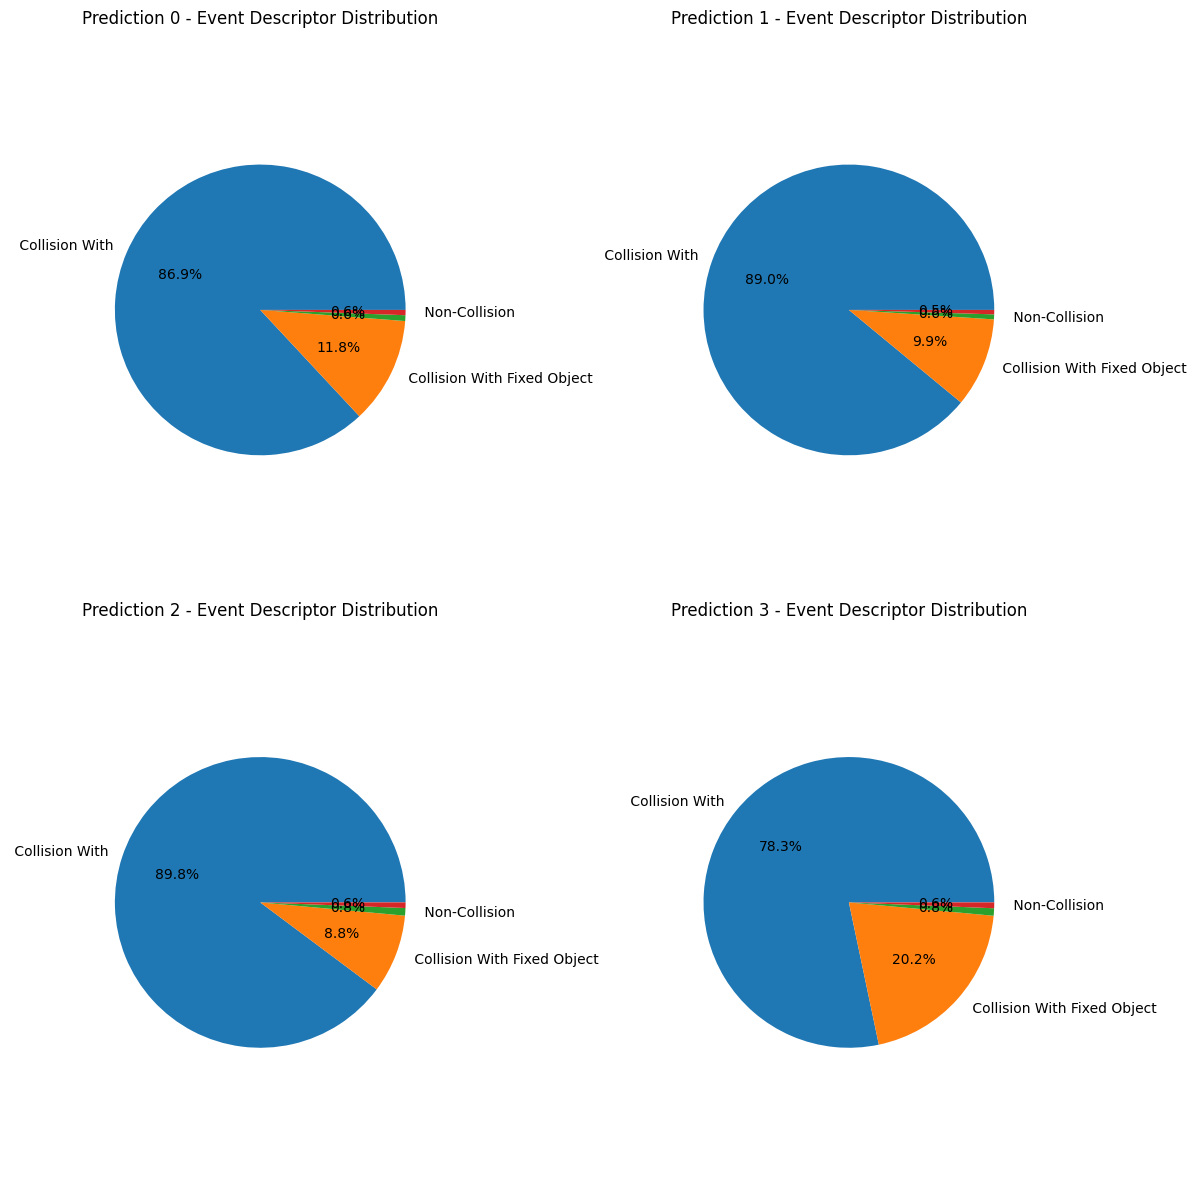

In [ ]:
# Grouping by prediction
pattern_counts_c1 = predictions_c1.groupBy(
    'prediction',
    'Event_descriptor_Type'
).agg(count('*').alias('prediction_count')).orderBy(['prediction','prediction_count'], ascending = [True, False])

# Separate data for each prediction
pie_chart_c1 = sorted(pattern_counts_c1.select('prediction').distinct().rdd.flatMap(lambda x: x).collect())

num_rows = 2
num_cols = 2
total_subplots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for idx, prediction in enumerate(pie_chart_c1):
    if idx < total_subplots:
        # Filter data for a specific prediction
        prediction_data_c1 = pattern_counts_c1.filter(pattern_counts_c1['prediction'] == prediction)

        # Get Event_Descriptor values and corresponding prediction counts
        event_descriptors_c1 = prediction_data_c1.select('Event_descriptor_Type').rdd.flatMap(lambda x: x).collect()
        prediction_counts_c1 = prediction_data_c1.select('prediction_count').rdd.flatMap(lambda x: x).collect()

        # Calculate subplot position
        row = idx // num_cols
        col = idx % num_cols

        # Create a pie chart for each prediction
        axs[row, col].pie(prediction_counts_c1, labels=event_descriptors_c1, autopct='%1.1f%%')
        axs[row, col].set_title(f'Prediction {prediction} - Event Descriptor Distribution')
        axs[row, col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

## **TRIAL 2: Accident Information**
Use the factors in the Accident Information category to group the values

### Preprocessing

**PART 1: Create a dataset for modeling with necessary columns**

In [ ]:
# duplicate the dataset
df_kmeans_c2 = df

In [ ]:
# split the event descriptor into 2 distinct categories
df_kmeans_c2 = df_kmeans_c2.withColumn('Event_Descriptor_Array', split(df['Event Descriptor'], ','))
df_kmeans_c2 = df_kmeans_c2.withColumn('Event_descriptor', df_kmeans_c2['Event_Descriptor_Array'].getItem(0))
df_kmeans_c2 = df_kmeans_c2.withColumn('Event_descriptor_Type', df_kmeans_c2['Event_Descriptor_Array'].getItem(1))
df_kmeans_c2 = df_kmeans_c2.drop('Column_1','Column_2', 'Event_Descriptor_Array', 'Time', 'Date', 'DOT Reference Marker Location')

In [ ]:
# Handling missing or unexpected values in the given variables
for column in ['Number of Vehicles Involved', 'Collision Type Descriptor', 'Police Report', 'Crash Descriptor']:
    df_kmeans_filtered_c2 = df_kmeans_c2.filter(df_kmeans_c2[column].isNotNull())

**PART 2: Create required classifiers and a pipeline for preprocessing** <br>

In [ ]:
# Indexing categorical columns
indexers_c2 = [
    StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep")
    for column in ['Number of Vehicles Involved', 'Collision Type Descriptor', 'Police Report', 'Crash Descriptor']
]

# One-hot encoding indexed columns
encoders_c2 = [
    OneHotEncoder(inputCol=column+"_index", outputCol=column+"_encoded")
    for column in ['Number of Vehicles Involved', 'Collision Type Descriptor', 'Police Report', 'Crash Descriptor']
]

# Create a pipeline
preprocessing_pipeline_c2 = Pipeline(stages=indexers_c2 + encoders_c2)

**PART 3: Transform the dataset**

In [ ]:
# Transform the dataset
df_c_kmeans_preprocessed_c2 = preprocessing_pipeline_c2.fit(df_kmeans_c2).transform(df_kmeans_c2)

### Modeling


**PART 1: Create required classifiers** <br>

In [ ]:
encoded_columns_c2 = ['Number of Vehicles Involved_encoded', 'Collision Type Descriptor_encoded', 'Police Report_encoded', 'Crash Descriptor_encoded']

# Creating a VectorAssembler with encoded columns
assembler_c2 = VectorAssembler(inputCols=encoded_columns_c2, outputCol='features')

# Scaling features
scaler_c2 = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='scaled_features')

# Applying K-means clustering
kmeans_c2 = KMeans(featuresCol='scaled_features', k=4, seed=42)

**PART 2: Create a pipeline**

In [ ]:
# Creating a pipeline
pipeline_c2 = Pipeline(stages=[assembler_c2, scaler_c2, kmeans_c2])

**PART 3: Fit and transform the dataset through the pipeline**

In [ ]:
# Fitting the pipeline
kmeans_model_c2 = pipeline_c2.fit(df_c_kmeans_preprocessed_c2)

**PART 4: Getting cluster predictions**

In [ ]:
# Getting cluster predictions
predictions_c2 = kmeans_model_c2.transform(df_c_kmeans_preprocessed_c2)

# Showing cluster results
predictions_c2.select('Number of Vehicles Involved', 'Collision Type Descriptor', 'Police Report', 'Crash Descriptor', 'prediction').show()

+---------------------------+-------------------------+-------------+--------------------+----------+
|Number of Vehicles Involved|Collision Type Descriptor|Police Report|    Crash Descriptor|prediction|
+---------------------------+-------------------------+-------------+--------------------+----------+
|                          2|              RIGHT ANGLE|            Y|Property Damage A...|         2|
|                          2|                 REAR END|            Y|Property Damage A...|         0|
|                          1|                    OTHER|            N|Property Damage A...|         1|
|                          2|               OVERTAKING|            Y|Property Damage A...|         3|
|                          2|              RIGHT ANGLE|            Y|Property Damage &...|         2|
|                          2|                 REAR END|            Y|Property Damage A...|         0|
|                          2|                  Unknown|            Y|     Injury A

### Evaluation

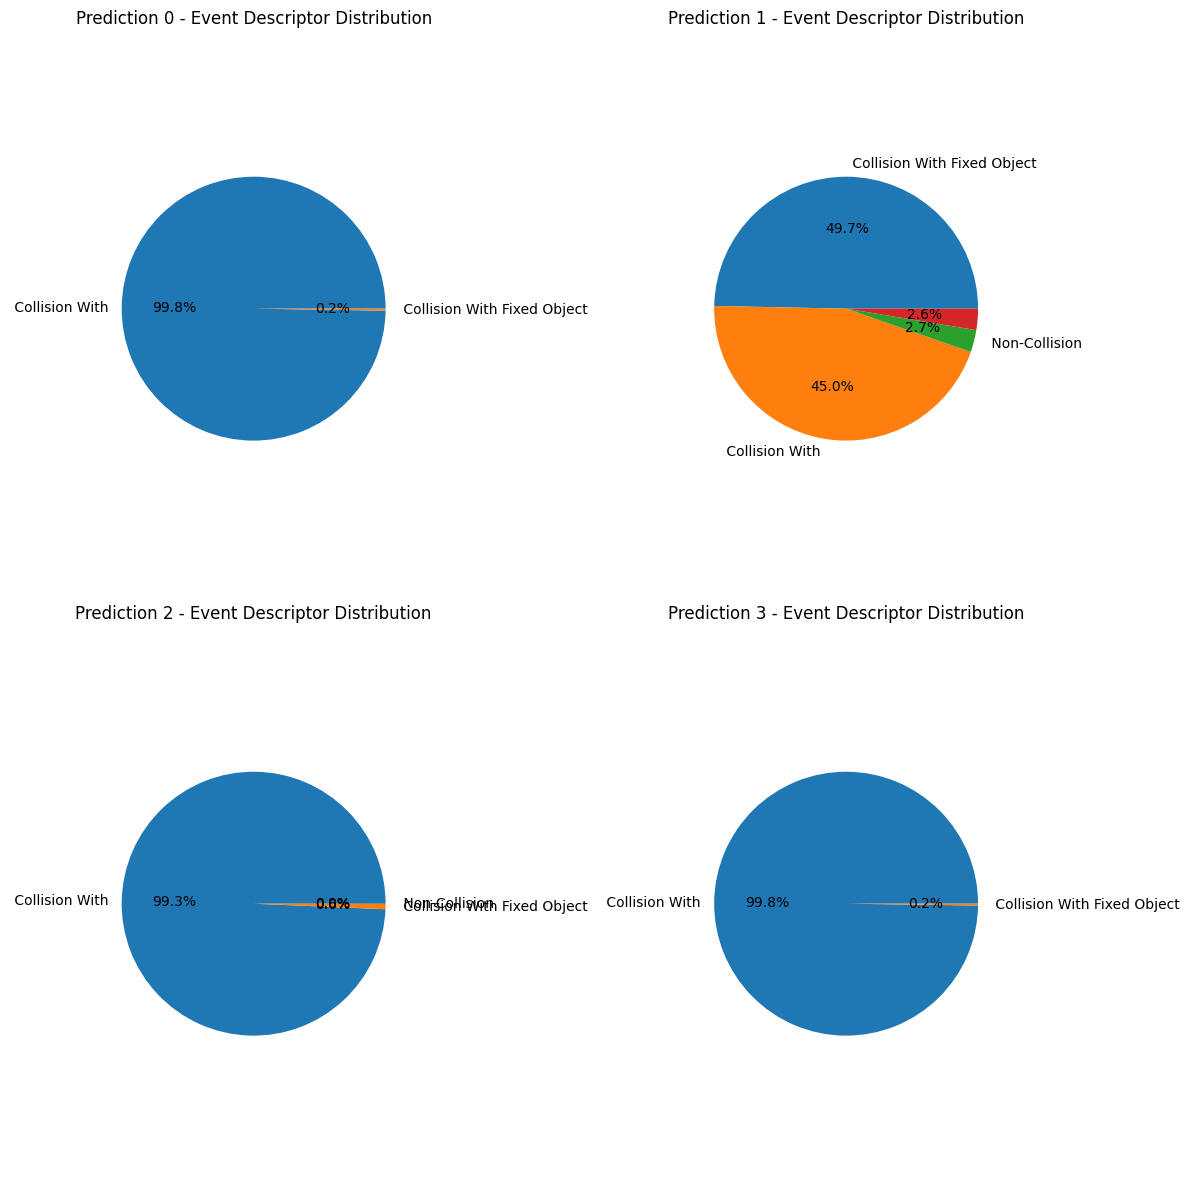

In [ ]:
# Grouping by prediction
pattern_counts_c2 = predictions_c2.groupBy(
    'prediction',
    'Event_descriptor_Type'
).agg(count('*').alias('prediction_count')).orderBy(['prediction','prediction_count'], ascending = [True, False])

# Separate data for each prediction
pie_chart_2 = sorted(pattern_counts_c2.select('prediction').distinct().rdd.flatMap(lambda x: x).collect())

num_rows = 2
num_cols = 2
total_subplots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for idx, prediction in enumerate(pie_chart_2):
    if idx < total_subplots:
        # Filter data for a specific prediction
        prediction_data_c2 = pattern_counts_c2.filter(pattern_counts_c2['prediction'] == prediction)

        # Get Event_Descriptor values and corresponding prediction counts
        event_descriptors_c2 = prediction_data_c2.select('Event_descriptor_Type').rdd.flatMap(lambda x: x).collect()
        prediction_counts_c2 = prediction_data_c2.select('prediction_count').rdd.flatMap(lambda x: x).collect()

        # Calculate subplot position
        row = idx // num_cols
        col = idx % num_cols

        # Create a pie chart for each prediction
        axs[row, col].pie(prediction_counts_c2, labels=event_descriptors_c2, autopct='%1.1f%%')
        axs[row, col].set_title(f'Prediction {prediction} - Event Descriptor Distribution')
        axs[row, col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

## **TRIAL 3: Environmental Factors**
Use the factors in the Environmental Factor category to group the values

### Preprocessing

**PART 1: Create a dataset for modeling with necessary columns**

In [ ]:
# duplicate the dataset
df_kmeans_c3 = df

In [ ]:

# split the event descriptor into 2 distinct categories
df_kmeans_c3 = df_kmeans_c3.withColumn('Event_Descriptor_Array', split(df['Event Descriptor'], ','))
df_kmeans_c3 = df_kmeans_c3.withColumn('Event_descriptor', df_kmeans_c3['Event_Descriptor_Array'].getItem(0))
df_kmeans_c3 = df_kmeans_c3.withColumn('Event_descriptor_Type', df_kmeans_c3['Event_Descriptor_Array'].getItem(1))
df_kmeans_c3 = df_kmeans_c3.drop('Column_1','Column_2', 'Event_Descriptor_Array', 'Time', 'Date', 'DOT Reference Marker Location')

In [ ]:

# Handling missing or unexpected values in the given variables
for column in ['Lighting Conditions', 'Road Descriptor', 'Road Surface Conditions']:
    df_kmeans_filtered_c3 = df_kmeans_c3.filter(df_kmeans_c3[column].isNotNull())

**PART 2: Create required classifiers and a pipeline for preprocessing** <br>

In [ ]:
# Indexing categorical columns
indexers_c3 = [
    StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep")
    for column in ['Lighting Conditions', 'Road Descriptor', 'Road Surface Conditions']
]

# One-hot encoding indexed columns
encoders_c3 = [
    OneHotEncoder(inputCol=column+"_index", outputCol=column+"_encoded")
    for column in ['Lighting Conditions', 'Road Descriptor', 'Road Surface Conditions']
]

# Create a pipeline
preprocessing_pipeline_c3 = Pipeline(stages=indexers_c3 + encoders_c3)

**PART 3: Transform the dataset**

In [ ]:
# Transform the dataset
df_c_kmeans_preprocessed_c3 = preprocessing_pipeline_c3.fit(df_kmeans_c3).transform(df_kmeans_c3)

### Modeling

**PART 1: Create required classifiers** <br>

In [ ]:
encoded_columns_c3 = ['Lighting Conditions_encoded', 'Road Descriptor_encoded', 'Road Surface Conditions_encoded']

# Creating a VectorAssembler with encoded columns
assembler_c3 = VectorAssembler(inputCols=encoded_columns_c3, outputCol='features')

# Scaling features
scaler_c3 = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='scaled_features')

# Applying K-means clustering
kmeans_c3 = KMeans(featuresCol='scaled_features', k=4, seed=42)


**PART 2: Create a pipeline**


In [ ]:
# Creating a pipeline
pipeline_c3 = Pipeline(stages=[assembler_c3, scaler_c3, kmeans_c3])

**PART 3: Fit and transform the dataset through the pipeline**

In [ ]:
# Fitting the pipeline
kmeans_model_c3 = pipeline_c3.fit(df_c_kmeans_preprocessed_c3)

**PART 4: Getting cluster predictions**

In [ ]:


# Getting cluster predictions
predictions_c3 = kmeans_model_c3.transform(df_c_kmeans_preprocessed_c3)

# Showing cluster results
predictions_c3.select('Lighting Conditions', 'Road Descriptor', 'Road Surface Conditions','prediction').show()

+-------------------+--------------------+-----------------------+----------+
|Lighting Conditions|     Road Descriptor|Road Surface Conditions|prediction|
+-------------------+--------------------+-----------------------+----------+
|            Unknown|  Straight and Grade|                    Wet|         3|
|           Daylight|  Straight and Level|                    Dry|         1|
|            Unknown|             Unknown|                Unknown|         0|
|Dark-Road Unlighted|  Straight and Level|                    Dry|         0|
|  Dark-Road Lighted|  Straight and Level|                    Dry|         0|
|Dark-Road Unlighted|  Straight and Level|                    Wet|         0|
|           Daylight|  Straight and Level|                    Dry|         1|
|           Daylight|  Straight and Level|                    Wet|         1|
|           Daylight|  Straight and Level|                    Wet|         1|
|               Dusk|  Straight and Level|                    We

### Evaluating

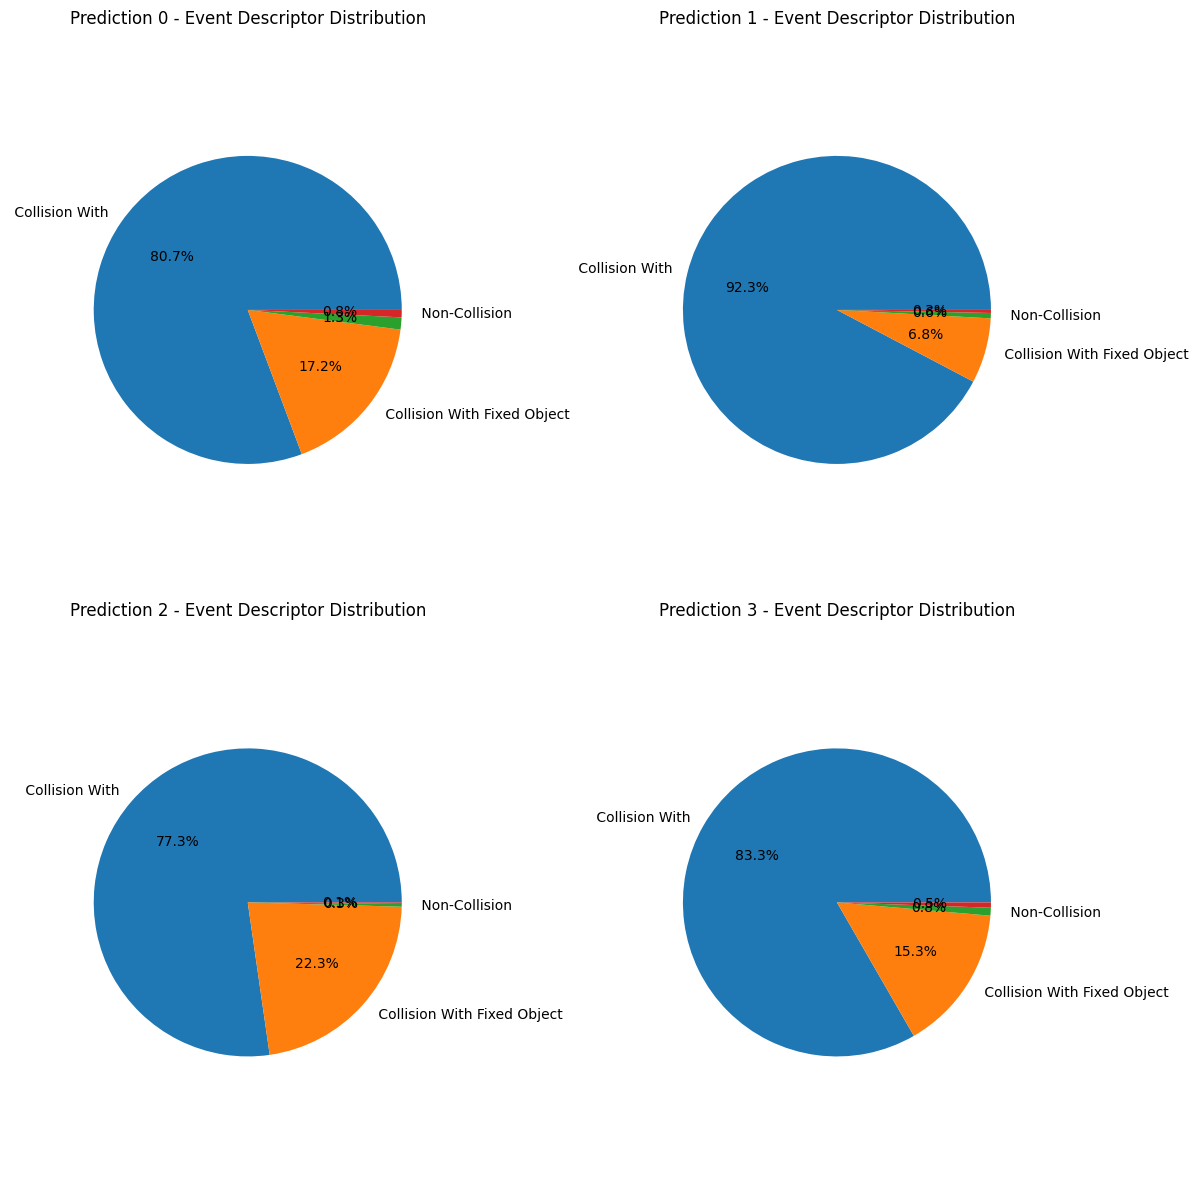

In [ ]:

### Evaluation
# Grouping by prediction
pattern_counts_c3 = predictions_c3.groupBy(
    'prediction',
    'Event_descriptor_Type'
).agg(count('*').alias('prediction_count')).orderBy(['prediction','prediction_count'], ascending = [True, False])

# Separate data for each prediction
pie_chart_3 = sorted(pattern_counts_c3.select('prediction').distinct().rdd.flatMap(lambda x: x).collect())

num_rows = 2
num_cols = 2
total_subplots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for idx, prediction in enumerate(pie_chart_3):
    if idx < total_subplots:
        # Filter data for a specific prediction
        prediction_data_c3 = pattern_counts_c3.filter(pattern_counts_c3['prediction'] == prediction)

        # Get Event_Descriptor values and corresponding prediction counts
        event_descriptors_c3 = prediction_data_c3.select('Event_descriptor_Type').rdd.flatMap(lambda x: x).collect()
        prediction_counts_c3 = prediction_data_c3.select('prediction_count').rdd.flatMap(lambda x: x).collect()

        # Calculate subplot position
        row = idx // num_cols
        col = idx % num_cols

        # Create a pie chart for each prediction
        axs[row, col].pie(prediction_counts_c3, labels=event_descriptors_c3, autopct='%1.1f%%')
        axs[row, col].set_title(f'Prediction {prediction} - Event Descriptor Distribution')
        axs[row, col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

## **TRIAL 4: Weather Conditions**
Use the factors in the Weather Conditions category to group the values

### Preprocessing

**PART 1: Create a dataset for modeling with necessary columns**

In [ ]:
# duplicate the dataset
df_kmeans_c4 = df

In [ ]:
# split the event descriptor into 2 distinct categories
df_kmeans_c4 = df_kmeans_c4.withColumn('Event_Descriptor_Array', split(df['Event Descriptor'], ','))
df_kmeans_c4 = df_kmeans_c4.withColumn('Event_descriptor', df_kmeans_c4['Event_Descriptor_Array'].getItem(0))
df_kmeans_c4 = df_kmeans_c4.withColumn('Event_descriptor_Type', df_kmeans_c4['Event_Descriptor_Array'].getItem(1))
df_kmeans_c4 = df_kmeans_c4.drop('Column_1','Column_2', 'Event_Descriptor_Array', 'Time', 'Date', 'DOT Reference Marker Location')

In [ ]:
# Handling missing or unexpected values in the given variables
for column in ['Weather Conditions', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'Fog_WeatherType', 'HeavyFog__WeatherType', 'Thunder_WeatherType', 'IcePellets_WeatherType', 'Hail_WeatherType', 'Glaze_WeatherType', 'Smoke_WeatherType', 'BlowingORDriftingSnow_WeatherType']:
    df_kmeans_filtered_c4 = df_kmeans_c4.filter(df_kmeans_c4[column].isNotNull())

**PART 2: Create required classifiers and a pipeline for preprocessing** <br>

In [ ]:
# Indexing categorical columns
indexers_c4 = [
    StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep")
    for column in ['Weather Conditions']
]

# One-hot encoding indexed columns
encoders_c4 = [
    OneHotEncoder(inputCol=column+"_index", outputCol=column+"_encoded")
    for column in ['Weather Conditions']
]

# Create a pipeline
preprocessing_pipeline_c4 = Pipeline(stages=indexers_c4 + encoders_c4)

**PART 3: Transform the dataset**

In [ ]:
# Transform the dataset
df_c_kmeans_preprocessed_c4 = preprocessing_pipeline_c4.fit(df_kmeans_c4).transform(df_kmeans_c4)

### Modeling


**PART 1: Create required classifiers** <br>

In [ ]:
encoded_columns_c4 = ['Weather Conditions_encoded', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'Fog_WeatherType', 'HeavyFog__WeatherType', 'Thunder_WeatherType', 'IcePellets_WeatherType', 'Hail_WeatherType', 'Glaze_WeatherType', 'Smoke_WeatherType', 'BlowingORDriftingSnow_WeatherType']

# Creating a VectorAssembler with encoded columns
assembler_c4 = VectorAssembler(inputCols=encoded_columns_c4, outputCol='features')

# Scaling features
scaler_c4 = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='scaled_features')

# Applying K-means clustering
kmeans_c4 = KMeans(featuresCol='scaled_features', k=4, seed=42)

**PART 2: Create a pipeline**

In [ ]:
# Creating a pipeline
pipeline_c4 = Pipeline(stages=[assembler_c4, scaler_c4, kmeans_c4])

**PART 3: Fit and transform the dataset through the pipeline**

In [ ]:
# Fitting the pipeline
kmeans_model_c4 = pipeline_c4.fit(df_c_kmeans_preprocessed_c4)

**PART 4: Getting cluster predictions**


In [ ]:
# Getting cluster predictions
predictions_c4 = kmeans_model_c4.transform(df_c_kmeans_preprocessed_c4)

# Showing cluster results
predictions_c4.select('Weather Conditions', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'Fog_WeatherType', 'HeavyFog__WeatherType', 'Thunder_WeatherType', 'IcePellets_WeatherType', 'Hail_WeatherType', 'Glaze_WeatherType', 'Smoke_WeatherType', 'BlowingORDriftingSnow_WeatherType', 'prediction').show()

+------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+----------+
|Weather Conditions| AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSnow_WeatherType|prediction|
+------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+----------+
|            Cloudy|11.18| 0.0| 0.0| 3.9|  35|  39|  22|              0|                    0|                  0|                     0|               0|                0|                0|                                0|         2|
|             Clear|11.18| 0.0| 0.0| 3.9|  35|  39|  22|


### Evaluation

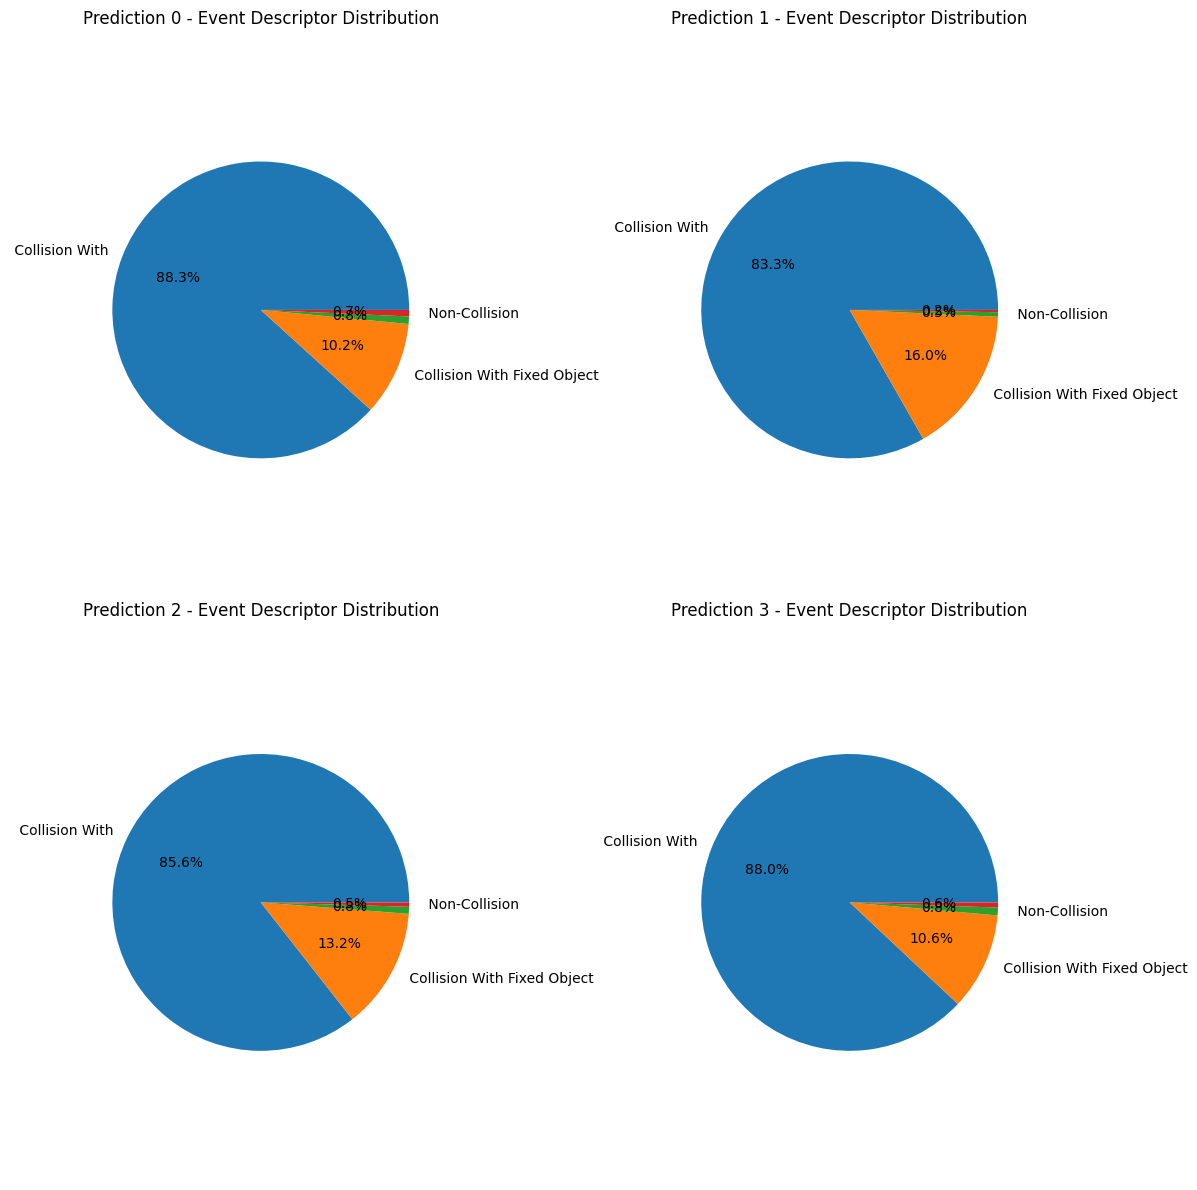

In [ ]:
# Grouping by prediction
pattern_counts_c4 = predictions_c4.groupBy(
    'prediction',
    'Event_descriptor_Type'
).agg(count('*').alias('prediction_count')).orderBy(['prediction','prediction_count'], ascending = [True, False])

# Separate data for each prediction
pie_chart_4 = sorted(pattern_counts_c4.select('prediction').distinct().rdd.flatMap(lambda x: x).collect())

num_rows = 2
num_cols = 2
total_subplots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for idx, prediction in enumerate(pie_chart_4):
    if idx < total_subplots:
        # Filter data for a specific prediction
        prediction_data_c4 = pattern_counts_c4.filter(pattern_counts_c4['prediction'] == prediction)

        # Get Event_Descriptor values and corresponding prediction counts
        event_descriptors_c4 = prediction_data_c4.select('Event_descriptor_Type').rdd.flatMap(lambda x: x).collect()
        prediction_counts_c4 = prediction_data_c4.select('prediction_count').rdd.flatMap(lambda x: x).collect()

        # Calculate subplot position
        row = idx // num_cols
        col = idx % num_cols

        # Create a pie chart for each prediction
        axs[row, col].pie(prediction_counts_c4, labels=event_descriptors_c4, autopct='%1.1f%%')
        axs[row, col].set_title(f'Prediction {prediction} - Event Descriptor Distribution')
        axs[row, col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

## **TRIAL 5: Traffic Control and Pedestrian Information**
Use the factors in the Traffic Control and Pedestrian Information category to group the values

Traffic Control Device, Pedestrian Bicyclist Action

### Preprocessing

**PART 1: Create a dataset for modeling with necessary columns**

In [ ]:
# duplicate the dataset
df_kmeans_c5 = df

In [ ]:
# split the event descriptor into 2 distinct categories
df_kmeans_c5 = df_kmeans_c5.withColumn('Event_Descriptor_Array', split(df['Event Descriptor'], ','))
df_kmeans_c5 = df_kmeans_c5.withColumn('Event_descriptor', df_kmeans_c5['Event_Descriptor_Array'].getItem(0))
df_kmeans_c5 = df_kmeans_c5.withColumn('Event_descriptor_Type', df_kmeans_c5['Event_Descriptor_Array'].getItem(1))
df_kmeans_c5 = df_kmeans_c5.drop('Column_1','Column_2', 'Event_Descriptor_Array', 'Time', 'Date', 'DOT Reference Marker Location')

In [ ]:
# Handling missing or unexpected values in the given variables
for column in ['Traffic Control Device', 'Pedestrian Bicyclist Action']:
    df_kmeans_filtered_c5 = df_kmeans_c5.filter(df_kmeans_c5[column].isNotNull())

**PART 2: Create required classifiers and a pipeline for preprocessing** <br>

In [ ]:
# Indexing categorical columns
indexers_c5 = [
    StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep")
    for column in ['Traffic Control Device', 'Pedestrian Bicyclist Action']
]

# One-hot encoding indexed columns
encoders_c5 = [
    OneHotEncoder(inputCol=column+"_index", outputCol=column+"_encoded")
    for column in ['Traffic Control Device', 'Pedestrian Bicyclist Action']
]

# Create a pipeline
preprocessing_pipeline_c5 = Pipeline(stages=indexers_c5 + encoders_c5)


**PART 3: Transform the dataset**

In [ ]:
# Transform the dataset
df_c_kmeans_preprocessed_c5 = preprocessing_pipeline_c5.fit(df_kmeans_c5).transform(df_kmeans_c5)


### Modeling

**PART 1: Create required classifiers** <br>

In [ ]:
encoded_columns_c5 = ['Traffic Control Device_encoded', 'Pedestrian Bicyclist Action_encoded']

# Creating a VectorAssembler with encoded columns
assembler_c5 = VectorAssembler(inputCols=encoded_columns_c5, outputCol='features')

# Scaling features
scaler_c5 = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='scaled_features')

# Applying K-means clustering
kmeans_c5 = KMeans(featuresCol='scaled_features', k=4, seed=42)

**PART 2: Create a pipeline**

In [ ]:
# Creating a pipeline
pipeline_c5 = Pipeline(stages=[assembler_c5, scaler_c5, kmeans_c5])

**PART 3: Fit and transform the dataset through the pipeline**

In [ ]:
# Fitting the pipeline
kmeans_model_c5 = pipeline_c5.fit(df_c_kmeans_preprocessed_c5)

**PART 4: Getting cluster predictions**

In [ ]:
# Getting cluster predictions
predictions_c5 = kmeans_model_c5.transform(df_c_kmeans_preprocessed_c5)

# Showing cluster results
predictions_c5.select('Traffic Control Device', 'Pedestrian Bicyclist Action', 'prediction').show()

+----------------------+---------------------------+----------+
|Traffic Control Device|Pedestrian Bicyclist Action|prediction|
+----------------------+---------------------------+----------+
|                  None|             Not Applicable|         2|
|                  None|             Not Applicable|         2|
|               Unknown|             Not Applicable|         0|
|                  None|             Not Applicable|         2|
|             Stop Sign|             Not Applicable|         3|
|                  None|             Not Applicable|         2|
|        Traffic Signal|             Not Applicable|         0|
|                  None|             Not Applicable|         2|
|             Stop Sign|       Crossing, No Sign...|         3|
|                  None|             Not Applicable|         2|
|                  None|             Not Applicable|         2|
|        Traffic Signal|             Not Applicable|         0|
|        Traffic Signal|             Not

### Evaluating

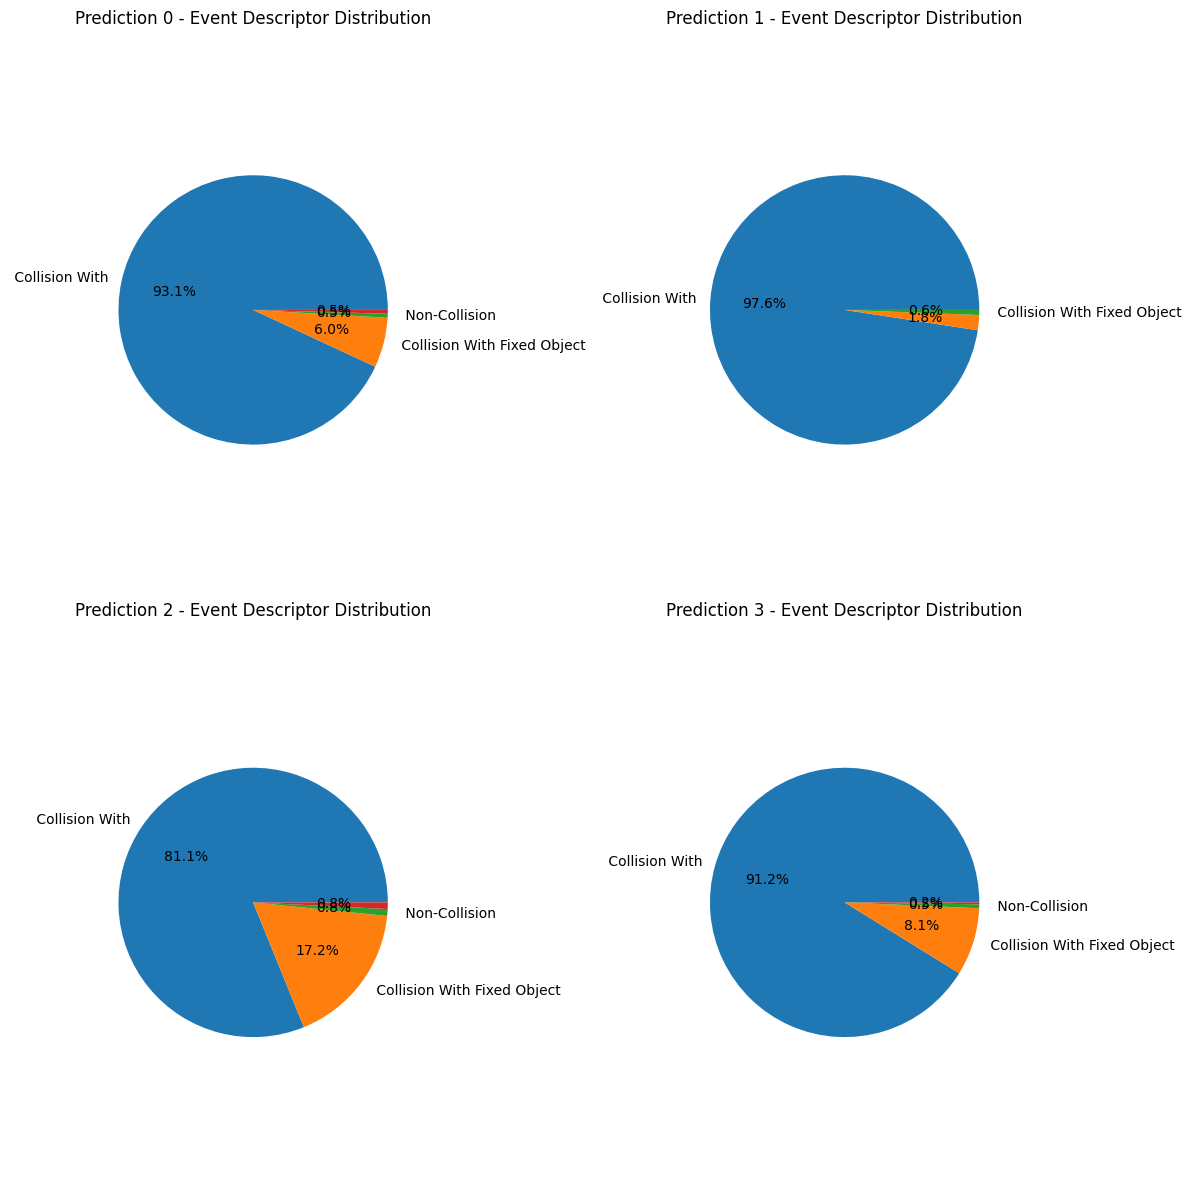

In [ ]:

### Evaluation
# Grouping by prediction
pattern_counts_c5 = predictions_c5.groupBy(
    'prediction',
    'Event_descriptor_Type'
).agg(count('*').alias('prediction_count')).orderBy(['prediction','prediction_count'], ascending = [True, False])

# Separate data for each prediction
pie_chart_5 = sorted(pattern_counts_c5.select('prediction').distinct().rdd.flatMap(lambda x: x).collect())

num_rows = 2
num_cols = 2
total_subplots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for idx, prediction in enumerate(pie_chart_5):
    if idx < total_subplots:
        # Filter data for a specific prediction
        prediction_data_c5 = pattern_counts_c5.filter(pattern_counts_c5['prediction'] == prediction)

        # Get Event_Descriptor values and corresponding prediction counts
        event_descriptors_c5 = prediction_data_c5.select('Event_descriptor_Type').rdd.flatMap(lambda x: x).collect()
        prediction_counts_c5 = prediction_data_c5.select('prediction_count').rdd.flatMap(lambda x: x).collect()

        # Calculate subplot position
        row = idx // num_cols
        col = idx % num_cols

        # Create a pie chart for each prediction
        axs[row, col].pie(prediction_counts_c5, labels=event_descriptors_c5, autopct='%1.1f%%')
        axs[row, col].set_title(f'Prediction {prediction} - Event Descriptor Distribution')
        axs[row, col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

## **Advanced Research**
Through trial 1~5, we recognized that the KMeans model with factors in the accident information category slightly created good clusters, in terms of event descriptor (main category).<br>
<br>
We will apply the PCA technique, conduct the process of choosing optimal K process, and evaluate using SSE, Silhouette Score, and Visual Inspection.

### Preprocessing

**PART 1: Create required classifiers and a pipeline** <br>

1) PCA
- `k=4`: We set the value of k as 4, because we will use 4 encoded variables in this case.

In [ ]:
# List of encoded columns for PCA
encoded_columns_c2 = ['Number of Vehicles Involved_encoded', 'Collision Type Descriptor_encoded', 'Police Report_encoded', 'Crash Descriptor_encoded']

# Creating a VectorAssembler with encoded columns
assembler_c2 = VectorAssembler(inputCols=encoded_columns_c2, outputCol='features')

# Scaling features
scaler_c2 = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='scaled_features')

# Perform PCA
pca = PCA(k=4, inputCol='features', outputCol='pca_features')

# create a pipeline
pca_pipeline = Pipeline(stages=[assembler_c2, scaler_c2, pca])
pca_model = pca_pipeline.fit(df_c_kmeans_preprocessed_c2)
pca_result = pca_model.transform(df_c_kmeans_preprocessed_c2)

2) A scree plot and a cumulative sum of variance explained

Text(0, 0.5, 'Proportion Variance Explained')

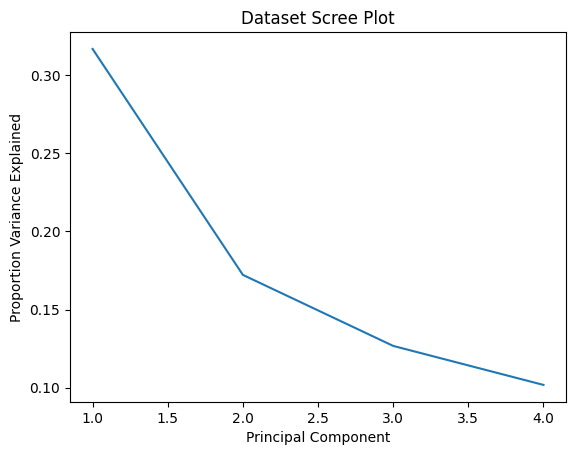

In [ ]:
plt.figure()
explained_var = pca_model.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var) + 1), explained_var)
plt.title('Dataset Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion Variance Explained')

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

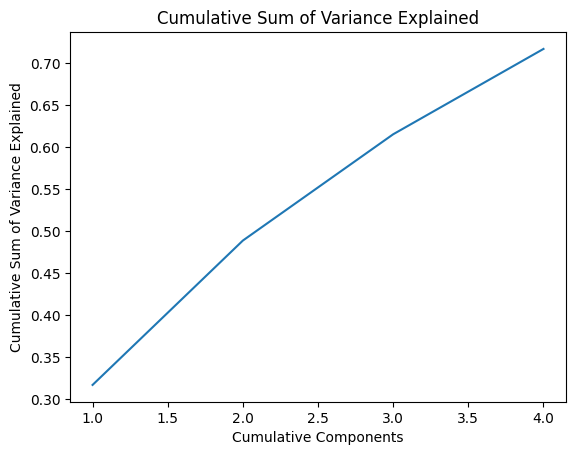

In [ ]:
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title('Cumulative Sum of Variance Explained')
plt.xlabel('Cumulative Components')
plt.ylabel('Cumulative Sum of Variance Explained')

**Conclusion**: Based on the scree variance explained plot, we would select 2 principal components for building the unsupervised machine learning model. After the 2nd component, the curve starts to flatten out. It means that approximately 95% of the variance is explained by 2 components.

### Modeling

**PART 2: Transform the dataset through the pipeline and determining optimal K for KMeans using the transformed data from PCA**

Adjust the k value of pca

In [ ]:
# Perform PCA
pca = PCA(k=2, inputCol='features', outputCol='pca_features')

# create a pipeline
pca_pipeline = Pipeline(stages=[assembler_c2, scaler_c2, pca])
pca_model = pca_pipeline.fit(df_c_kmeans_preprocessed_c2)
pca_result = pca_model.transform(df_c_kmeans_preprocessed_c2)

In [ ]:
cost = []
for k in range(2, 10):
    kmeans = KMeans(featuresCol='pca_features', k=k, seed=42)
    model = kmeans.fit(pca_result)
    transformed_data = model.transform(pca_result)
    centers = model.clusterCenters()
    cost.append(sum([min([np.linalg.norm(p - c) for c in centers])**2 for p in transformed_data.select('pca_features').collect()]))
cost

[12628.157010938876,
 2735.7418056735296,
 1110.4082304367648,
 828.5677632984514,
 694.6430285788424,
 602.2805356626599,
 587.7339736897845,
 330.8399842032699]

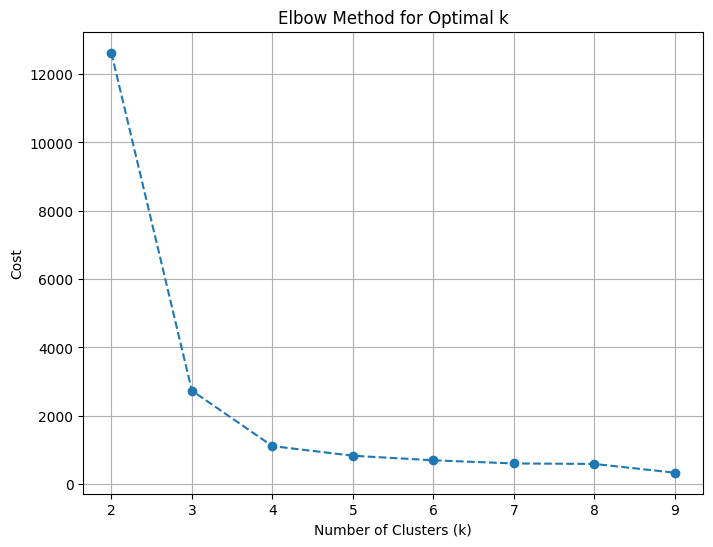

In [ ]:
# Plotting the cost against the number of clusters (elbow method)
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), cost, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

**Conclusion**: Based on the scree variance explained plot, we would set the optimal k value is 4 for building the unsupervised machine learning model. After the 4, the curve starts to flatten out.

In [ ]:
optimal_k = 4

**PART 3: Applying KMeans clustering with optimal k**

In [ ]:
kmeans_optimal = KMeans(featuresCol='pca_features', k=optimal_k, seed=42)
kmeans_model_optimal = kmeans_optimal.fit(pca_result)
predictions_optimal = kmeans_model_optimal.transform(pca_result)

**PART 4: Visualization for evaluation**

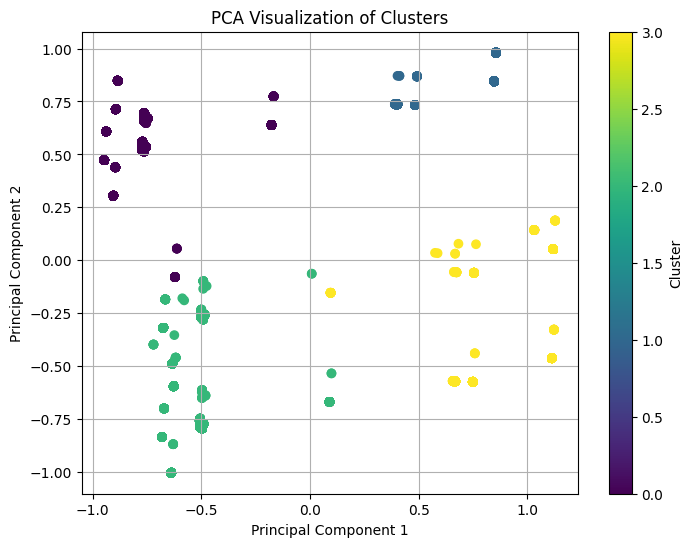

In [ ]:
# Visualization (assuming 2 principal components for visualization)
pandas_df = pca_result.select('pca_features').toPandas()

plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['pca_features'].apply(lambda x: x[0]), pandas_df['pca_features'].apply(lambda x: x[1]), c=predictions_optimal.select('prediction').toPandas()['prediction'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Clusters')
plt.grid()
plt.colorbar(label='Cluster')
plt.show()

### Evaluation

**PART 1: Visualization**

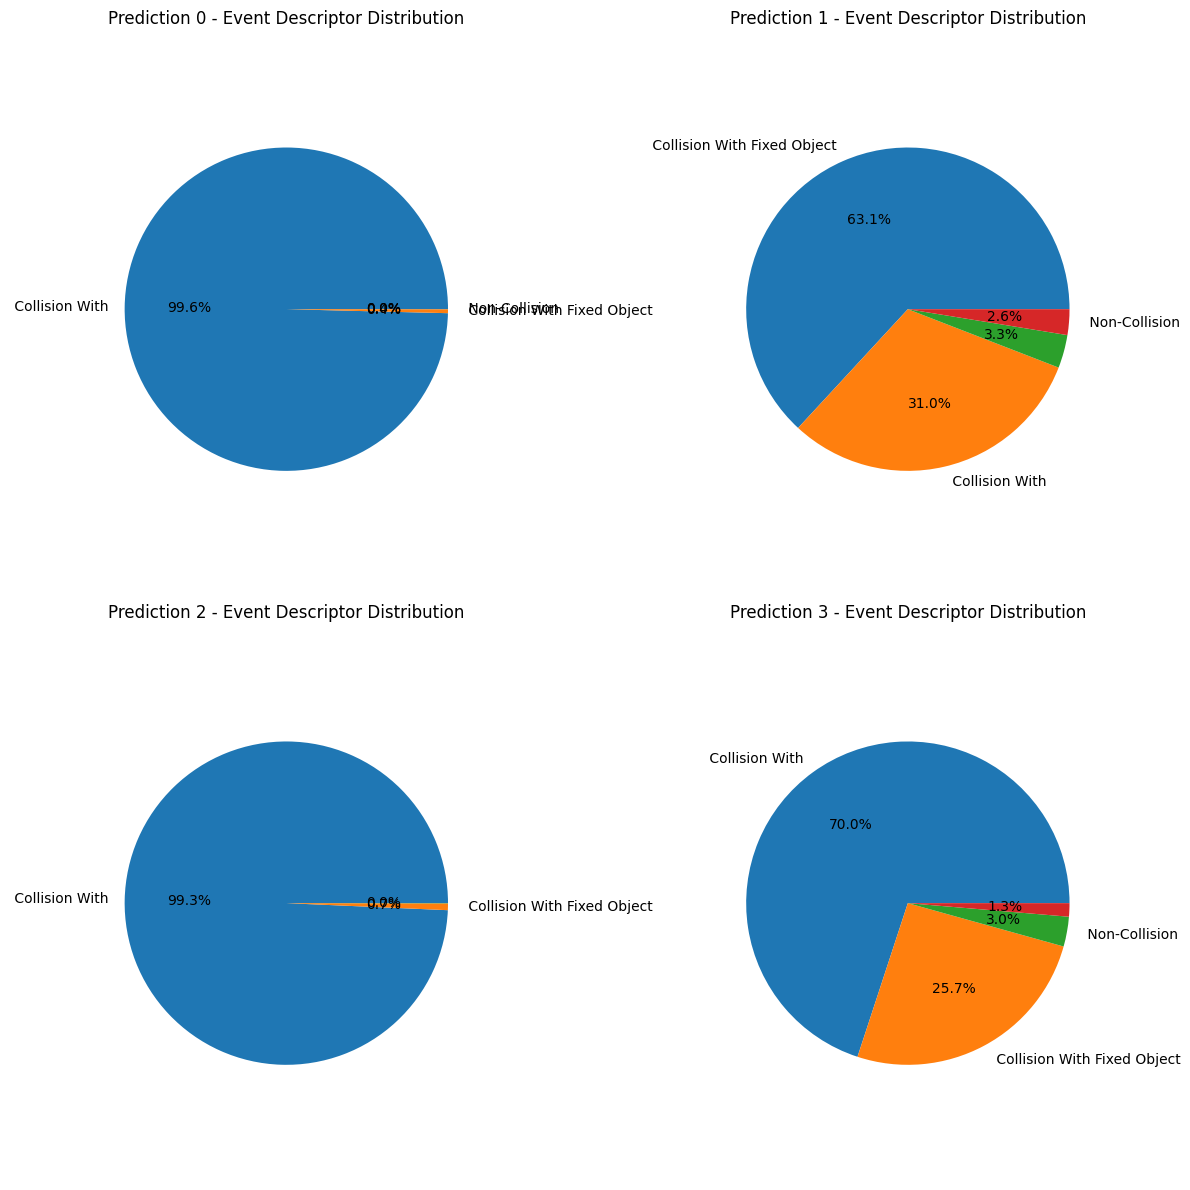

In [ ]:
# Grouping by prediction
pattern_counts_optimal = predictions_optimal.groupBy(
    'prediction',
    'Event_descriptor_Type'
).agg(count('*').alias('prediction_count')).orderBy(['prediction','prediction_count'], ascending = [True, False])

# Separate data for each prediction
pie_chart_optimal = sorted(pattern_counts_optimal.select('prediction').distinct().rdd.flatMap(lambda x: x).collect())

num_rows = 2
num_cols = 2
total_subplots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for idx, prediction in enumerate(pie_chart_optimal):
    if idx < total_subplots:
        # Filter data for a specific prediction
        prediction_data_optimal = pattern_counts_optimal.filter(pattern_counts_optimal['prediction'] == prediction)

        # Get Event_Descriptor values and corresponding prediction counts
        event_descriptors_optimal = prediction_data_optimal.select('Event_descriptor_Type').rdd.flatMap(lambda x: x).collect()
        prediction_counts_optimal = prediction_data_optimal.select('prediction_count').rdd.flatMap(lambda x: x).collect()

        # Calculate subplot position
        row = idx // num_cols
        col = idx % num_cols

        # Create a pie chart for each prediction
        axs[row, col].pie(prediction_counts_optimal, labels=event_descriptors_optimal, autopct='%1.1f%%')
        axs[row, col].set_title(f'Prediction {prediction} - Event Descriptor Distribution')
        axs[row, col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

**PART 2: Evaluation Metrics**

1) Sum of Squared Error

In [ ]:
summary = kmeans_model_c2.stages[-1].summary
sse_before = summary.trainingCost
sse_after = kmeans_model_optimal.summary.trainingCost
print("Sum of Squared Errors (SSE) before PCA:", sse_before)
print("Sum of Squared Errors (SSE) before PCA:", sse_after)

Sum of Squared Errors (SSE) before PCA: 19233.252075028107
Sum of Squared Errors (SSE) before PCA: 1110.4082304367573


**Conclusion**: The lower SSE value (1110.4082304367573) after PCA implies that the clusters formed are more compact, indicating that the points within each cluster are closer to their centroids, resulting in a better-defined clustering structure compared to the model before PCA.

2) Silhouette Score

In [ ]:

evaluator = ClusteringEvaluator()
silhouette_score_before = evaluator.evaluate(predictions_c2)
silhouette_score_after = evaluator.evaluate(predictions_optimal)
print("Silhouette Score before PCA:", silhouette_score_before)
print("Silhouette Score after PCA:", silhouette_score_after)


Silhouette Score before PCA: 0.49328646508670676
Silhouette Score after PCA: 0.5081309372002729


**Conclusion**: The higher Silhouette Score after PCA (0.5081309372002729) suggests that the clustering structure is more well-defined and distinct compared to the model before PCA (0.49328646508670676). The model after PCA appears to have a **slightly** better-defined clustering structure according to the Silhouette Score.

## **Assumption 2: Correlations**
Select features for the clustering models using **correlations**


## **TRIAL 1**

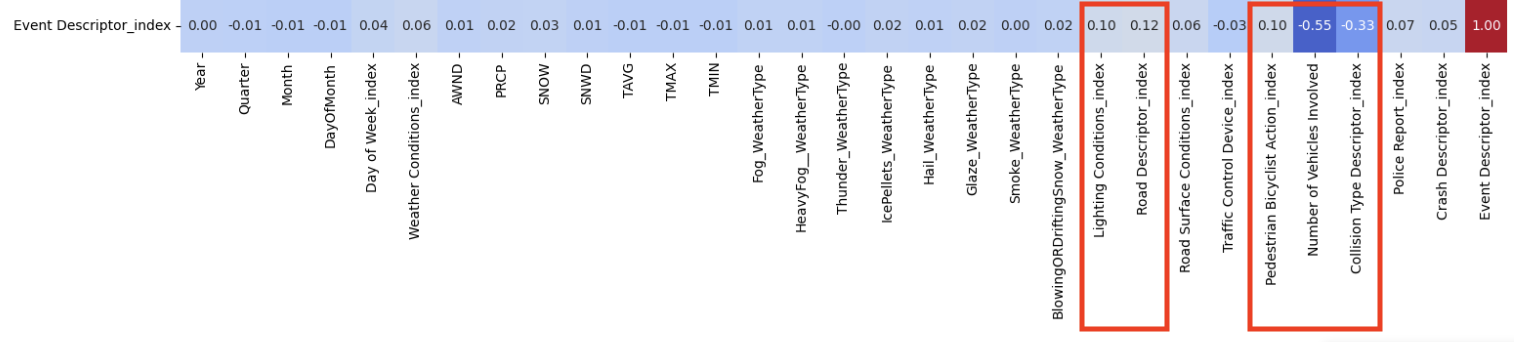

In the correlation and association analysis of all variables in the previous step, we would conclude that `Event Descriptor_index` is slightly related to environmental factors (Lighting Conditions and Road Descriptor) and accident information (Number of vehicles involved, Pedestrian Bicyclist Action, and collision type descriptor), which the absolute value of correlations between each factor and `Event Descriptor_index` are over 0.10.

Using these variables, we will find specific patterns in accidents (each event descriptor) based on **KMeans** clustering algorithms.

### Preprocessing

**PART 1: Create a dataset for modeling with necessary columns**

In [ ]:
# Copy the dataset
df_c_kmeans = df

In [ ]:

df_c_kmeans = df_c_kmeans.withColumn('Event_Descriptor_Array', split(df['Event Descriptor'], ','))
df_c_kmeans = df_c_kmeans.withColumn('Event_descriptor', df_c_kmeans['Event_Descriptor_Array'].getItem(0))
df_c_kmeans = df_c_kmeans.withColumn('Event_descriptor_Type', df_c_kmeans['Event_Descriptor_Array'].getItem(1))
df_c_kmeans = df_c_kmeans.drop('Column_1','Column_2', 'Event_Descriptor_Array')

In [ ]:
df_c_kmeans.show(2)

+----+--------------------+-------------------+----------+-----------+-------------+-------------------+-------------------------+------------------+------------------+----------------------+-----------------------+-----------------------------+---------------------------+--------------------+---------------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+-------------------+---------------------+
|Year|    Crash Descriptor|               Time|      Date|Day of Week|Police Report|Lighting Conditions|Collision Type Descriptor|   Road Descriptor|Weather Conditions|Traffic Control Device|Road Surface Conditions|DOT Reference Marker Location|Pedestrian Bicyclist Action|    Event Descriptor|Number of Vehicles Involved| AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_Weat

In [ ]:
# Handling missing or unexpected values in the given variables
for column in ['Lighting Conditions', 'Road Descriptor', 'Pedestrian Bicyclist Action', 'Number of Vehicles Involved', 'Collision Type Descriptor']:
    df_c_kmeans_filtered = df_c_kmeans.filter(df_c_kmeans[column].isNotNull())

**PART 2: Create required classifiers and a pipeline for preprocessing** <br>
1) String Indexer: Convert the values in categorical variables into indexes dices <br>
2) One-hot encoding: Transforms the indices into a binary sparse vector

In [ ]:
# Indexing categorical columns
indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep")
    for column in ['Lighting Conditions', 'Road Descriptor', 'Pedestrian Bicyclist Action', 'Number of Vehicles Involved', 'Collision Type Descriptor']
]

# One-hot encoding indexed columns
encoders = [
    OneHotEncoder(inputCol=column+"_index", outputCol=column+"_encoded")
    for column in ['Lighting Conditions', 'Road Descriptor', 'Pedestrian Bicyclist Action', 'Number of Vehicles Involved', 'Collision Type Descriptor']
]

# Create a pipeline
preprocessing_pipeline = Pipeline(stages=indexers + encoders)

**PART 3: Transform the dataset**

In [ ]:
# Transform the dataset
df_c_kmeans_preprocessed = preprocessing_pipeline.fit(df_c_kmeans).transform(df_c_kmeans)

### Modeling

**PART 1: Create required classifiers** <br>
1) Vector Assembler: Assemble all the transformed columns into a single vector column, which is appropriate as a form of the input to machine learning algorithms. <br>
2) Standard Scaler: scale and standardize feature vectors <br>
3) **KMeans**: Since we have 4 main categories of event descriptor (`event_descriptor_type`) to build the model, set the number of clusters as 5.

In [ ]:
encoded_columns = ['Lighting Conditions_encoded', 'Road Descriptor_encoded', 'Pedestrian Bicyclist Action_encoded', 'Number of Vehicles Involved_encoded', 'Collision Type Descriptor_encoded']

# Creating a VectorAssembler with encoded columns
assembler = VectorAssembler(inputCols=encoded_columns, outputCol='features')

# Scaling features
scaler = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='scaled_features')

# Applying K-means clustering
kmeans = KMeans(featuresCol='scaled_features', k=4, seed=42)

**PART 2: Create a pipeline**

In [ ]:
# Creating a pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

**PART 3: Fit and transform the dataset through the pipeline**

In [ ]:
# Fitting the pipeline
kmeans_model = pipeline.fit(df_c_kmeans_preprocessed)

**PART 4: Getting cluster predictions**

In [ ]:
# Getting cluster predictions
predictions = kmeans_model.transform(df_c_kmeans_preprocessed)

# Showing cluster results
predictions.select('Lighting Conditions' ,'Road Descriptor', 'Pedestrian Bicyclist Action',
                   'Number of Vehicles Involved', 'Collision Type Descriptor', 'prediction').show()

+-------------------+--------------------+---------------------------+---------------------------+-------------------------+----------+
|Lighting Conditions|     Road Descriptor|Pedestrian Bicyclist Action|Number of Vehicles Involved|Collision Type Descriptor|prediction|
+-------------------+--------------------+---------------------------+---------------------------+-------------------------+----------+
|            Unknown|  Straight and Grade|             Not Applicable|                          2|              RIGHT ANGLE|         0|
|           Daylight|  Straight and Level|             Not Applicable|                          2|                 REAR END|         1|
|            Unknown|             Unknown|             Not Applicable|                          1|                    OTHER|         3|
|Dark-Road Unlighted|  Straight and Level|             Not Applicable|                          2|               OVERTAKING|         1|
|  Dark-Road Lighted|  Straight and Level|      

### Evaluation

In [ ]:
# Grouping by prediction
pattern_counts = predictions.groupBy(
    'prediction',
    'Event_descriptor_Type'
).agg(count('*').alias('prediction_count')).orderBy(['prediction','prediction_count'], ascending = [True, False])

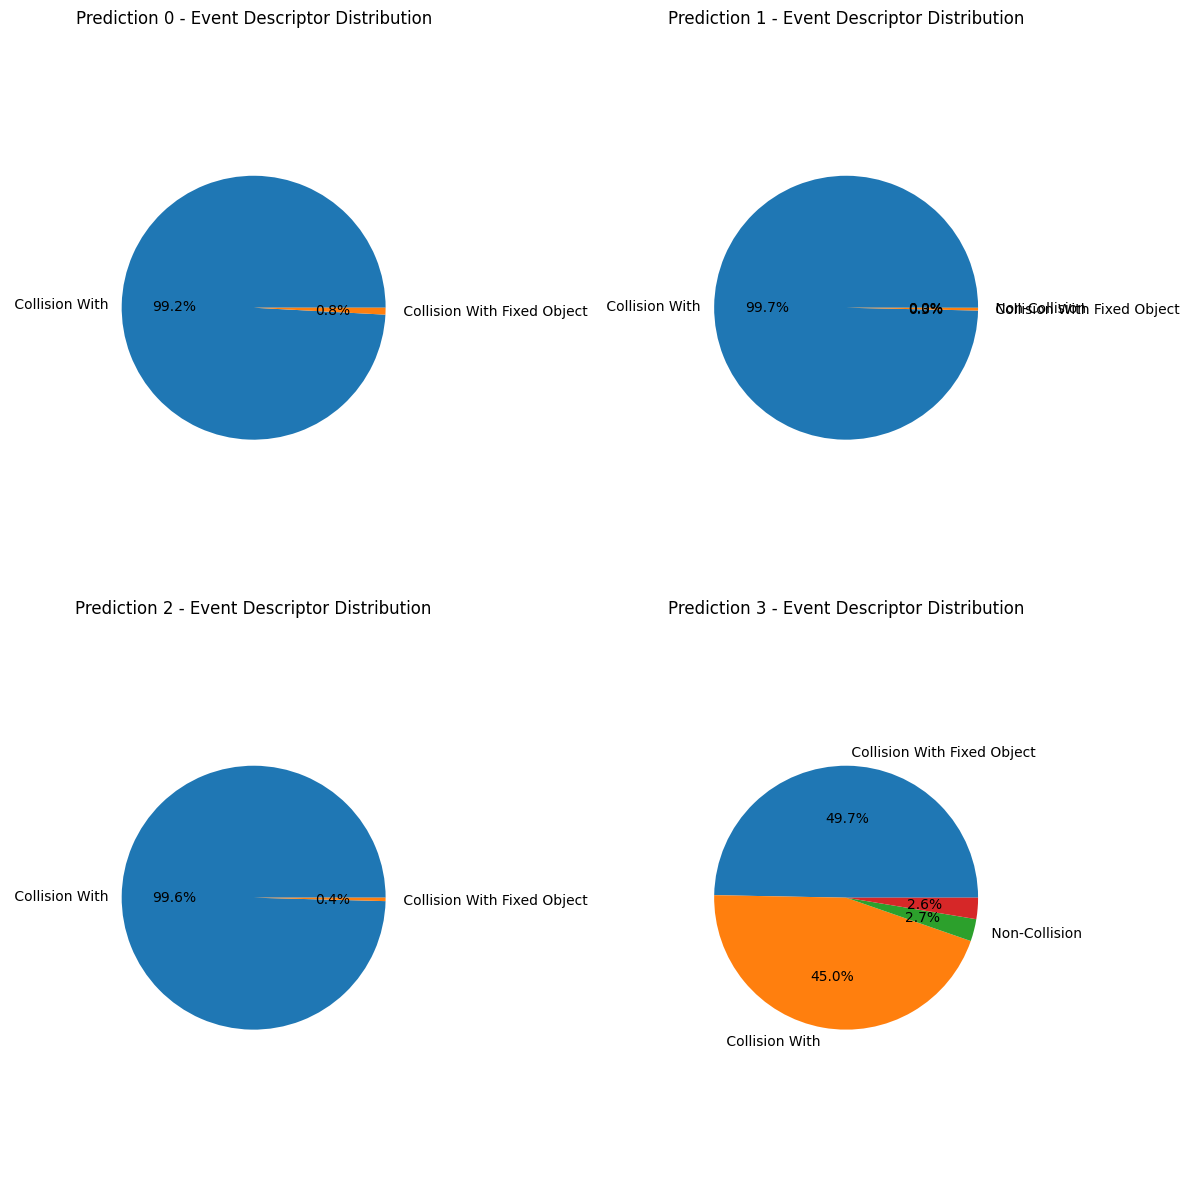

In [ ]:
# Separate data for each prediction
pie_chart = sorted(pattern_counts.select('prediction').distinct().rdd.flatMap(lambda x: x).collect())

num_rows = 2
num_cols = 2
total_subplots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for idx, prediction in enumerate(pie_chart):
    if idx < total_subplots:
        # Filter data for a specific prediction
        prediction_data = pattern_counts.filter(pattern_counts['prediction'] == prediction)

        # Get Event_Descriptor values and corresponding prediction counts
        event_descriptors = prediction_data.select('Event_descriptor_Type').rdd.flatMap(lambda x: x).collect()
        prediction_counts = prediction_data.select('prediction_count').rdd.flatMap(lambda x: x).collect()

        # Calculate subplot position
        row = idx // num_cols
        col = idx % num_cols

        # Create a pie chart for each prediction
        axs[row, col].pie(prediction_counts, labels=event_descriptors, autopct='%1.1f%%')
        axs[row, col].set_title(f'Prediction {prediction} - Event Descriptor Distribution')
        axs[row, col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

**Conclusion**: The analysis indicates that the highest occurrence of accidents within cluster 3 predominantly involves collisions with fixed objects. In contrast, the remaining clusters predominantly involve various other collision types. This observation suggests that the KMeans model might encounter difficulties in effectively delineating clear and distinct clusters.

## **Advanced Research for TRIAL 1**

### Modeling

**PART 1: Create required classifiers and a pipeline** <br>


1) PCA
- `k=4`: We set the value of k as 5, because we will use 5 encoded variables in this case.


In [ ]:

# List of encoded columns for PCA
encoded_columns = ['Lighting Conditions_encoded', 'Road Descriptor_encoded', 'Pedestrian Bicyclist Action_encoded', 'Number of Vehicles Involved_encoded', 'Collision Type Descriptor_encoded']

# Creating a VectorAssembler with encoded columns
assembler = VectorAssembler(inputCols=encoded_columns, outputCol='features')

# Scaling features
scaler = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='scaled_features')

# Perform PCA
pca = PCA(k=5, inputCol='features', outputCol='pca_features')

# create a pipeline
pca_pipeline = Pipeline(stages=[assembler, scaler, pca])
pca_model = pca_pipeline.fit(df_c_kmeans_preprocessed)
pca_result = pca_model.transform(df_c_kmeans_preprocessed)




2) A scree plot and a cumulative sum of variance explained

Text(0, 0.5, 'Proportion Variance Explained')

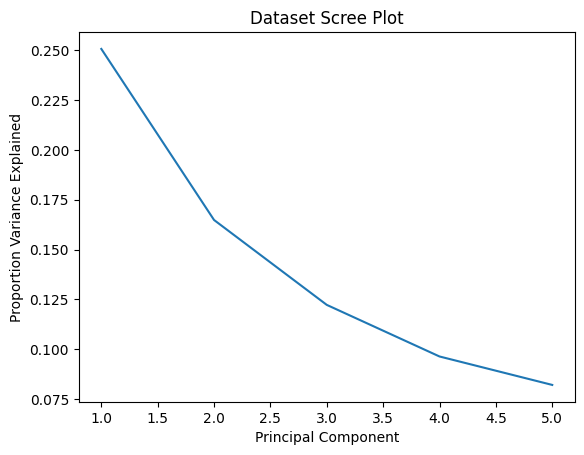

In [ ]:
plt.figure()
explained_var = pca_model.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var) + 1), explained_var)
plt.title('Dataset Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion Variance Explained')

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

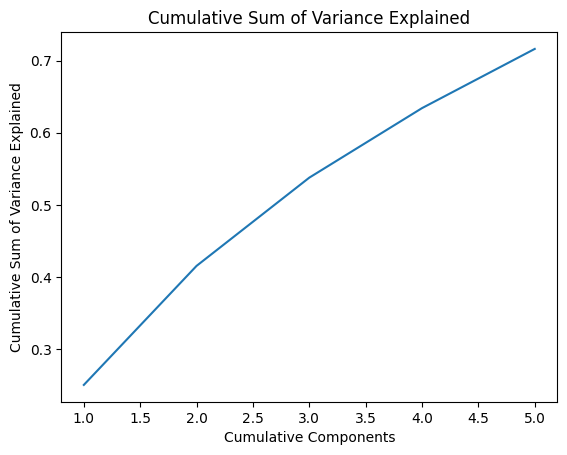

In [ ]:
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title('Cumulative Sum of Variance Explained')
plt.xlabel('Cumulative Components')
plt.ylabel('Cumulative Sum of Variance Explained')

**Conclusion**: Based on the scree variance explained plot, we would select 3 principal components for building the unsupervised machine learning model. After the 3rd component, the curve starts to flatten out. It means that approximately 95% of the variance is explained by 3 components.


**PART 2: Transform the dataset through the pipeline and determining optimal K for KMeans using the transformed data from PCA**



Adjust the k value of pca

In [ ]:
# Perform PCA
pca = PCA(k=3, inputCol='features', outputCol='pca_features')

# create a pipeline
pca_pipeline = Pipeline(stages=[assembler, scaler, pca])
pca_model = pca_pipeline.fit(df_c_kmeans_preprocessed)
pca_result = pca_model.transform(df_c_kmeans_preprocessed)

Find the optimal K

In [ ]:
cost = []
for k in range(2, 10):
    kmeans = KMeans(featuresCol='pca_features', k=k, seed=42)
    model = kmeans.fit(pca_result)
    transformed_data = model.transform(pca_result)
    centers = model.clusterCenters()
    cost.append(sum([min([np.linalg.norm(p - c) for c in centers])**2 for p in transformed_data.select('pca_features').collect()]))
cost

[15761.142806791442,
 11302.651672394566,
 6334.362974429582,
 4149.964733154762,
 3445.248746395722,
 3095.2201809500652,
 1942.4165037345804,
 2117.3229202429925]

Visualization

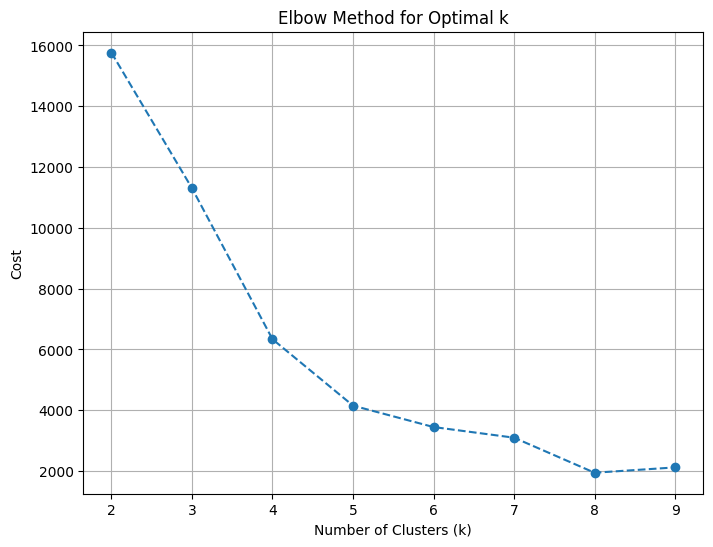

In [ ]:
# Plotting the cost against the number of clusters (elbow method)
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), cost, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

**Conclusion**: Based on the scree variance explained plot, we would set the optimal k value is 4 for building the unsupervised machine learning model. After the 4, the curve starts to flatten out.

In [ ]:
optimal_k = 4

**PART 3: Applying KMeans clustering with optimal k**

In [ ]:
kmeans_optimal = KMeans(featuresCol='pca_features', k=optimal_k, seed=42)
kmeans_model_optimal = kmeans_optimal.fit(pca_result)
predictions_optimal = kmeans_model_optimal.transform(pca_result)

**PART 4: Visualization for evaluation**

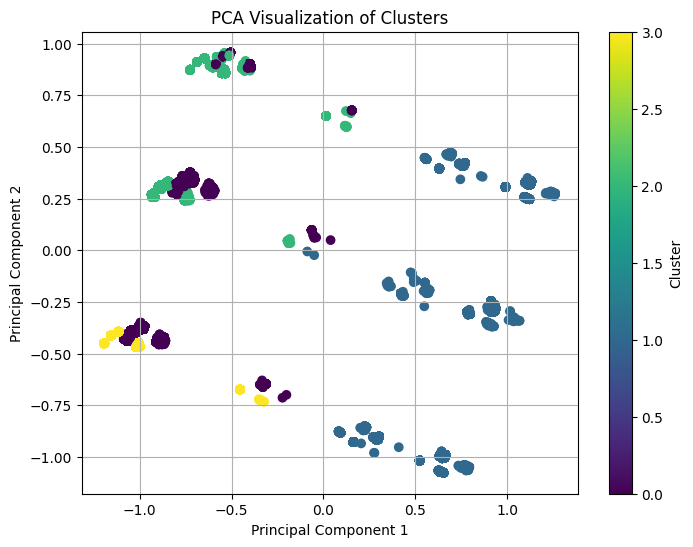

In [ ]:

# Visualization (assuming 2 principal components for visualization)
pandas_df = pca_result.select('pca_features').toPandas()

plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['pca_features'].apply(lambda x: x[0]), pandas_df['pca_features'].apply(lambda x: x[1]), c=predictions_optimal.select('prediction').toPandas()['prediction'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Clusters')
plt.grid()
plt.colorbar(label='Cluster')
plt.show()

### Evaluation

**PART 1: Visualization**

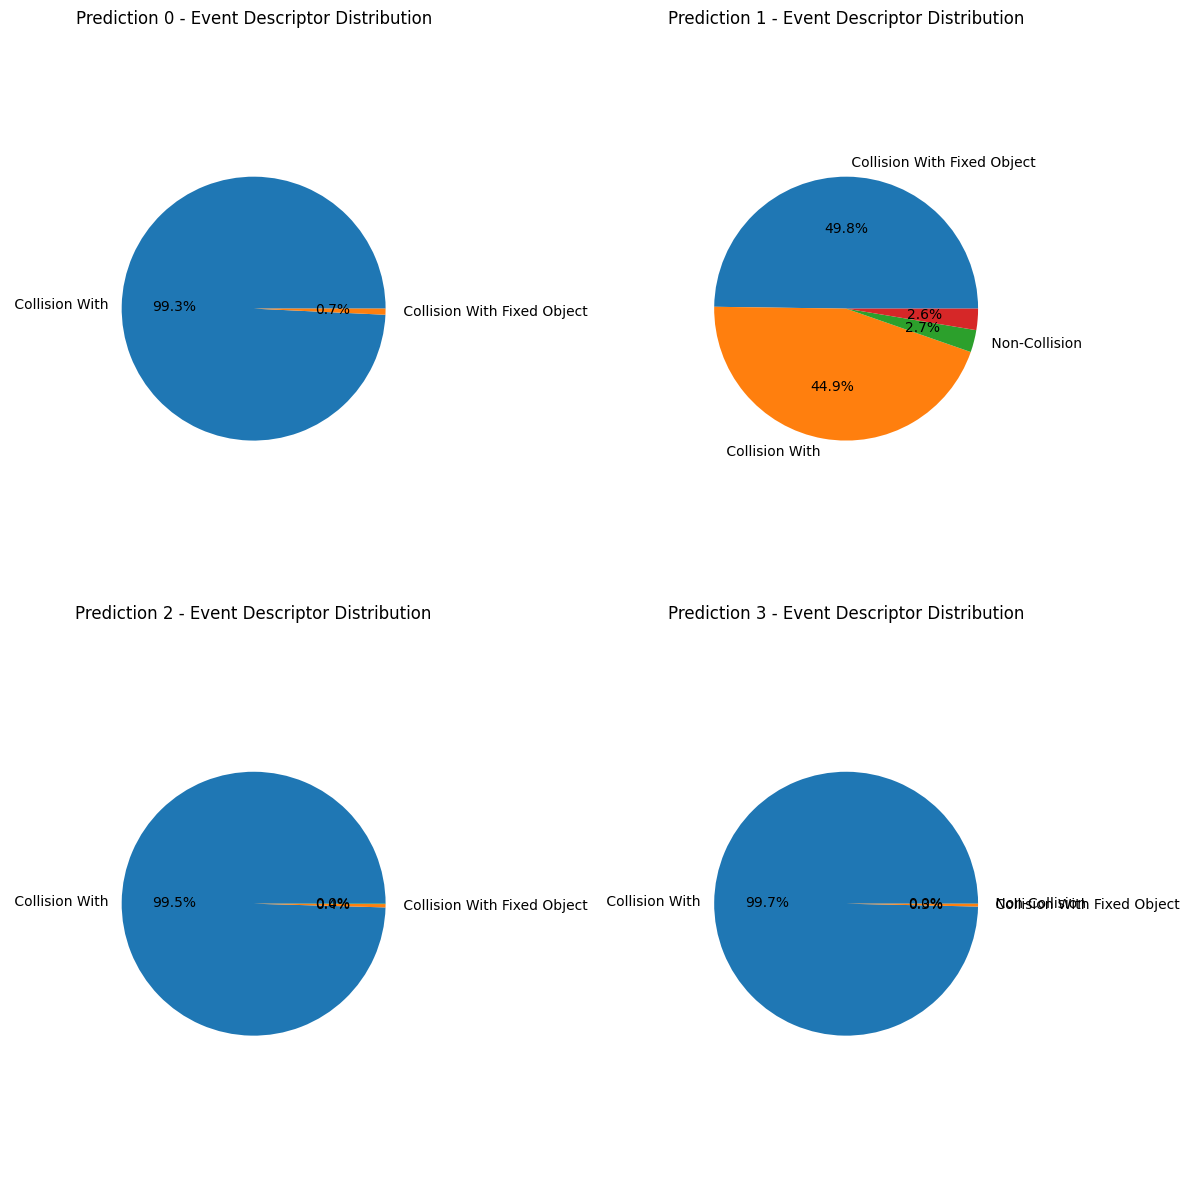

In [ ]:

# Grouping by prediction
pattern_counts_optimal = predictions_optimal.groupBy(
    'prediction',
    'Event_descriptor_Type'
).agg(count('*').alias('prediction_count')).orderBy(['prediction','prediction_count'], ascending = [True, False])

# Separate data for each prediction
pie_chart_optimal = sorted(pattern_counts_optimal.select('prediction').distinct().rdd.flatMap(lambda x: x).collect())

num_rows = 2
num_cols = 2
total_subplots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for idx, prediction in enumerate(pie_chart_optimal):
    if idx < total_subplots:
        # Filter data for a specific prediction
        prediction_data_optimal = pattern_counts_optimal.filter(pattern_counts_optimal['prediction'] == prediction)

        # Get Event_Descriptor values and corresponding prediction counts
        event_descriptors_optimal = prediction_data_optimal.select('Event_descriptor_Type').rdd.flatMap(lambda x: x).collect()
        prediction_counts_optimal = prediction_data_optimal.select('prediction_count').rdd.flatMap(lambda x: x).collect()

        # Calculate subplot position
        row = idx // num_cols
        col = idx % num_cols

        # Create a pie chart for each prediction
        axs[row, col].pie(prediction_counts_optimal, labels=event_descriptors_optimal, autopct='%1.1f%%')
        axs[row, col].set_title(f'Prediction {prediction} - Event Descriptor Distribution')
        axs[row, col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

**PART 2: Evaluation Metrics**

1) Sum of Squared Error

In [ ]:

summary = kmeans_model.stages[-1].summary
sse_before = summary.trainingCost
sse_after = kmeans_model_optimal.summary.trainingCost
print("Sum of Squared Errors (SSE) before PCA:", sse_before)
print("Sum of Squared Errors (SSE) before PCA:", sse_after)


Sum of Squared Errors (SSE) before PCA: 34366.96173463178
Sum of Squared Errors (SSE) before PCA: 6334.36297442965



**Conclusion**: The lower SSE value (6334.36297442965) after PCA implies that the clusters formed are more compact, indicating that the points within each cluster are closer to their centroids, resulting in a better-defined clustering structure compared to the model before PCA.

2) Silhouette Score

In [ ]:

evaluator = ClusteringEvaluator()
silhouette_score_before = evaluator.evaluate(predictions)
silhouette_score_after = evaluator.evaluate(predictions_optimal)
print("Silhouette Score before PCA:", silhouette_score_before)
print("Silhouette Score after PCA:", silhouette_score_after)

Silhouette Score before PCA: 0.27269242113142145
Silhouette Score after PCA: 0.38763879872001594


**Conclusion**: The higher Silhouette Score after PCA (0.38763879872001594) suggests that the clustering structure is more well-defined and distinct compared to the model before PCA (0.27269242113142145). The model after PCA appears to have a **slightly** better-defined clustering structure according to the Silhouette Score.


## **TRIAL 2**

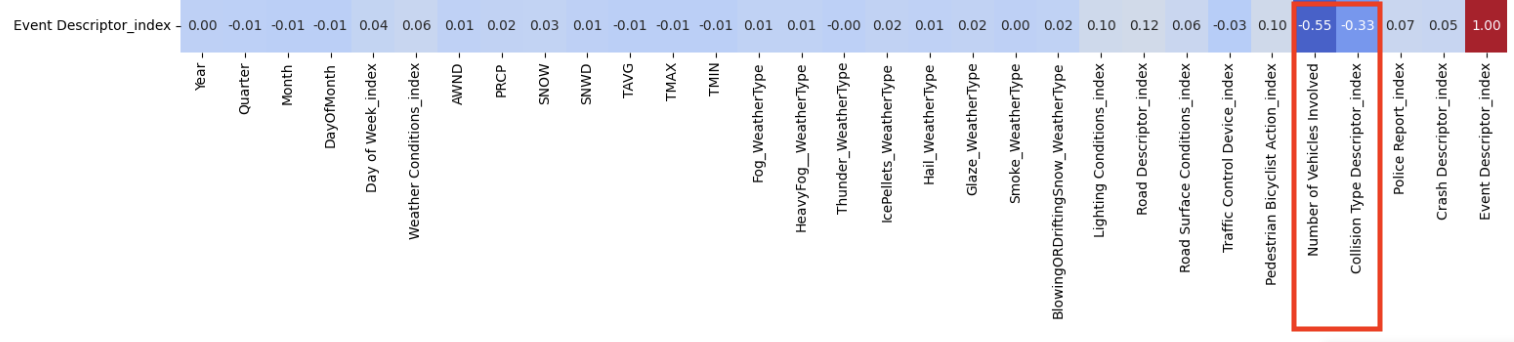

Based on the above analysis, we will select only `Number of Vehicles Involved` and `Collision Type Descriptor` as features of the KMean model.

### **Preprocessing**

**PART 1: Create a dataset for modeling with necessary columns**

In [ ]:
# Copy the dataset
df_c_kmeans_2 = df

In [ ]:

df_c_kmeans_2 = df_c_kmeans_2.withColumn('Event_Descriptor_Array', split(df['Event Descriptor'], ','))
df_c_kmeans_2 = df_c_kmeans_2.withColumn('Event_descriptor', df_c_kmeans_2['Event_Descriptor_Array'].getItem(0))
df_c_kmeans_2 = df_c_kmeans_2.withColumn('Event_descriptor_Type', df_c_kmeans_2['Event_Descriptor_Array'].getItem(1))
df_c_kmeans_2 = df_c_kmeans_2.drop('Column_1','Column_2', 'Event_Descriptor_Array')

In [ ]:
df_c_kmeans_2.show(2)

+----+--------------------+-------------------+----------+-----------+-------------+-------------------+-------------------------+------------------+------------------+----------------------+-----------------------+-----------------------------+---------------------------+--------------------+---------------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+-------------------+---------------------+
|Year|    Crash Descriptor|               Time|      Date|Day of Week|Police Report|Lighting Conditions|Collision Type Descriptor|   Road Descriptor|Weather Conditions|Traffic Control Device|Road Surface Conditions|DOT Reference Marker Location|Pedestrian Bicyclist Action|    Event Descriptor|Number of Vehicles Involved| AWND|PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_Weat

In [ ]:
# Handling missing or unexpected values in the given variables
for column in ['Number of Vehicles Involved', 'Collision Type Descriptor']:
    df_c_kmeans_filtered_2 = df_c_kmeans_2.filter(df_c_kmeans_2[column].isNotNull())

**PART 2: Create required classifiers and a pipeline for preprocessing** <br>

In [ ]:
# Indexing categorical columns
indexers_2 = [
    StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep")
    for column in ['Number of Vehicles Involved', 'Collision Type Descriptor']
]

# One-hot encoding indexed columns
encoders_2 = [
    OneHotEncoder(inputCol=column+"_index", outputCol=column+"_encoded")
    for column in ['Number of Vehicles Involved', 'Collision Type Descriptor']
]

# Create a pipeline
preprocessing_pipeline_2 = Pipeline(stages=indexers_2 + encoders_2)

**PART 3: Transform the dataset**

In [ ]:
# Transform the dataset
df_c_kmeans_preprocessed_2 = preprocessing_pipeline_2.fit(df_c_kmeans_2).transform(df_c_kmeans_2)

### **Modeling**

**PART 1: Create required classifiers** <br>
1) **KMeans**: Since we have to build the model, set the number of clusters as 4.

In [ ]:
encoded_columns_2 = ['Number of Vehicles Involved_encoded', 'Collision Type Descriptor_encoded']

# Creating a VectorAssembler with encoded columns
assembler_2 = VectorAssembler(inputCols=encoded_columns_2, outputCol='features')

# Scaling features
scaler_2 = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='scaled_features')

# Applying K-means clustering
kmeans_2 = KMeans(featuresCol='scaled_features', k=4, seed=42)

**PART 2: Create a pipeline**

In [ ]:
# Creating a pipeline
pipeline_2 = Pipeline(stages=[assembler_2, scaler_2, kmeans_2])

**PART 3: Fit and transform the dataset through the pipeline**

In [ ]:
# Fitting the pipeline
kmeans_model_2 = pipeline_2.fit(df_c_kmeans_preprocessed_2)

**PART 4: Getting cluster predictions**

In [ ]:
# Getting cluster predictions
predictions_2 = kmeans_model.transform(df_c_kmeans_preprocessed)

# Showing cluster results
predictions_2.select(
                   'Number of Vehicles Involved', 'Collision Type Descriptor', 'prediction').show()

+---------------------------+-------------------------+----------+
|Number of Vehicles Involved|Collision Type Descriptor|prediction|
+---------------------------+-------------------------+----------+
|                          2|              RIGHT ANGLE|         0|
|                          2|                 REAR END|         1|
|                          1|                    OTHER|         3|
|                          2|               OVERTAKING|         1|
|                          2|              RIGHT ANGLE|         1|
|                          2|                 REAR END|         1|
|                          2|                  Unknown|         1|
|                          2|               OVERTAKING|         1|
|                          1|                    OTHER|         3|
|                          2|                 REAR END|         1|
|                          2|               OVERTAKING|         1|
|                          2|                 REAR END|       

### **Evaluation**

In [ ]:
# Grouping by prediction
pattern_counts_2 = predictions_2.groupBy(
    'prediction',
    'Event_descriptor_Type'
).agg(count('*').alias('prediction_count')).orderBy(['prediction','prediction_count'], ascending = [True, False])

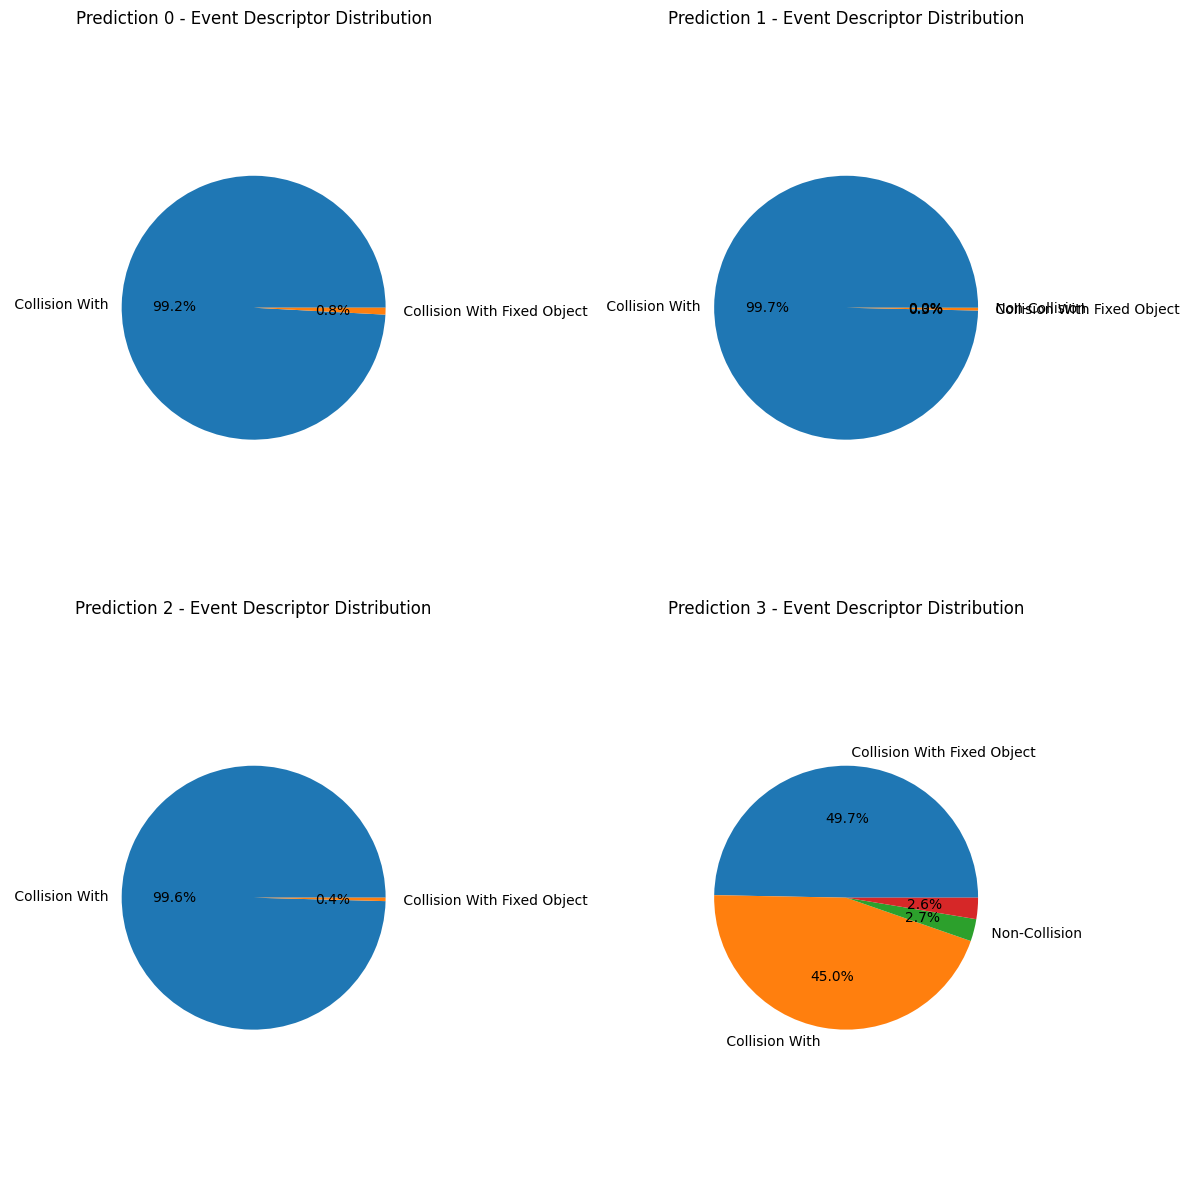

In [ ]:
# Separate data for each prediction
pie_chart_2 = sorted(pattern_counts_2.select('prediction').distinct().rdd.flatMap(lambda x: x).collect())

num_rows = 2
num_cols = 2
total_subplots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for idx, prediction in enumerate(pie_chart_2):
    if idx < total_subplots:
        # Filter data for a specific prediction
        prediction_data_2 = pattern_counts_2.filter(pattern_counts_2['prediction'] == prediction)

        # Get Event_Descriptor values and corresponding prediction counts
        event_descriptors_2 = prediction_data_2.select('Event_descriptor_Type').rdd.flatMap(lambda x: x).collect()
        prediction_counts_2 = prediction_data_2.select('prediction_count').rdd.flatMap(lambda x: x).collect()

        # Calculate subplot position
        row = idx // num_cols
        col = idx % num_cols

        # Create a pie chart for each prediction
        axs[row, col].pie(prediction_counts_2, labels=event_descriptors_2, autopct='%1.1f%%')
        axs[row, col].set_title(f'Prediction {prediction} - Event Descriptor Distribution')
        axs[row, col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

## **Advanced Research for TRIAL 2**

### Modeling

**PART 1: Create required classifiers and a pipeline** <br>

1) PCA
- `k=4`: We set the value of k as 4, because we will use 4 encoded variables in this case.

In [ ]:
# List of encoded columns for PCA
encoded_columns_2 = ['Number of Vehicles Involved_encoded', 'Collision Type Descriptor_encoded']

# Creating a VectorAssembler with encoded columns
assembler_2 = VectorAssembler(inputCols=encoded_columns_2, outputCol='features')

# Scaling features
scaler_2 = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='scaled_features')

# Perform PCA
pca = PCA(k=4, inputCol='features', outputCol='pca_features')

# create a pipeline
pca_pipeline = Pipeline(stages=[assembler_2, scaler_2, pca])
pca_model = pca_pipeline.fit(df_c_kmeans_preprocessed_2)
pca_result = pca_model.transform(df_c_kmeans_preprocessed_2)

2) A scree plot and a cumulative sum of variance explained

Text(0, 0.5, 'Proportion Variance Explained')

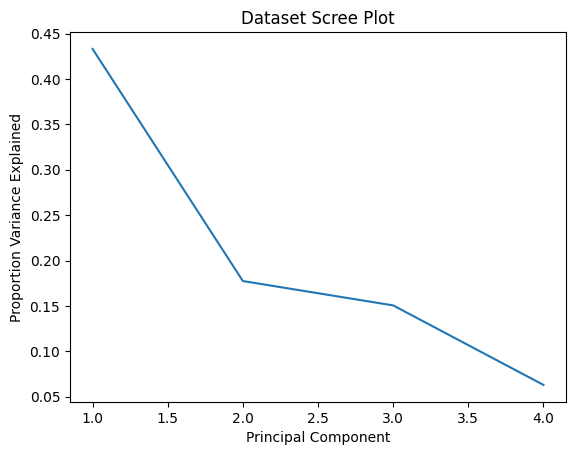

In [ ]:

plt.figure()
explained_var = pca_model.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var) + 1), explained_var)
plt.title('Dataset Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion Variance Explained')

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

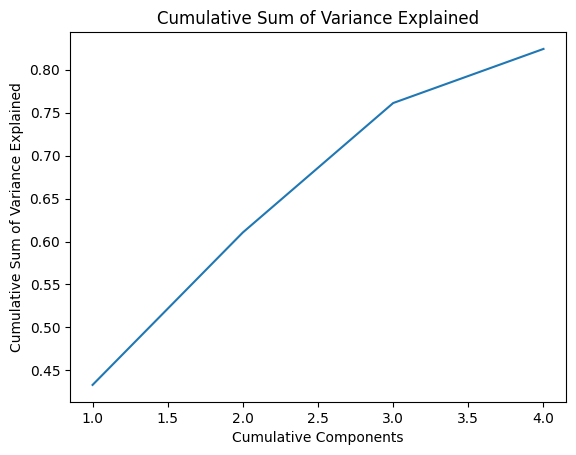

In [ ]:
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title('Cumulative Sum of Variance Explained')
plt.xlabel('Cumulative Components')
plt.ylabel('Cumulative Sum of Variance Explained')

**Conclusion**: Based on the scree variance explained plot, we would select 2 principal components for building the unsupervised machine learning model. After the 2nd component, the curve starts to flatten out. It means that approximately 95% of the variance is explained by 2 components.

**PART 2: Transform the dataset through the pipeline and determining optimal K for KMeans using the transformed data from PCA**

Adjust the k value of pca

In [ ]:
# Perform PCA
pca = PCA(k=2, inputCol='features', outputCol='pca_features')

In [ ]:
# create a pipeline
pca_pipeline = Pipeline(stages=[assembler_2, scaler_2, pca])
pca_model = pca_pipeline.fit(df_c_kmeans_preprocessed_2)
pca_result = pca_model.transform(df_c_kmeans_preprocessed_2)

Find the optimal K

In [ ]:

cost = []
for k in range(2, 10):
    kmeans = KMeans(featuresCol='pca_features', k=k, seed=42)
    model = kmeans.fit(pca_result)
    transformed_data = model.transform(pca_result)
    centers = model.clusterCenters()
    cost.append(sum([min([np.linalg.norm(p - c) for c in centers])**2 for p in transformed_data.select('pca_features').collect()]))
cost

[5439.258913562887,
 1256.8432497209183,
 378.047029436798,
 226.6366078162114,
 68.64568363058596,
 1.5269373572799365,
 0.14994513028641726,
 0.14994513028641726]

Visualization

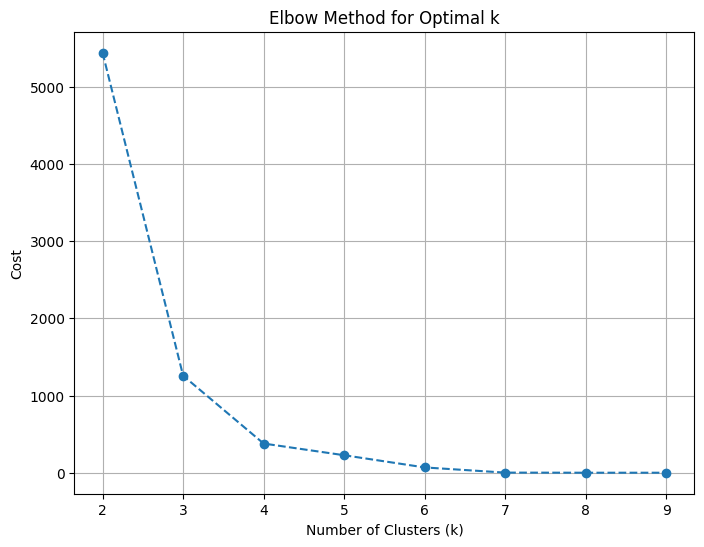

In [ ]:
# Plotting the cost against the number of clusters (elbow method)
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), cost, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

**Conclusion**: Based on the scree variance explained plot, we would set the optimal k value is 4 for building the unsupervised machine learning model. After the 4, the curve starts to flatten out.

In [ ]:
optimal_k = 4

**PART 3: Applying KMeans clustering with optimal k**

In [ ]:
kmeans_optimal = KMeans(featuresCol='pca_features', k=optimal_k, seed=42)
kmeans_model_optimal = kmeans_optimal.fit(pca_result)
predictions_optimal = kmeans_model_optimal.transform(pca_result)


**PART 4: Visualization for evaluation**

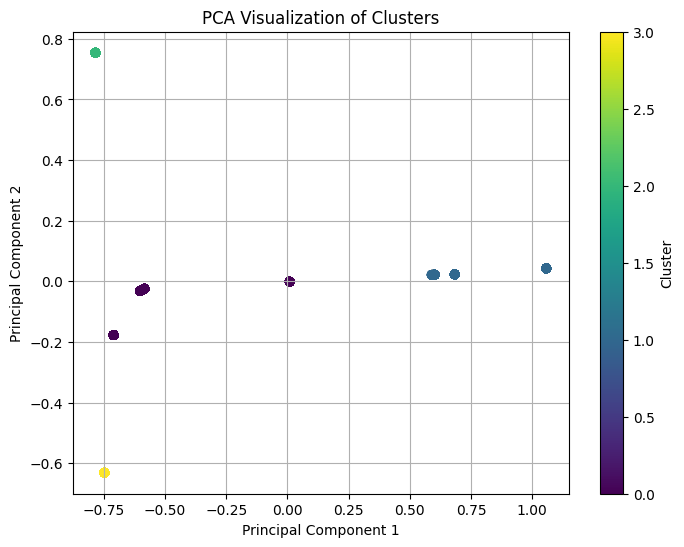

In [ ]:
# Visualization (assuming 2 principal components for visualization)
pandas_df = pca_result.select('pca_features').toPandas()

plt.figure(figsize=(8, 6))
plt.scatter(pandas_df['pca_features'].apply(lambda x: x[0]), pandas_df['pca_features'].apply(lambda x: x[1]), c=predictions_optimal.select('prediction').toPandas()['prediction'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Clusters')
plt.grid()
plt.colorbar(label='Cluster')
plt.show()

### Evaluation

**PART 1: Visualization**

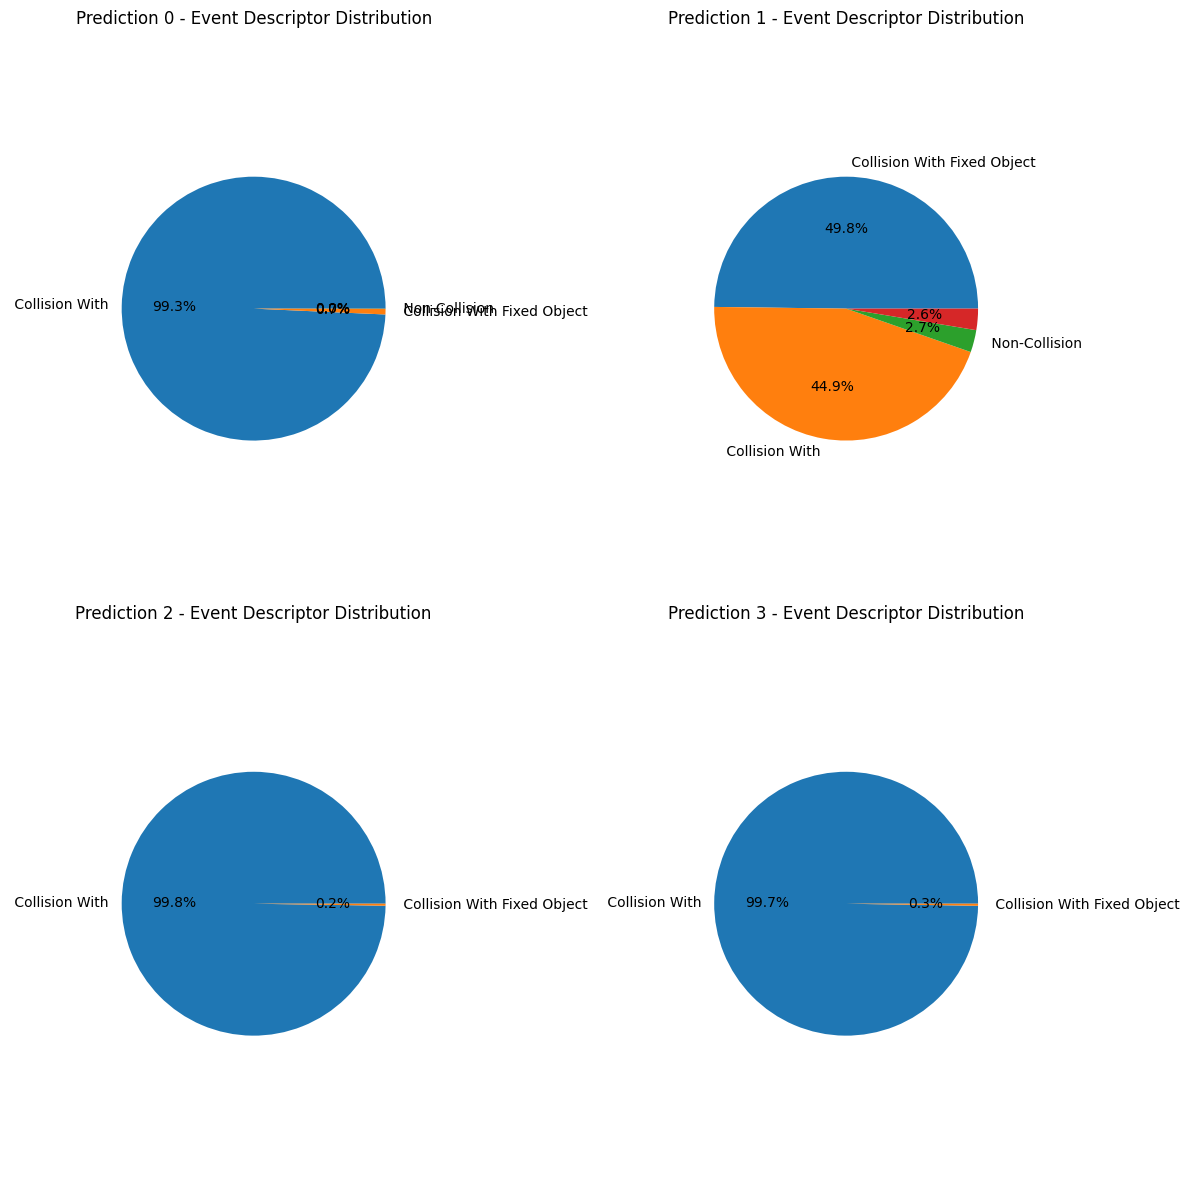

In [ ]:

# Grouping by prediction
pattern_counts_optimal = predictions_optimal.groupBy(
    'prediction',
    'Event_descriptor_Type'
).agg(count('*').alias('prediction_count')).orderBy(['prediction','prediction_count'], ascending = [True, False])

# Separate data for each prediction
pie_chart_optimal = sorted(pattern_counts_optimal.select('prediction').distinct().rdd.flatMap(lambda x: x).collect())

num_rows = 2
num_cols = 2
total_subplots = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for idx, prediction in enumerate(pie_chart_optimal):
    if idx < total_subplots:
        # Filter data for a specific prediction
        prediction_data_optimal = pattern_counts_optimal.filter(pattern_counts_optimal['prediction'] == prediction)

        # Get Event_Descriptor values and corresponding prediction counts
        event_descriptors_optimal = prediction_data_optimal.select('Event_descriptor_Type').rdd.flatMap(lambda x: x).collect()
        prediction_counts_optimal = prediction_data_optimal.select('prediction_count').rdd.flatMap(lambda x: x).collect()

        # Calculate subplot position
        row = idx // num_cols
        col = idx % num_cols

        # Create a pie chart for each prediction
        axs[row, col].pie(prediction_counts_optimal, labels=event_descriptors_optimal, autopct='%1.1f%%')
        axs[row, col].set_title(f'Prediction {prediction} - Event Descriptor Distribution')
        axs[row, col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

**PART 2: Evaluation Metrics**

1) Sum of Squared Error

In [ ]:

summary = kmeans_model_2.stages[-1].summary
sse_before = summary.trainingCost
sse_after = kmeans_model_optimal.summary.trainingCost
print("Sum of Squared Errors (SSE) before PCA:", sse_before)
print("Sum of Squared Errors (SSE) before PCA:", sse_after)

Sum of Squared Errors (SSE) before PCA: 11022.837310550498
Sum of Squared Errors (SSE) before PCA: 378.04702943680127


**Conclusion**: The lower SSE value (378.04702943680127) after PCA implies that the clusters formed are more compact, indicating that the points within each cluster are closer to their centroids, resulting in a better-defined clustering structure compared to the model before PCA.


2) Silhouette Score

In [ ]:

evaluator = ClusteringEvaluator()
silhouette_score_before = evaluator.evaluate(predictions_2)
silhouette_score_after = evaluator.evaluate(predictions_optimal)
print("Silhouette Score before PCA:", silhouette_score_before)
print("Silhouette Score after PCA:", silhouette_score_after)

Silhouette Score before PCA: 0.27269242113142145
Silhouette Score after PCA: 0.7101860406915934


**Conclusion**: The higher Silhouette Score after PCA (0.27269242113142145) suggests that the clustering structure is more well-defined and distinct compared to the model before PCA (0.7101860406915934). The model after PCA appears to have a better-defined clustering structure according to the Silhouette Score.

## **Final Conclusion**

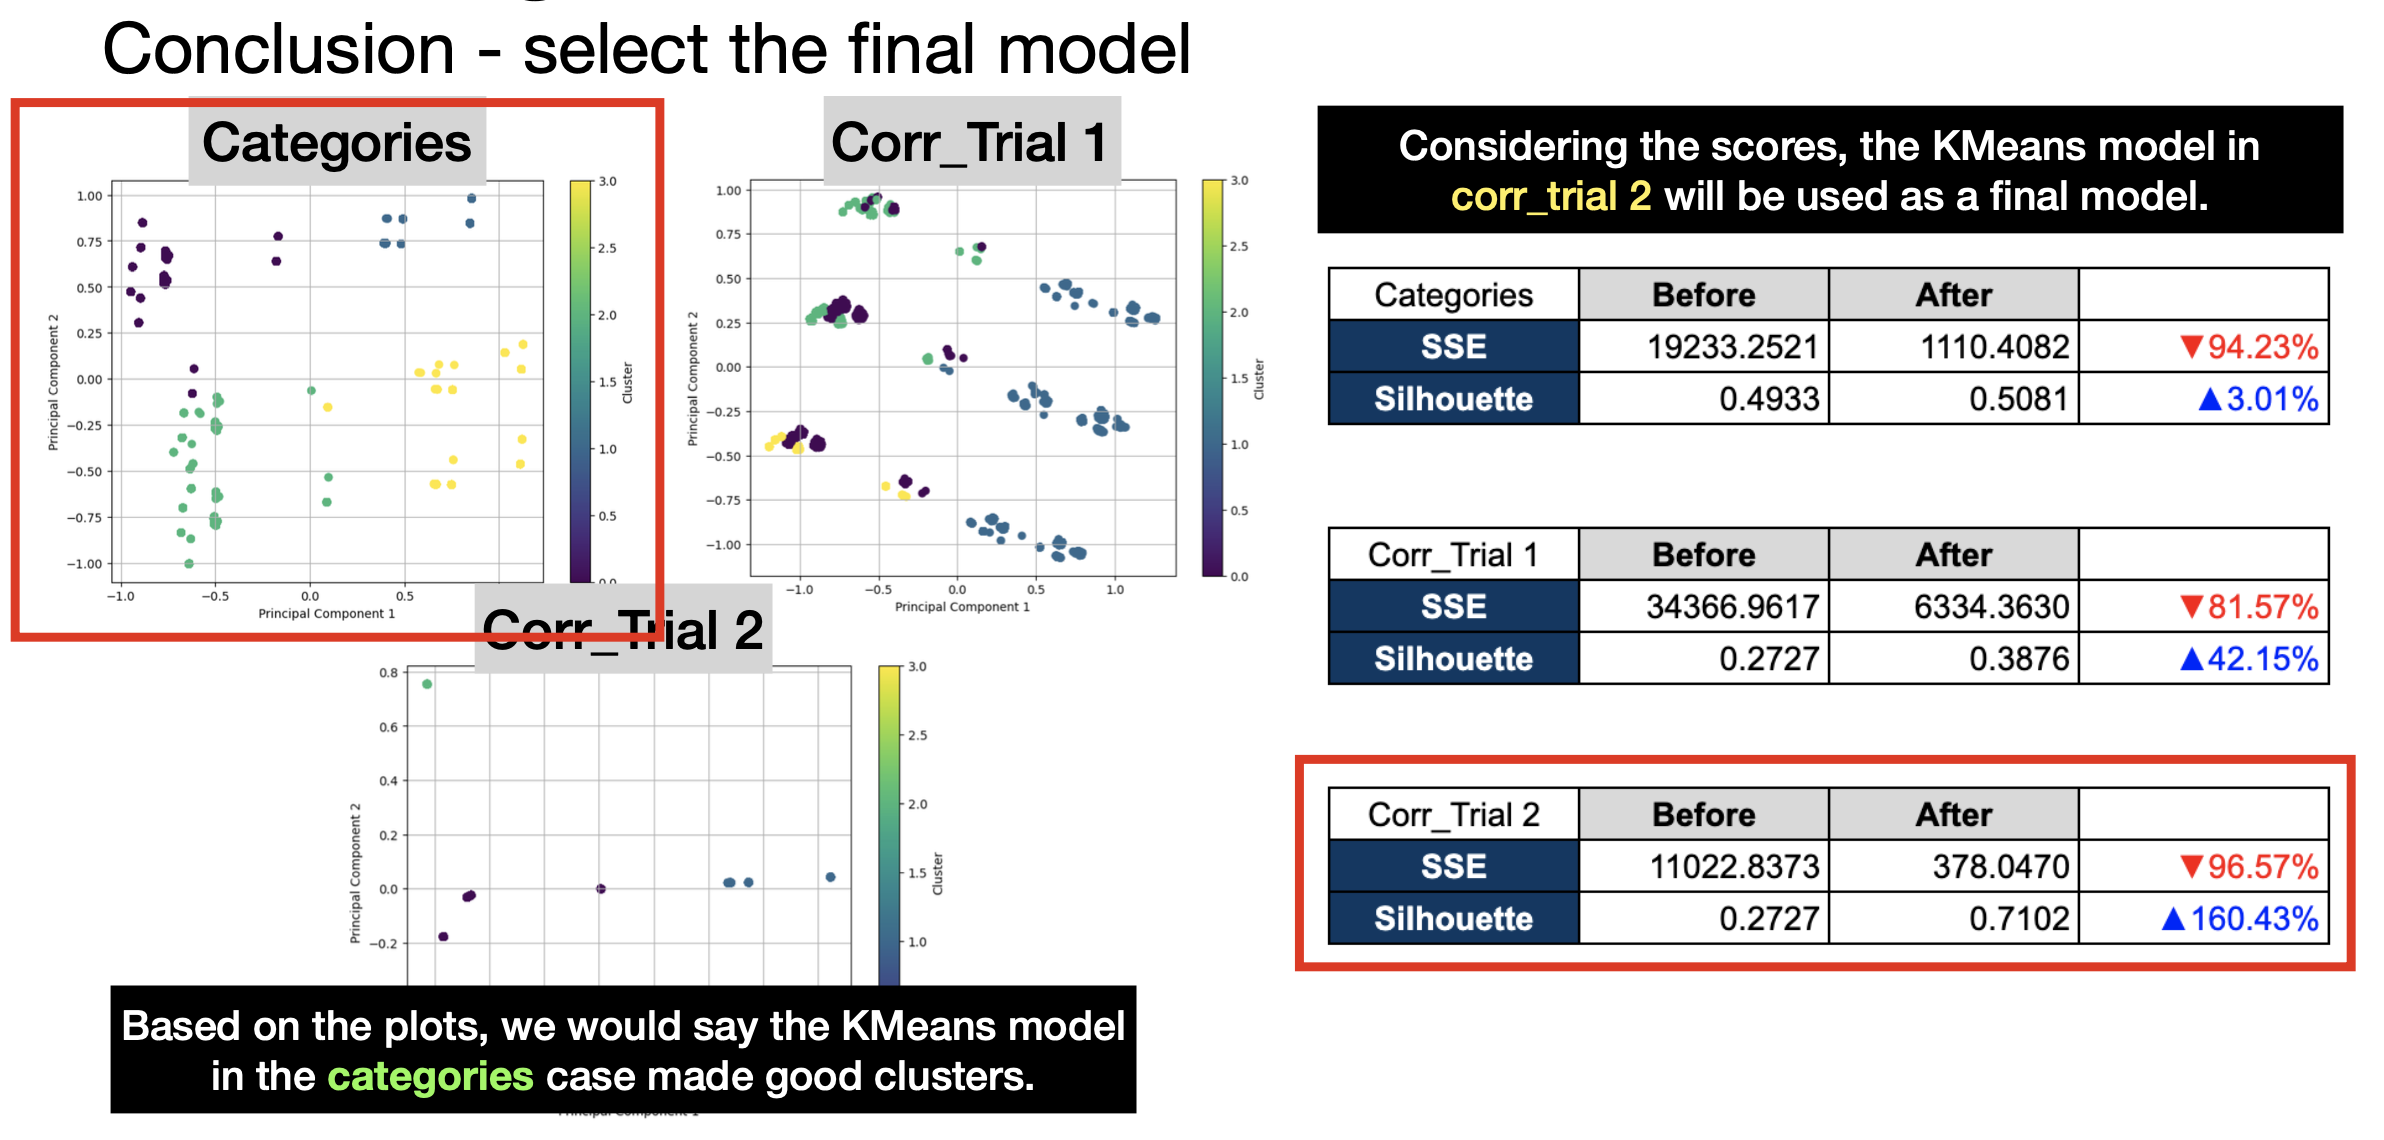

**Final Model** <br>
Based on the visualization and scores of KMeans clustering models, we selected ***the KMeans algorithm of Corr_Trial 2*** (selecting `Number of Vehicles Involved` and `Collision Type Descriptor` as features).

Check the most frequent patterns in each cluster with the final KMeans model

In [ ]:
# split the Date into quarter, month, and dayofmonth
predictions_optimal = predictions_optimal.withColumn("Quarter", quarter("Date"))
predictions_optimal = predictions_optimal.withColumn("Month", month("Date"))
predictions_optimal = predictions_optimal.withColumn("DayOfMonth", dayofmonth("Date"))

**1) All factors** <br>
The dataset showcases various collision instances, detailing factors like weather conditions, road surface, lighting, and collision types. These instances involve mostly property damage accidents involving collisions with other motor vehicles, often occurring in daylight, with clear or snowy weather conditions, and predominantly on dry or snow/ice-covered road surfaces.

In [ ]:
from pyspark.sql.functions import col
# Grouping by prediction and original categorical columns, counting occurrences
pattern_counts = predictions_optimal.groupBy(
    'prediction',
    'Event_descriptor_Type',
    'Event_descriptor',
    'Quarter', 'Month', 'DayOfMonth', 'Day of Week', 'Weather Conditions',
    'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'Fog_WeatherType',
    'HeavyFog__WeatherType', 'Thunder_WeatherType', 'IcePellets_WeatherType', 'Hail_WeatherType',
    'Glaze_WeatherType', 'Smoke_WeatherType', 'BlowingORDriftingSnow_WeatherType',
    'Lighting Conditions', 'Road Descriptor', 'Road Surface Conditions',
    'Traffic Control Device', 'Pedestrian Bicyclist Action', 'Number of Vehicles Involved',
    'Collision Type Descriptor', 'Police Report', 'Crash Descriptor'
).agg(count('*').alias('pattern_count'))

# Ranking the patterns within each prediction group based on count
window_spec = Window.partitionBy('prediction').orderBy(desc('pattern_count'))
ranked_patterns = pattern_counts.withColumn('rank', dense_rank().over(window_spec))

# Filtering to display the most frequent patterns (top patterns)
top_patterns = ranked_patterns.filter(col('rank') <= 1)

# Showing the most frequent patterns in each prediction group
top_patterns.select(
    'prediction',
    'pattern_count',
    'Event_descriptor_Type',
    'Event_descriptor',
    'Quarter', 'Month', 'DayOfMonth', 'Day of Week', 'Weather Conditions',
    'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'Fog_WeatherType',
    'HeavyFog__WeatherType', 'Thunder_WeatherType', 'IcePellets_WeatherType', 'Hail_WeatherType',
    'Glaze_WeatherType', 'Smoke_WeatherType', 'BlowingORDriftingSnow_WeatherType',
    'Lighting Conditions', 'Road Descriptor', 'Road Surface Conditions',
    'Traffic Control Device', 'Pedestrian Bicyclist Action', 'Number of Vehicles Involved',
    'Collision Type Descriptor', 'Police Report', 'Crash Descriptor'
).show(truncate=False)


+----------+-------------+----------------------------+-------------------------+-------+-----+----------+-----------+------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+-------------------+------------------+-----------------------+----------------------+---------------------------+---------------------------+-------------------------+-------------+------------------------+
|prediction|pattern_count|Event_descriptor_Type       |Event_descriptor         |Quarter|Month|DayOfMonth|Day of Week|Weather Conditions|AWND |PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSnow_WeatherType|Lighting Conditions|Road Descriptor   |Road Surface Conditions|Traffic Control Device|Pedestrian Bicyclist Act

**2) Date and Time Information** <br>
The dataset reveals several collision instances, primarily involving collisions with other motor vehicles on different days of the week and varying quarters and months. These collisions predominantly occurred on Wednesdays and Thursdays, with higher frequencies observed in January, February, and December.

In [ ]:
from pyspark.sql.functions import col
# Grouping by prediction and original categorical columns, counting occurrences
pattern_counts = predictions_optimal.groupBy(
    'prediction',
    'Event_descriptor_Type',
    'Event_descriptor',
    'Quarter', 'Month', 'DayOfMonth', 'Day of Week'
).agg(count('*').alias('pattern_count'))

# Ranking the patterns within each prediction group based on count
window_spec = Window.partitionBy('prediction').orderBy(desc('pattern_count'))
ranked_patterns = pattern_counts.withColumn('rank', dense_rank().over(window_spec))

# Filtering to display the most frequent patterns (top patterns)
top_patterns = ranked_patterns.filter(col('rank') <= 1)

# Showing the most frequent patterns in each prediction group
top_patterns.select(
    'prediction',
    'pattern_count',
    'Event_descriptor_Type',
    'Event_descriptor',
    'Quarter', 'Month', 'DayOfMonth', 'Day of Week'
).show(truncate=False)


+----------+-------------+----------------------------+-----------------------+-------+-----+----------+-----------+
|prediction|pattern_count|Event_descriptor_Type       |Event_descriptor       |Quarter|Month|DayOfMonth|Day of Week|
+----------+-------------+----------------------------+-----------------------+-------+-----+----------+-----------+
|0         |19           | Collision With             |Other Motor Vehicle    |1      |1    |16        |Thursday   |
|1         |8            | Collision With Fixed Object|Guide Rail - Not At End|4      |12   |22        |Friday     |
|2         |24           | Collision With             |Other Motor Vehicle    |1      |2    |27        |Wednesday  |
|2         |24           | Collision With             |Other Motor Vehicle    |1      |1    |8         |Wednesday  |
|3         |18           | Collision With             |Other Motor Vehicle    |1      |1    |8         |Wednesday  |
+----------+-------------+----------------------------+---------

**3) Environmental Factors** <br>

The dataset showcases a predominant trend of collisions involving other motor vehicles occurring in daylight conditions, predominantly on straight and level roads with dry surface conditions. These factors consistently account for the majority of recorded collision incidents across various predictions.

In [ ]:
# Grouping by prediction and original categorical columns, counting occurrences
pattern_counts = predictions_optimal.groupBy(
    'prediction',
    'Event_descriptor_Type',
    'Event_descriptor',
    'Lighting Conditions', 'Road Descriptor', 'Road Surface Conditions'
).agg(count('*').alias('pattern_count'))

# Ranking the patterns within each prediction group based on count
window_spec = Window.partitionBy('prediction').orderBy(desc('pattern_count'))
ranked_patterns = pattern_counts.withColumn('rank', dense_rank().over(window_spec))

# Filtering to display the most frequent patterns (top patterns)
top_patterns = ranked_patterns.filter(col('rank') <= 1)

# Showing the most frequent patterns in each prediction group
top_patterns.select(
    'prediction',
    'pattern_count',
    'Event_descriptor_Type',
    'Event_descriptor',
    'Lighting Conditions', 'Road Descriptor', 'Road Surface Conditions'
).show(truncate=False)


+----------+-------------+---------------------+-------------------+-------------------+------------------+-----------------------+
|prediction|pattern_count|Event_descriptor_Type|Event_descriptor   |Lighting Conditions|Road Descriptor   |Road Surface Conditions|
+----------+-------------+---------------------+-------------------+-------------------+------------------+-----------------------+
|0         |3015         | Collision With      |Other Motor Vehicle|Daylight           |Straight and Level|Dry                    |
|1         |523          | Collision With      |Other Motor Vehicle|Daylight           |Straight and Level|Dry                    |
|2         |2056         | Collision With      |Other Motor Vehicle|Daylight           |Straight and Level|Dry                    |
|3         |1904         | Collision With      |Other Motor Vehicle|Daylight           |Straight and Level|Dry                    |
+----------+-------------+---------------------+-------------------+--------

**4) Weather Conditions** <br>
The data presents a clear correlation between various collisions and snowy weather conditions. Most collisions, especially those involving other motor vehicles and fixed objects, occurred during snowy weather, characterized by specific wind speed ranges, precipitation levels, and temperature averages. Snow and related adverse weather elements significantly impacted these collision events across different prediction patterns.



In [ ]:
# Grouping by prediction and original categorical columns, counting occurrences
pattern_counts = predictions_optimal.groupBy(
    'prediction',
    'Event_descriptor_Type',
    'Event_descriptor',
    'Weather Conditions',
    'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'Fog_WeatherType',
    'HeavyFog__WeatherType', 'Thunder_WeatherType', 'IcePellets_WeatherType', 'Hail_WeatherType',
    'Glaze_WeatherType', 'Smoke_WeatherType', 'BlowingORDriftingSnow_WeatherType'
).agg(count('*').alias('pattern_count'))

# Ranking the patterns within each prediction group based on count
window_spec = Window.partitionBy('prediction').orderBy(desc('pattern_count'))
ranked_patterns = pattern_counts.withColumn('rank', dense_rank().over(window_spec))

# Filtering to display the most frequent patterns (top patterns)
top_patterns = ranked_patterns.filter(col('rank') <= 1)

# Showing the most frequent patterns in each prediction group
top_patterns.select(
    'prediction',
    'pattern_count',
    'Event_descriptor_Type',
    'Event_descriptor',
    'Weather Conditions',
    'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'Fog_WeatherType',
    'HeavyFog__WeatherType', 'Thunder_WeatherType', 'IcePellets_WeatherType', 'Hail_WeatherType',
    'Glaze_WeatherType', 'Smoke_WeatherType', 'BlowingORDriftingSnow_WeatherType'
).show(truncate=False)


+----------+-------------+----------------------------+--------------------------+------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+
|prediction|pattern_count|Event_descriptor_Type       |Event_descriptor          |Weather Conditions|AWND |PRCP|SNOW|SNWD|TAVG|TMAX|TMIN|Fog_WeatherType|HeavyFog__WeatherType|Thunder_WeatherType|IcePellets_WeatherType|Hail_WeatherType|Glaze_WeatherType|Smoke_WeatherType|BlowingORDriftingSnow_WeatherType|
+----------+-------------+----------------------------+--------------------------+------------------+-----+----+----+----+----+----+----+---------------+---------------------+-------------------+----------------------+----------------+-----------------+-----------------+---------------------------------+
|0         |16           | Collision With             |Other Motor Vehicle       |

**5) Traffic Control and Pedestrian Information** <br>
The data reflects a significant trend where the majority of collisions, particularly those involving other motor vehicles, occurred when there was no specific traffic control device or pedestrian/bicyclist action involved. However, a distinct pattern is observed in the third prediction pattern where collisions occurred with a noticeable frequency at locations where stop signs were present, albeit without involvement from pedestrians or bicyclists.

In [ ]:
# Grouping by prediction and original categorical columns, counting occurrences
pattern_counts = predictions_optimal.groupBy(
    'prediction',
    'Event_descriptor_Type',
    'Event_descriptor',
    'Traffic Control Device', 'Pedestrian Bicyclist Action'
).agg(count('*').alias('pattern_count'))

# Ranking the patterns within each prediction group based on count
window_spec = Window.partitionBy('prediction').orderBy(desc('pattern_count'))
ranked_patterns = pattern_counts.withColumn('rank', dense_rank().over(window_spec))

# Filtering to display the most frequent patterns (top patterns)
top_patterns = ranked_patterns.filter(col('rank') <= 1)

# Showing the most frequent patterns in each prediction group
top_patterns.select(
    'prediction',
    'pattern_count',
    'Event_descriptor_Type',
    'Event_descriptor',
    'Traffic Control Device', 'Pedestrian Bicyclist Action'
).show(truncate=False)


+----------+-------------+---------------------+-------------------+----------------------+---------------------------+
|prediction|pattern_count|Event_descriptor_Type|Event_descriptor   |Traffic Control Device|Pedestrian Bicyclist Action|
+----------+-------------+---------------------+-------------------+----------------------+---------------------------+
|0         |4932         | Collision With      |Other Motor Vehicle|None                  |Not Applicable             |
|1         |808          | Collision With      |Other Motor Vehicle|None                  |Not Applicable             |
|2         |2770         | Collision With      |Other Motor Vehicle|None                  |Not Applicable             |
|3         |1593         | Collision With      |Other Motor Vehicle|Stop Sign             |Not Applicable             |
+----------+-------------+---------------------+-------------------+----------------------+---------------------------+



**6) Accident Information** <br>

The data shows distinct patterns in types of collisions involving other motor vehicles, with prevalent scenarios involving two vehicles and commonly identified collision types such as overtaking, rear-end collisions, right-angle collisions, and other unspecified incidents, all resulting in property damage. These patterns provide insights into the predominant circumstances surrounding such incidents.

In [ ]:
# Grouping by prediction and original categorical columns, counting occurrences
pattern_counts = predictions_optimal.groupBy(
    'prediction',
    'Event_descriptor_Type',
    'Event_descriptor',
    'Number of Vehicles Involved',
    'Collision Type Descriptor', 'Police Report', 'Crash Descriptor'
).agg(count('*').alias('pattern_count'))

# Ranking the patterns within each prediction group based on count
window_spec = Window.partitionBy('prediction').orderBy(desc('pattern_count'))
ranked_patterns = pattern_counts.withColumn('rank', dense_rank().over(window_spec))

# Filtering to display the most frequent patterns (top patterns)
top_patterns = ranked_patterns.filter(col('rank') <= 1)

# Showing the most frequent patterns in each prediction group
top_patterns.select(
    'prediction',
    'pattern_count',
    'Event_descriptor_Type',
    'Event_descriptor',
    'Number of Vehicles Involved',
    'Collision Type Descriptor', 'Police Report', 'Crash Descriptor'
).show(truncate=False)


+----------+-------------+---------------------+-------------------+---------------------------+-------------------------+-------------+------------------------+
|prediction|pattern_count|Event_descriptor_Type|Event_descriptor   |Number of Vehicles Involved|Collision Type Descriptor|Police Report|Crash Descriptor        |
+----------+-------------+---------------------+-------------------+---------------------------+-------------------------+-------------+------------------------+
|0         |3531         | Collision With      |Other Motor Vehicle|2                          |OVERTAKING               |Y            |Property Damage Accident|
|1         |712          | Collision With      |Other Motor Vehicle|3                          |OTHER                    |Y            |Property Damage Accident|
|2         |3939         | Collision With      |Other Motor Vehicle|2                          |REAR END                 |Y            |Property Damage Accident|
|3         |3413         | C

**Conclusion** <br>
Using the final KMeans model, we can excatly create 4 clusters in Accident Information and Environmental Factors.
1. Showcasing various collision scenarios involving multiple vehicles, such as overtaking, rear-end collisions, and right-angle impacts, each with varying frequencies and police report fillings predominately resulting in property damage.
2. Considering environmental conditions, a majority occurring during daylight hours under consistent road conditions of straight and level surfaces with dry road surfaces.

## 3. Anomaly Detection
Using the final KMeans clustering model, we will build an anomaly detection system to answer the below question.
- Can we identify anomalies or outliers in accident occurrences based on the collected attributes?

## **Question 1. Can we identify anomalies or outliers in accident occurrences based on the collected attributes?**


### Preprocessing

**PART 1: Create a pipeline, including the encoder, assember, scaler, and pca classifier that are used in the final KMeans model.**

In [ ]:
# List of encoded columns for PCA
encoded_columns_2 = ['Number of Vehicles Involved_encoded', 'Collision Type Descriptor_encoded']

# Creating a VectorAssembler with encoded columns
assembler_2 = VectorAssembler(inputCols=encoded_columns_2, outputCol='features')

# Scaling features
scaler_2 = StandardScaler(withMean=True, withStd=False, inputCol='features', outputCol='scaled_features')

# Perform PCA
pca = PCA(k=2, inputCol='features', outputCol='pca_features')

# create a pipeline
pca_pipeline = Pipeline(stages=[assembler_2, scaler_2, pca])

### Modeling

**PART 1: Transform the dataset with the pipeline**

In [ ]:
# Transform the dataset
pca_model = pca_pipeline.fit(df_c_kmeans_preprocessed_2)
pca_result = pca_model.transform(df_c_kmeans_preprocessed_2)

kmeans_optimal = KMeans(featuresCol='pca_features', k=optimal_k, seed=42)
kmeans_model_optimal = kmeans_optimal.fit(pca_result)

**PART 2: Calculate the distance to nearest cluster centroid for each point and create a udf of this calculation**

In [ ]:
# Calculate distance to nearest cluster centroid for each point
def calculate_distance(vector, centroid):
    return float(Vectors.squared_distance(vector, centroid))

# Convert the cluster centers to a broadcast variable for efficient use in UDF
cluster_centers = kmeans_model_optimal.clusterCenters()
broadcast_centers = spark.sparkContext.broadcast(cluster_centers)

# Define a UDF to calculate distance from each point to its assigned cluster center
@F.udf(returnType=DoubleType())
def calculate_distance_udf(features):
    distances = [calculate_distance(features, centroid) for centroid in broadcast_centers.value]
    return float(min(distances))

**PART 3: Apply the UDF to the DataFrame**

In [ ]:

# Apply the UDF to the DataFrame
df_with_distances = kmeans_model_optimal.transform(pca_result).withColumn(
    "distance", calculate_distance_udf(col("pca_features")))

### Application

**PART 1: Define a threshold and identify anomalies**

In [ ]:
# Define a threshold for anomaly detection based on distances (adjust as needed)
threshold = 0.1  # Modify as required

# Identify anomalies (points with distance greater than the threshold)
anomalies = df_with_distances.filter(col("distance") > threshold)

**PART 2: Find the optimal threshold for the anomaly detection model.**

Trial 1: Investigate the threshold between 0.1 and 0.5 (interval = 0.05)
- We can find the anomalies as the threshold is less than or equal to 0.4.

In [ ]:
threshold_list = []
start_threshold = 0.1
end_threshold = 0.5
interval = 0.05

# Generating threshold list
threshold = start_threshold
while threshold >= end_threshold:
    threshold_list.append(threshold)
    threshold -= interval

for threshold in threshold_list:
    anomalies_i = df_with_distances.filter(col("distance") > threshold)
    print("Anomalies count for threshold {}: {}".format(threshold, anomalies_i.count()))


Trial 2: Investigate the threshold between 0.41 and 0.42 (interval = 0.001)

In [ ]:
threshold_list = []
start_threshold = 0.42
end_threshold = 0.41
interval = 0.001

# Generating threshold list
threshold = start_threshold
while threshold >= end_threshold:
    threshold_list.append(threshold)
    threshold -= interval

for threshold in threshold_list:
    anomalies_i = df_with_distances.filter(col("distance") > threshold)
    print("Anomalies count for threshold {}: {}".format(threshold, anomalies_i.count()))


Anomalies count for threshold 0.42: 0
Anomalies count for threshold 0.419: 0
Anomalies count for threshold 0.418: 0
Anomalies count for threshold 0.417: 0
Anomalies count for threshold 0.416: 0
Anomalies count for threshold 0.415: 0
Anomalies count for threshold 0.414: 0
Anomalies count for threshold 0.413: 350
Anomalies count for threshold 0.412: 350
Anomalies count for threshold 0.411: 350
Anomalies count for threshold 0.41: 350


Trial 3: Investigate the threshold between 0.412 and 0.413 (interval = 0.0001)

In [ ]:
threshold_list = []
start_threshold = 0.413
end_threshold = 0.412
interval = 0.0001

# Generating threshold list
threshold = start_threshold
while threshold >= end_threshold:
    threshold_list.append(threshold)
    threshold -= interval

for threshold in threshold_list:
    anomalies_i = df_with_distances.filter(col("distance") > threshold)
    print("Anomalies count for threshold {}: {}".format(threshold, anomalies_i.count()))


Anomalies count for threshold 0.413: 350
Anomalies count for threshold 0.4129: 350
Anomalies count for threshold 0.4128: 350
Anomalies count for threshold 0.4127: 350
Anomalies count for threshold 0.4126: 350
Anomalies count for threshold 0.41250000000000003: 350
Anomalies count for threshold 0.41240000000000004: 350
Anomalies count for threshold 0.41230000000000006: 350
Anomalies count for threshold 0.41220000000000007: 350
Anomalies count for threshold 0.4121000000000001: 350
Anomalies count for threshold 0.4120000000000001: 350


According to the findings from the research, establish the threshold for identifying anomalies in the data as 0.413.

In [ ]:
anomalies = df_with_distances.filter(col("distance") > 0.413)
anomalies_final = anomalies.select('Number of Vehicles Involved','Collision Type Descriptor')

### Application

Define the specific pattern in the anomalies detected by the anomaly detection system based on the final KMeans model.

In [ ]:
anomalies_final.groupBy(
    'Number of Vehicles Involved','Collision Type Descriptor'
).agg(count('*').alias('count')).orderBy('count', ascending = [True, False]).toPandas()


Number of Vehicles Involved Collision Type Descriptor  count
0                            2                     OTHER    350

In the final KMeans model, we can find 350 anomalies in the clusters, with the patterns of accidents involving 2 cars  and undefined collision type descriptor.